# Predicting Project Success for New York City Capital Projects

### CS109b: Module E
### Project Team 71

### Authors:

1. An Hoang
2. Mark McDonald
3. Michael Sedelmeyer

# Introduction

## i. About this notebook

**ADD BRIEF DESCRIPTION OF WHAT THIS NOTEBOOK IS**

(SAMPLE) This notebook contains a set of baseline linear models created to predict `Budget_Change_Ratio` and `Schedule_Change_Ratio` using the small set of valid predictors available in our original dataset (therefore, no engineered features were used here.

- **For an overview of the analytical sections of this notebook, please see the <a href=#index>Notebook Contents</a> index listed below this introduction.**

### i.i. A note about supporting notebooks

The code and results given in this notebook are only a summary of the work completed toward this analysis. Supplemental notebooks containing the complete EDA, data cleansing, feature engineering, and model exploration illustrated in this report can be found in the **`notebooks/`** directory of the **[supporting GitHub project repository](https://github.com/mcdomx/cs109b_groupproject)**. The notebooks in that repository are designed to be run in sequential numbered order to reproduce the results shown here. In addition, throughout this report, we will provide links to specific supporting notebooks for further reference.

### i.ii. A note about supporting custom python modules

As you will see in the <a href=#imports>imports section</a> of this notebook, there are a number of custom python modules used to generate the results shown throughout this notebook. The code for these modules are stored separately in the **`src/`** directory of the **[supporting GitHub repository](https://github.com/mcdomx/cs109b_groupproject)** for better source code version control, reproducing output across multiple notebooks, and to keep the length of this report to a manageable length.

## ii. Research Question

Given the set of New York City Capital Projects change data, can we create a model that can accurately predict 3-year change in forecasted project budget and 3-year change in forecasted project duration using only the data available at the start of the project as our predictors?

In other words, using historical project data, can we predict how much the forecasted budget and duration of any given capital project run by the City of New York will deviate from it's original budgeted estimates by the end of year-3 for the project?

The significance of a model that can accurately address this question means, given any new project, project managers and city administrators could another tool at their disposal for objectively identifying potential budget and schedule risk at the start of a new city-run capital project. Such a tool can help to overcome common planning fallacies and ..... (TO ADD ADDITIONAL THEORETICAL TERMS FROM ACADEMIC PAPERS)

## iii. Summary of findings

**ADD AN EXECUTIVE SUMMARY OF OUR FINDINGS HERE (5-6 key points/findings)**

**SEE THE BASELINE LINEAR MODELS NOTEBOOK FOR AN EXAMPLE**

- Sigmoid scaled `Budget_Start` and `Duration_Start` predictor data sufficiently minimizes skew to provide the best predictive performance amongst our linear models.


- Our two predicted outcome variables, 3-year project `Budget_Change_Ratio` and `Schedule_Change_Ratio`, both exhibit different predictive behavior.


- While our linear models fail to predict `Budget_Change_Ratio` better than a naive model, as is evidenced by negative $R^2$ test score, our `Schedule_Change_Ratio` predictions do moderately well with our best test $R^2$ score exceeding 0.54.


- On the otherhand, our **smoothing spline GAM model with separately optimized $\lambda$ term penalties for each specific predicted outcome variable `Budget_Change_Ratio` and `Schedule_Change_Ratio`** demonstrated enough improvement in our $R^2$ scores to offer hope that a combination of additional engineered features and a sufficiently expressive model, might give us some form of acceptable predictive performance.

```
"BASELINE+" Smoothing Spline GAM results with optimized term penalties by response variable and a label-encoded `Category` predictor:

    ['Budget_Start', 'Duration_Start', `Category_Code`]
    

    R-squared scores:
    
        Budget_Change_Ratio

            Training	0.8263
            Test		-0.8736

        Schedule_Change_Ratio

            Training	0.5800
            Test		0.5373

```

<a name='index'></a>

# Contents of this notebook

1. **<a href=#data>About the data</a>**


2. **<a href=#question>Research question</a>**


3. **<a href=#features>Feature engineering</a>**
  - <a href=#clusters>Reference class clustering with Kmeans and UMAP</a>
  - <a href=#bert>Embedding project description text with Bert</a>
  - <a href=#encode>Encoding the Bert embedding with PCA, Autoencoders, and UMAP</a>


4. **<a href=#linear>Linear models</a>**
  - <a href=#baseline>Baseline linear regression</a>
  - <a href=#splines>Smoothing spline GAMs</a>
    - <a href=#spline1>Baseline predictors</a>
    - <a href=#spline2>Baseline plus engineered features</a>


5. **<a href=#nonparam>Nonparametric models</a>**
  - <a href=#trees>Decision tree regressors</a>
  - <a href=#boost>Ensemble tree regressors with boosting</a>


6. **<a href=#conclusions>Conclusions</a>**


7. **<a href=#future>Next steps \& future work</a>**


8. **<a href=#sources>Sources \& references</a>**


9. **<a href=#appendix>Appendix</a>**
  - <a href=#dict>Dictionary of features in final dataset</a>

<a name='imports'></a>

# Imported Modules and Data

In [19]:
from IPython.display import HTML, Image, IFrame, Markdown

HTML(
    '''<script> code_show=true; function code_toggle() {
    if (code_show){
    $('div.input').show();
    } else {
    $('div.input').hide();
    }
    code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
    </form>'''
)

In [67]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# general regressor, scaling, and scoring sklearn imports
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, \
                                  RobustScaler, LabelEncoder

# clustering specific imports
from sklearn.cluster import KMeans
from gap_statistic import OptimalK
import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import pdist
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_samples, silhouette_score


# statsmodels and pygam imports
import statsmodels.formula.api as sm
from pygam import LinearGAM, s, f

# import custom .py functions from src/ directory 
sys.path.append('..')
from src.datagen import print_interval_dict
from src.scale import scale_features, sigmoid, log_plus_one, encode_categories
from src.model import generate_model_dict, print_model_results
from src.visualize import plot_true_pred, plot_bdgt_sched_scaled, \
                          plot_change_trend, plot_gam_by_predictor, \
                          plot_line, plot_value_counts
from src.cluster import silplot, display_gapstat_with_errbars, \
                        fit_neighbors, plot_epsilon, silscore_dbscan, \
                        fit_dbscan, print_dbscan_results


# Avoid scientific notation output in Pandas
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.float_format = '{:,.2f}'.format

# Improve resolution of output graphics
%config InlineBackend.figure_format ='retina'

In [21]:
# establish file paths and check to ensure target files exist
filepath_train = '../data/processed/NYC_capital_projects_3yr_final_train.csv'
filepath_test = '../data/processed/NYC_capital_projects_3yr_final_test.csv'
filepath_full = '../data/interim/Capital_Projects_clean.csv'
filepath_allyears = '../data/interim/NYC_capital_projects_all.csv' 

error = None
for filepath in [filepath_train, filepath_test, filepath_full, filepath_allyears]: 
    if not os.path.isfile(filepath):
        error = 1
        print(
            "ERROR - the following target file does not exist:\n\n\t{}\n"\
            "".format(filepath)
        )

if error is None:
    print("OK - all filepaths point to existing files!")

OK - all filepaths point to existing files!


In [22]:
# load dataframes from target files and set datetime columns
data_train = pd.read_csv(filepath_train)
data_test = pd.read_csv(filepath_test)
data_full = pd.read_csv(filepath_full)
data_allyears = pd.read_csv(filepath_allyears)

datetime_cols = [
    'Design_Start',
    'Final_Change_Date',
    'Schedule_Start',
    'Schedule_End',
]

for col in datetime_cols:
    data_train[col] = pd.to_datetime(data_train[col])
    data_test[col] = pd.to_datetime(data_test[col])
    data_allyears[col] = pd.to_datetime(data_allyears[col])

In [23]:
def print_record_project_count(dataframe, dataset='full'):
    """Prints summary of records and unique projects in dataframe
    """
    if dataset=='full':
        print(
            'For the ORIGINAL cleansed data, containing all available NYC capital '\
            'projects change records:\n'
        )

    elif dataset=='all':
        print(
            'For the data containing start and end data for all available '\
            'NYC capital projects for the ENTIRE INTERVAL of changes '\
            'covered in the ORIGINAL data:\n'
        )
        
    else:
        print(
            'For the final {} data, containing the {} split of 3-year '\
            'project data used in this analysis:\n'.format(
                dataset.upper(), dataset
            )
        )    
    
    # entries
    print(f"\tNumber of dataset records: {len(dataframe)}")

    # num projects
    print(
        f"\tNumber of unique projects in dataset: {dataframe['PID'].nunique()}\n"
    )
    

print_record_project_count(data_full, 'full')
print_record_project_count(data_allyears, 'all')
print_record_project_count(data_train, 'training')
print_record_project_count(data_test, 'test')


For the ORIGINAL cleansed data, containing all available NYC capital projects change records:

	Number of dataset records: 2095
	Number of unique projects in dataset: 355

For the data containing start and end data for all available NYC capital projects for the ENTIRE INTERVAL of changes covered in the ORIGINAL data:

	Number of dataset records: 355
	Number of unique projects in dataset: 355

For the final TRAINING data, containing the training split of 3-year project data used in this analysis:

	Number of dataset records: 134
	Number of unique projects in dataset: 134

For the final TEST data, containing the test split of 3-year project data used in this analysis:

	Number of dataset records: 15
	Number of unique projects in dataset: 15



In [24]:
print(
    'The shapes of our loaded train-test splits are:\n\n'\
    '\tTrain\t{}\n\tTest\t{}\n'.format(
        data_train.shape, data_test.shape
    )
)

The shapes of our loaded train-test splits are:

	Train	(134, 53)
	Test	(15, 53)



In [25]:
print(
    'For future reference, here is an overview of the features '\
    'contained in our final TRAINING dataset:\n'
)

data_train.info()

print('\n\n...and, here are the first 3 rows of our TRAINING data:')
data_train.head(3)

For future reference, here is an overview of the features contained in our final TRAINING dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 53 columns):
Unnamed: 0                    134 non-null int64
PID                           134 non-null int64
Project_Name                  134 non-null object
Description                   134 non-null object
Category                      134 non-null object
Borough                       134 non-null object
Managing_Agency               134 non-null object
Client_Agency                 134 non-null object
Phase_Start                   134 non-null object
Current_Project_Years         134 non-null float64
Current_Project_Year          134 non-null int64
Design_Start                  134 non-null datetime64[ns]
Budget_Start                  134 non-null float64
Schedule_Start                134 non-null datetime64[ns]
Final_Change_Date             134 non-null datetime64[ns]
Final_Change_Years    

Unnamed: 0  PID                                       Project_Name  \
0           0  204           Edgewood Triangle Roadway Reconstruction   
1           1  577                    Bronx Public School 19 Addition   
2           2  664  NEW STRM SWR & WM REPLACEMENT IN ACACIA AVE, ETC.   

                                         Description              Category  \
0  Reconstruct roadway and extend storm and sanit...  Streets and Roadways   
1            Design and construction of a new school               Schools   
2  New Strom Sewer extension & Water Main replace...                Sewers   

         Borough Managing_Agency Client_Agency                 Phase_Start  \
0         Queens             DDC           DOT                    2-Design   
1          Bronx             SCA           DOE                    2-Design   
2  Staten Island             DDC           DEP  3-Construction Procurement   

   Current_Project_Years  ...  Category_Code umap_descr_2D_embed_1  \
0                   6.55  ...              7                  0.46   
1                   2.94  ...              5                -12.40   
2                   4.75  ...              6                 -0.47   

   umap_descr_2D_embed_2 umap_attributes_2D_embed_1  \
0                  -0.41                      12.32   
1                  -3.70                       8.39   
2                  -0.43                      16.50   

  umap_attributes_2D_embed_2  attribute_clustering_label ae_descr_embed_1  \
0                      10.59                           4             6.10   
1                      -1.15                           0             0.00   
2                      11.85                           5             5.16   

   ae_descr_embed_2 pca_descr_embed_1  pca_descr_embed_2  
0              4.54              6.02               3.01  
1             -0.01            -11.32              -2.94  
2              3.84              4.00               0.82  

[3 rows x 53 columns]

<a name='data'></a>

# 1. About the data

<a href=#index>Index</a>

**The unabridged notebooks used to generate the findings in this section can be [found here on GitHub](https://github.com/mcdomx/cs109b_groupproject/blob/master/notebooks/00_EDA_clean_NYC_data.ipynb) and [here on GitHub.](https://github.com/mcdomx/cs109b_groupproject/blob/master/notebooks/01_generate_data_splits.ipynb)**

In [26]:
# Mike

<a name='data'></a>

# 2. Research Question

<a href=#index>Index</a>

In [27]:
# Mike

<a name='features'></a>

# 3. Feature Engineering

<a href=#index>Index</a>

**IN THIS SECTION:**

**3.1. <a href=#clusters>Reference class clustering with Kmeans and UMAP</a>**

**3.2. <a href=#bert>Embedding project description text with Bert</a>**

**3.3  <a href=#encode>Encoding the Bert embedding with PCA, Autoencoders, and UMAP</a>**


<a name='clusters'></a>

## 3.1. Reference class clustering with K-means and UMAP

<a href=#features>Return to section index</a>

**IN THIS SECTION:**

**3.1.1. <a href=#kmeans>K-means clustering for reference class labels</a>**

**3.1.2. <a href=#umap>UMAP clustering for reference class labels</a>**


In [28]:
# mirror notebooks
# An - UMAP
# 3.2 Mark - Bert
# Mike - KMeans , AE, PCA

<a name='kmeans'></a>

### 3.1.1. K-means clustering for reference class labels

<a href=#clusters>Return to section index</a>

**The unabridged notebook used to generate the findings in this section can be [found here on GitHub.](https://github.com/mcdomx/cs109b_groupproject/blob/master/notebooks/02a_kmeans_attribute_clusters.ipynb)**

<a name='umap'></a>

### 3.1.2. UMAP clustering for reference class labels

<a href=#clusters>Return to section index</a>

**The unabridged notebook used to generate the findings in this section can be [found here on GitHub.](https://github.com/mcdomx/cs109b_groupproject/blob/master/notebooks/02b_UMAP_attribute_clusters.ipynb)**

<a name='bert'></a>

## 3.2. Embedding project descriptions text with Bert

<a href=#features>Return to section index</a>

**The unabridged notebook used to generate the findings in this section can be [found here on GitHub.](https://github.com/mcdomx/cs109b_groupproject/blob/master/notebooks/03a_bert_embeddings.ipynb)**

In [43]:
# bert embedding support
from keras_bert import extract_embeddings, POOL_NSP, POOL_MAX
import csv

import itertools
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

### Here, the objective is to create an embedding from the project descrptions.  We won't be making predictions based on the the descriptions, but simply extracting the latent space that BERT provides.  We use the smallest of available latent space dimensions to avoid training complexity.  If the description embeddings prove useful, it may be useful to use a larger latent space in the future.

### BERT was chosen as it is a leading NLP model at the moment and has a bi-directional character which should allow the resulting embedding to be more expressive.

In [44]:
# bert pretrained model
BERT_BASE_DIR = os.path.join(os.getcwd(), 'pretrained_bert')
bert_model = 'uncased_L-2_H-128_A-2' 
model_path = os.path.join(BERT_BASE_DIR, bert_model)

# source of data descriptions
file_path = '../data/interim/NYC_capital_projects_all.csv'
if os.path.isfile(file_path) and os.path.isdir(BERT_BASE_DIR):
    print("OK - both path points to files.")
else:
    print("ERROR - check the 'file_path' and ensure it points to the source file.")

OK - both path points to files.


In [45]:
data = pd.read_csv(file_path)
all_descriptions = data[['PID', 'Description']].drop_duplicates()

In [46]:
# get the indexes of just the first line per project
pid_only_index = all_descriptions['PID'].drop_duplicates().index

projects = all_descriptions.loc[pid_only_index]

output_file = '../data/processed/embeddings_' + bert_model + '.csv'

## Create the Embeddings

### By selecting the BERT pooling lateyes, we are able to create a latent space dimension that is the same size of a description of any length.  This is an imperative characteristic that will allow placing this embedding into subsequent models that cannot handle inputs with undetermined dimensions.

### NOTE: The following cell will take 10-15 minutes to process

In [47]:
%%time

# NOTE - This will take 30 minutes to execute
# If the file exists, you don't need to run this unless you are changing the model

with open(output_file, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile, delimiter=",")
    csv_writer.writerow(['PID', 'embedding'])

    for row in tqdm(projects.itertuples(), total=len(projects), desc="Creating embeddings"):
        
        # if project description is nan, make it an underscore
        if type(row.Description) == float:
            desc = ['_']
        else:
            # Join all sentences into list of 1 element.
            # This ensures that output is same length for each description.
            desc = [x.strip() for x in row.Description.split('.') if x != '']
            desc = [' '.join(desc)]
        
        # calculate embedding and format to store in csv file
        emb = extract_embeddings(model_path, desc, output_layer_num=4, poolings=[POOL_NSP, POOL_MAX])[0]
        emb = str(list(emb)).replace('[','').replace(']','')
        
        csv_writer.writerow([row.PID, emb])

KeyboardInterrupt: 

### Next, the dimensinality of the BERT embedding is further reduced with a variety of different transformations.

<a name='encode'></a>

## 3.3 Encoding the Bert embedding with PCA, Autoencoders, and UMAP

<a href=#features>Return to section index</a>

**IN THIS SECTION:**

**3.3.1. <a href=#pca>PCA dimension-reduced encoding of Bert embedded text</a>**

**3.3.2. <a href=#ae>Autoencoder dimension-reduced encoding of Bert embedded text</a>**

**3.3.3. <a href=#umapembed> UMAP dimension-reduced encoding of Bert embedded text</a>**

<a name='pca'></a>

### 3.3.1. PCA dimension-reduced encoding of Bert embedded text

<a href=#encode>Return to section index</a>

**The unabridged notebook used to generate the findings in this section can be [found here on GitHub.](https://github.com/mcdomx/cs109b_groupproject/blob/master/notebooks/03b_embedding_pca_autoencoder.ipynb)**

<a name='ae'></a>

### 3.3.2. Autoencoder dimension-reduced encoding of Bert embedded text

<a href=#encode>Return to section index</a>

**The unabridged notebook used to generate the findings in this section can be [found here on GitHub.](https://github.com/mcdomx/cs109b_groupproject/blob/master/notebooks/03b_embedding_pca_autoencoder.ipynb)**

<a name='umapembed'></a>

### 3.3.3. UMAP dimension-reduced encoding of Bert embedded text

<a href=#encode>Return to section index</a>

**The unabridged notebook used to generate the findings in this section can be [found here on GitHub.](https://github.com/mcdomx/cs109b_groupproject/blob/master/notebooks/03c_embedding_umap_encoding.ipynb)**

<a name='linear'></a>

# 4. Linear Models 

<a href=#index>Index</a>

**IN THIS SECTION:**

**4.1. <a href=#baseline>Baseline Linear Regression</a>**

**4.2. <a href=#splines>Smoothing spline generalized additive models (GAMs)</a>**

- **<a href=#spline1>Baseline predictors</a>**

- **<a href=#spline2>Baseline plus engineered features</a>**

### Subset and scale data for X and y frames for all future models

In [49]:
X_cols = [
    'Budget_Start',
    'Duration_Start',
    'Bridges',
    'Ferries',
    'Industrial_Development',
    'Parks',
    'Sanitation',
    'Schools',
    'Sewers',
    'Streets_and_Roadways',
    'Wastewater_Treatment',
    'Water_Supply',
    'Category_Code',
    'umap_descr_2D_embed_1',
    'umap_descr_2D_embed_2',
    'umap_attributes_2D_embed_1',
    'umap_attributes_2D_embed_2',
    'attribute_clustering_label',
    'ae_descr_embed_1',
    'ae_descr_embed_2',
    'pca_descr_embed_1',
    'pca_descr_embed_2',
#     'attribute_km3_label'
]

y_cols = [
    'Budget_Change_Ratio',
    'Schedule_Change_Ratio'
]

X_train, y_train = data_train[X_cols], data_train[y_cols]
X_test, y_test = data_test[X_cols], data_test[y_cols]

In [50]:
print('{}\t{}'.format(X_train.shape, X_test.shape))
print('{}\t{}'.format(y_train.shape, y_test.shape))

(134, 22)	(15, 22)
(134, 2)	(15, 2)


In [51]:
X_train.info()
print()
y_train.info()
X_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 22 columns):
Budget_Start                  134 non-null float64
Duration_Start                134 non-null int64
Bridges                       134 non-null int64
Ferries                       134 non-null int64
Industrial_Development        134 non-null int64
Parks                         134 non-null int64
Sanitation                    134 non-null int64
Schools                       134 non-null int64
Sewers                        134 non-null int64
Streets_and_Roadways          134 non-null int64
Wastewater_Treatment          134 non-null int64
Water_Supply                  134 non-null int64
Category_Code                 134 non-null int64
umap_descr_2D_embed_1         134 non-null float64
umap_descr_2D_embed_2         134 non-null float64
umap_attributes_2D_embed_1    134 non-null float64
umap_attributes_2D_embed_2    134 non-null float64
attribute_clustering_label    134 non-null int64
ae_

Budget_Start  Duration_Start  Bridges  Ferries  \
count           134.00          134.00   134.00   134.00   
mean    103,617,509.14        1,943.45     0.12     0.01   
std     213,833,628.68          636.18     0.33     0.12   
min         813,000.00          663.00     0.00     0.00   
25%      32,020,250.00        1,502.25     0.00     0.00   
50%      46,525,815.50        1,890.00     0.00     0.00   
75%      77,134,000.00        2,247.75     0.00     0.00   
max   1,910,339,114.55        4,360.00     1.00     1.00   

       Industrial_Development  Parks  Sanitation  Schools  Sewers  \
count                  134.00 134.00      134.00   134.00  134.00   
mean                     0.12   0.02        0.04     0.11    0.13   
std                      0.33   0.15        0.19     0.32    0.33   
min                      0.00   0.00        0.00     0.00    0.00   
25%                      0.00   0.00        0.00     0.00    0.00   
50%                      0.00   0.00        0.00     0.00    0.00   
75%                      0.00   0.00        0.00     0.00    0.00   
max                      1.00   1.00        1.00     1.00    1.00   

       Streets_and_Roadways  ...  Category_Code  umap_descr_2D_embed_1  \
count                134.00  ...         134.00                 134.00   
mean                   0.18  ...           5.48                  -0.66   
std                    0.38  ...           3.12                   5.47   
min                    0.00  ...           0.00                 -13.29   
25%                    0.00  ...           2.25                  -2.76   
50%                    0.00  ...           6.00                  -0.30   
75%                    0.00  ...           8.00                   2.94   
max                    1.00  ...          10.00                  12.30   

       umap_descr_2D_embed_2  umap_attributes_2D_embed_1  \
count                 134.00                      134.00   
mean                    0.19                       10.00   
std                     2.98                        6.08   
min                    -9.86                       -2.88   
25%                    -1.80                        6.95   
50%                     0.29                       11.77   
75%                     2.68                       16.02   
max                    10.83                       17.74   

       umap_attributes_2D_embed_2  attribute_clustering_label  \
count                      134.00                      134.00   
mean                         9.85                        3.08   
std                          4.75                        1.89   
min                         -2.13                       -1.00   
25%                          8.97                        2.00   
50%                         10.89                        3.00   
75%                         12.09                        5.00   
max                         15.59                        5.00   

       ae_descr_embed_1  ae_descr_embed_2  pca_descr_embed_1  \
count            134.00            134.00             134.00   
mean               2.99              2.22               0.00   
std                2.31              1.72               5.44   
min                0.00             -0.01             -11.32   
25%                0.78              0.57              -3.13   
50%                2.87              2.14               1.11   
75%                4.88              3.61               4.16   
max               11.10              8.21              12.96   

       pca_descr_embed_2  
count             134.00  
mean               -0.00  
std                 3.62  
min                -6.85  
25%                -2.94  
50%                -0.12  
75%                 2.66  
max                 8.55  

[8 rows x 22 columns]

In [52]:
#######################################
# CREATE SCALED DATAFRAMES
#######################################

# Identify binary variable columns to exclude from scaling
exclude_scale_cols = list(X_train)[2:]


# Standardize both X_train and X_test data, fitting X_train as the
# scaler for both
scaler = StandardScaler
scale_before_func = None
scale_after_func = None
reapply_scaler = False


X_train_std, Scaler_std = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

X_test_std, _ = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)


# Standardize X_train and X_test, pass through sigmoid transformation
# and re-standardize to minimize skew of data
scaler = StandardScaler
scale_before_func = None
scale_after_func = sigmoid
reapply_scaler = True


X_train_std_sig, Scaler_std_sig = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

X_test_std_sig, _ = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

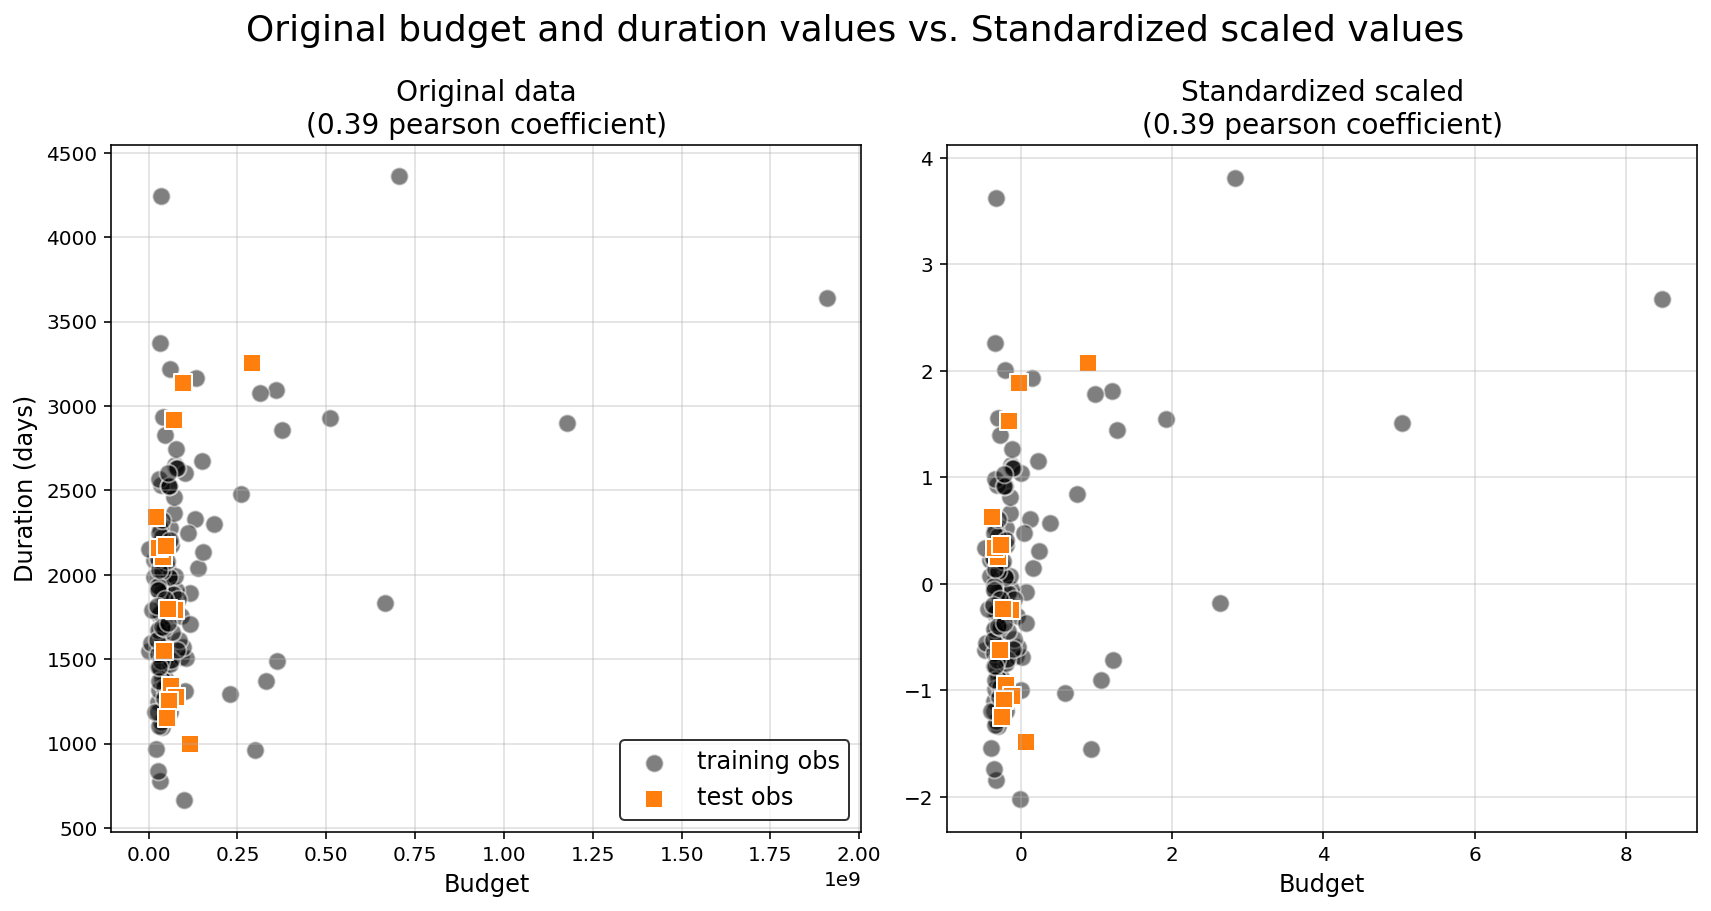

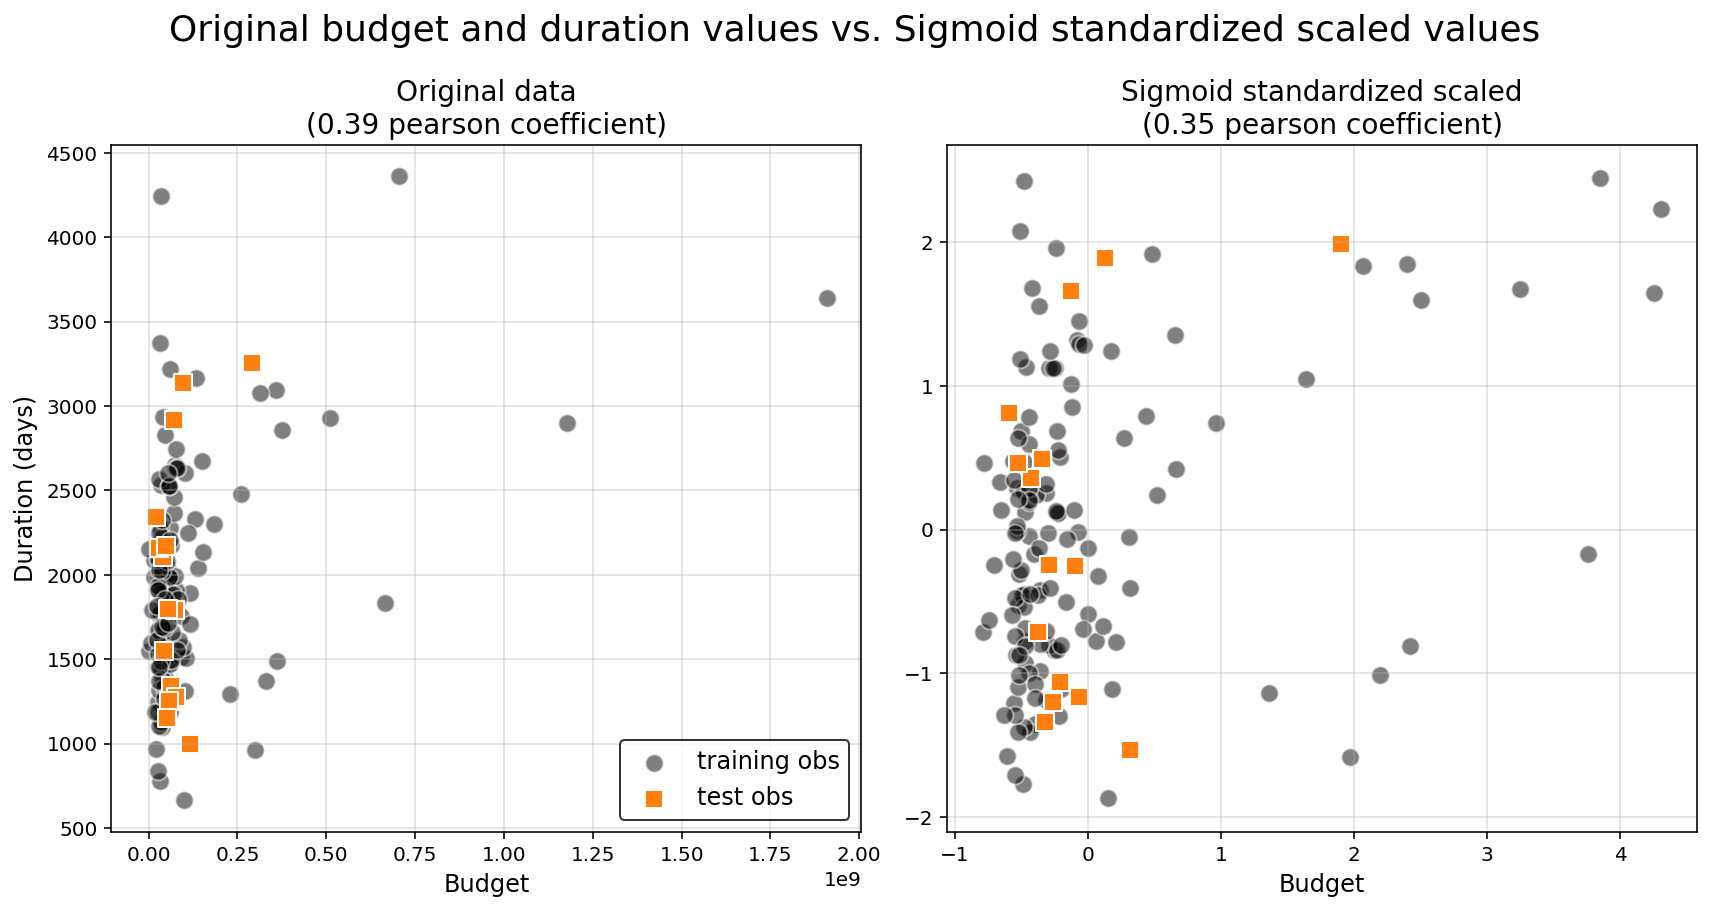

In [53]:
# inspect scaled datasets
plot_bdgt_sched_scaled(X_train, X_train_std, 'Standardized', X_test, X_test_std)
plot_bdgt_sched_scaled(X_train, X_train_std_sig, 'Sigmoid standardized', X_test, X_test_std_sig)

**FINDINGS**:

By visualizing our `Budget_Start` and `Duration_Start` predictors above, we can see a large skew with clear outliers in the original unscaled data. By applying standardization to the these predictors, as we have illustrated in the upper righthand plot, we have set both variables to the same scale. However, standardizing has not alleviated the skewness of our data or helped with our outlying datapoints. 

Therefore, we have also applied a sigmoid transformation to the data and re-standardized, as is shown in the lower righthand plot. This sigmoid transformation has helped to alleviate the skew of our data, and it has also helped to more evenly distrubute all of our data points, drawing outliers far closer to the center of the distribution.

**Now we will fit a "Baseline" linear regression model on our scaled datasets to see which performs best.**

<a name='baseline'></a>

## 4.1 Baseline Linear Regression

<a href=#linear>Return to section index</a>

**The unabridged notebook used to generate the findings in this section can be [found here on GitHub.](https://github.com/mcdomx/cs109b_groupproject/blob/master/notebooks/05_baseline_linear_models.ipynb)**

### Fit "Baseline" linear regression model using only `Budget_Start` and `Duration_Start` predictors

In [54]:
features = [
    'Budget_Start',
    'Duration_Start'
]

print(
    '\nThese 2 "BASELINE" models used the following predictors:\n\n\t{}\n\n'\
    ''.format(features)
)


sm_formulas = [
    ' + '.join(features),
    ' + '.join(features)
]

model_descr = 'Baseline linear regression, standardized data, 2 predictors'

model_LR2 = generate_model_dict(
    sm.ols,
    model_descr,
    X_train_std[features], X_test_std[features], y_train, y_test,
    multioutput=True,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='statsmodels',
    sm_formulas=sm_formulas,
)

print_model_results(model_LR2)

model_descr = 'Baseline linear regression, sigmoid standarized data, 2 predictors'

model_LR2_sig = generate_model_dict(
    sm.ols,
    model_descr,
    X_train_std_sig[features], X_test_std_sig[features], y_train, y_test,
    multioutput=True,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='statsmodels',
    sm_formulas=sm_formulas,
)


print_model_results(model_LR2_sig)


These 2 "BASELINE" models used the following predictors:

	['Budget_Start', 'Duration_Start']



MODEL SUMMARY:
Baseline linear regression, standardized data, 2 predictors


The fitted model object(s):




The formula for each fitted model object:

	Budget_Change_Ratio ~ Budget_Start + Duration_Start

	Schedule_Change_Ratio ~ Budget_Start + Duration_Start


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.0046
		Test		-0.4248

	Schedule_Change_Ratio

		Training	0.2260
		Test		0.2391




MODEL SUMMARY:
Baseline linear regression, sigmoid standarized data, 2 predictors


The fitted model object(s):




The formula for each fitted model object:

	Budget_Change_Ratio ~ Budget_Start + Duration_Start

	Schedule_Change_Ratio ~ Budget_Start + Duration_Start


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.0116
		Test		-0.3509

	Schedule_Change_Ratio

		Training	0.2332
		Test		0.2697





**FINDINGS:**

By using sigmoid scaled data for both our `Budget_Start` and `Schedule_Start` predictors, we can see that by reducing skew in our predictors, we have generated slightly better performance in predicting both `Budget_Change_Ratio` and `Schedule_Change_Ratio` in both our train and test sets.

While these are just true Baseline models in which we use Linear Regression with only 2 predictors, the results indicate that:

1. we may benefit from the use of sigmoid scaled data for those two baseline predictors


2. `Budget_Change_Ratio` may prove more difficult to predict than `Schedule_Change_Ratio`, wherein our predictions for `Budget_Change_Ratio` perform less well than a naive model as is indicated by the negative $R^2$ score for the test data.

### Fit "Baseline+" regression model, incorporating project `Category` as a predictor

In [55]:
features = list(X_train)[:-10]

print(
    '\nThis "BASELINE+" model uses the project Category '\
    'as one-hot-encoded predictors:'\
    '\n\n\t{}\n\n'.format(features)
)


sm_formulas = [
    ' + '.join(features),
    ' + '.join(features)
]

model_descr = 'Baseline linear regression, sigmoid standarized data, with categories'

model_LR3 = generate_model_dict(
    sm.ols,
    model_descr,
    X_train_std_sig[features], X_test_std_sig[features], y_train, y_test,
    multioutput=True,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='statsmodels',
    sm_formulas=sm_formulas,
)


print_model_results(model_LR3)


This "BASELINE+" model uses the project Category as one-hot-encoded predictors:

	['Budget_Start', 'Duration_Start', 'Bridges', 'Ferries', 'Industrial_Development', 'Parks', 'Sanitation', 'Schools', 'Sewers', 'Streets_and_Roadways', 'Wastewater_Treatment', 'Water_Supply']



MODEL SUMMARY:
Baseline linear regression, sigmoid standarized data, with categories


The fitted model object(s):




The formula for each fitted model object:

	Budget_Change_Ratio ~ Budget_Start + Duration_Start + Bridges + Ferries + Industrial_Development + Parks + Sanitation + Schools + Sewers + Streets_and_Roadways + Wastewater_Treatment + Water_Supply

	Schedule_Change_Ratio ~ Budget_Start + Duration_Start + Bridges + Ferries + Industrial_Development + Parks + Sanitation + Schools + Sewers + Streets_and_Roadways + Wastewater_Treatment + Water_Supply


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.0686
		Test		-2.5340

	Schedule_Change_Ratio

		Training	0.4523
		T

**FINDINGS:**

By adding the one-hot-encoded `Category` feature to our model, which provides information about the type of project for each observation, we can see a clear improvement in our `Schedule_Change_Ratio` $R^2$ scores for both train and test predictions. 

Our `Budget_Change_Ratio` results on the otherhand have degraded in performance when compared to our simpler **Baseline** model with just 2 predictors. Regardless, neither the **Baseline** nor **Baseline+** linear regression models are able to predict 3-year `Budget_Change_Ratio` results better than the naive model, as is indicated by these $R^2$ results.

This indicates to us that we will likely have more difficulty in predicting `Budget_Change_Ratio` in our future models and that a Linear Regression model likely lacks the expressiveness required to adequately fit a model to the underlying relationship between predictors and outcome variable.

As on last step before moving on from Linear Regression, we will quickly inspect the predictions made by our **Baseline+** model, as well as the regression coefficients.


## Visualize Baseline+ predictions and coefficients

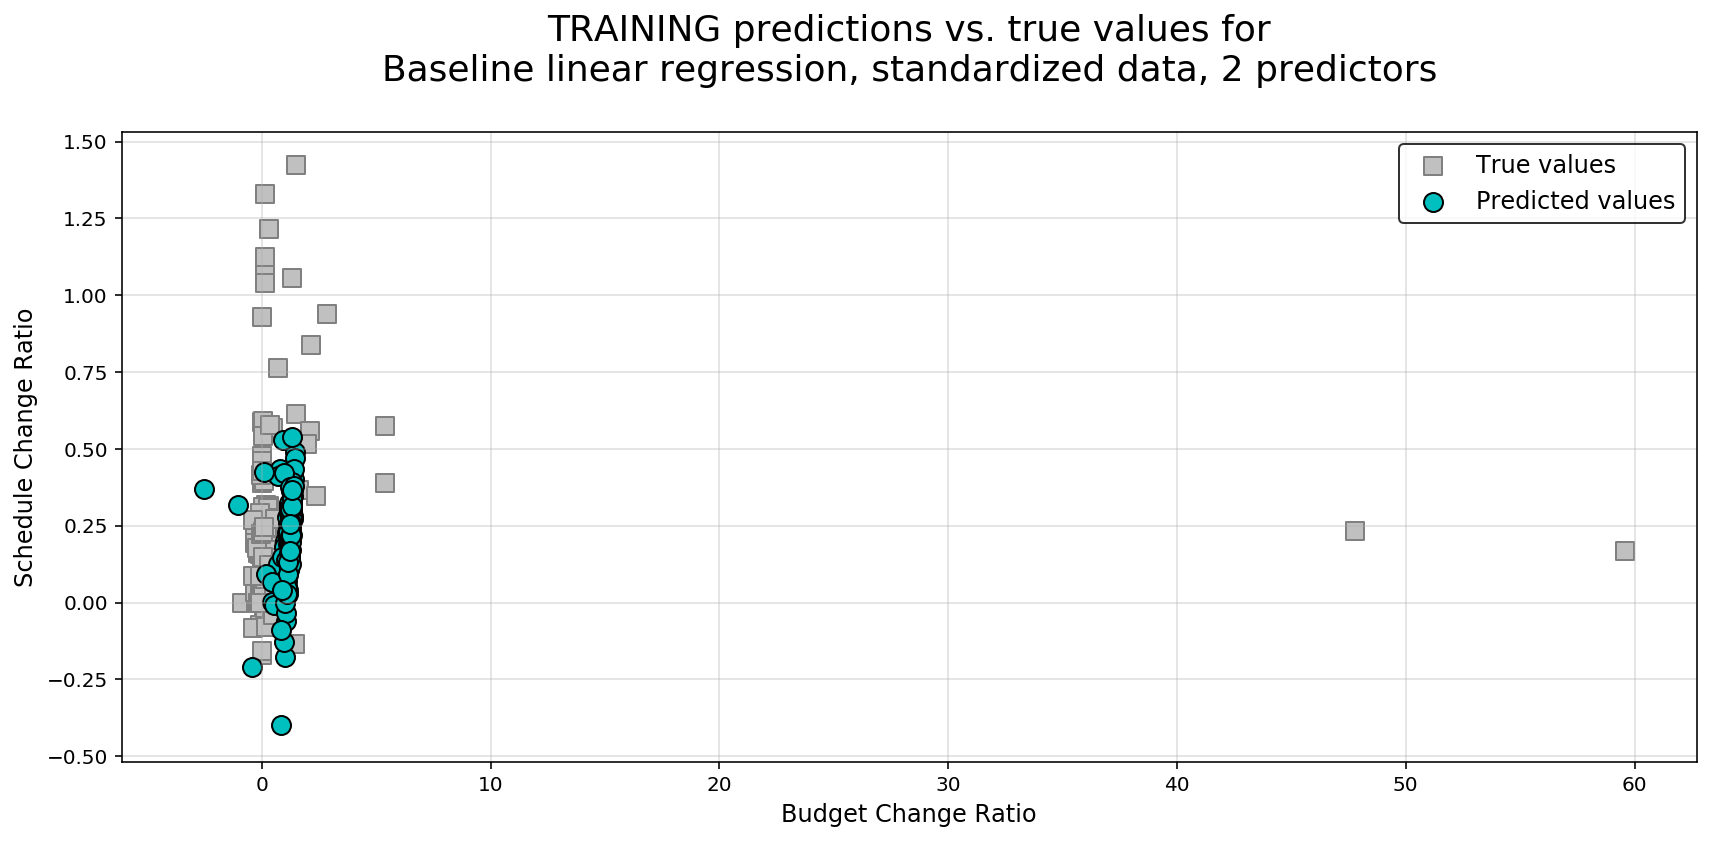

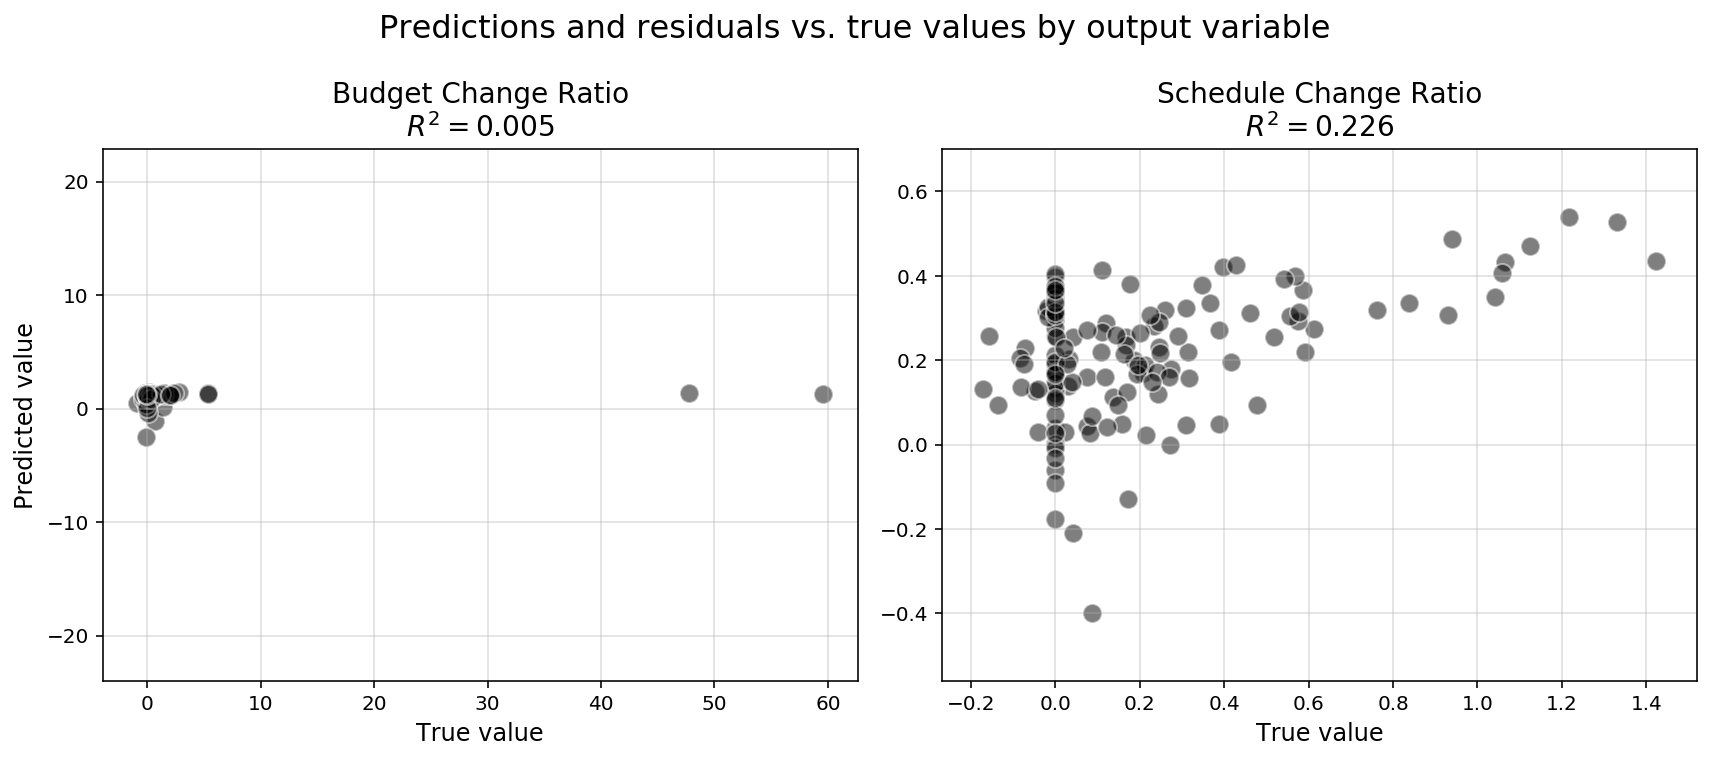

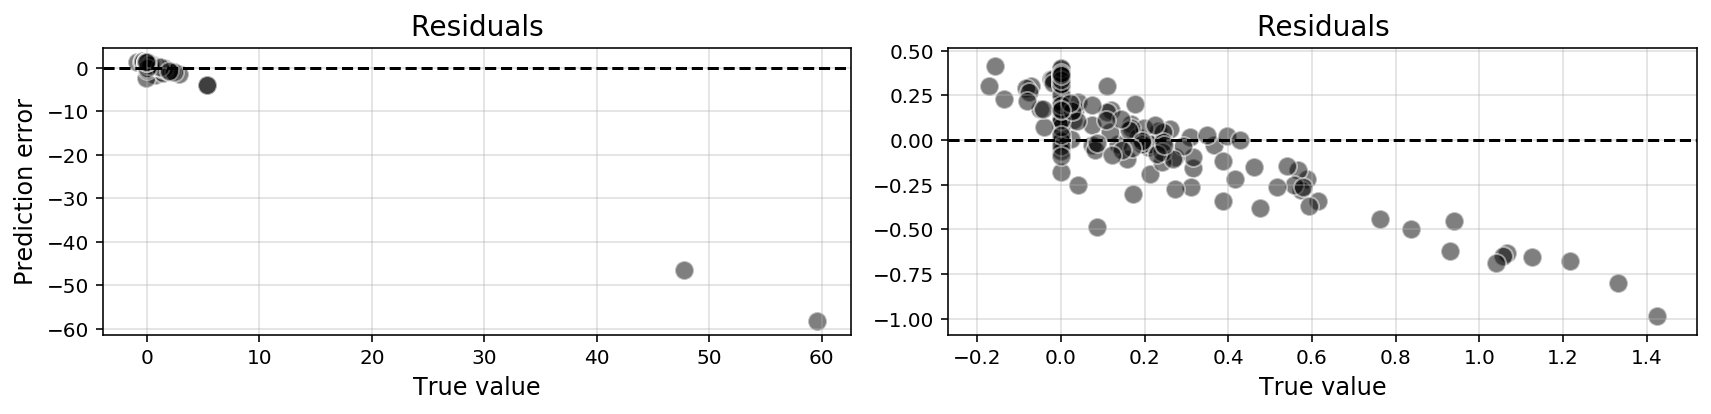

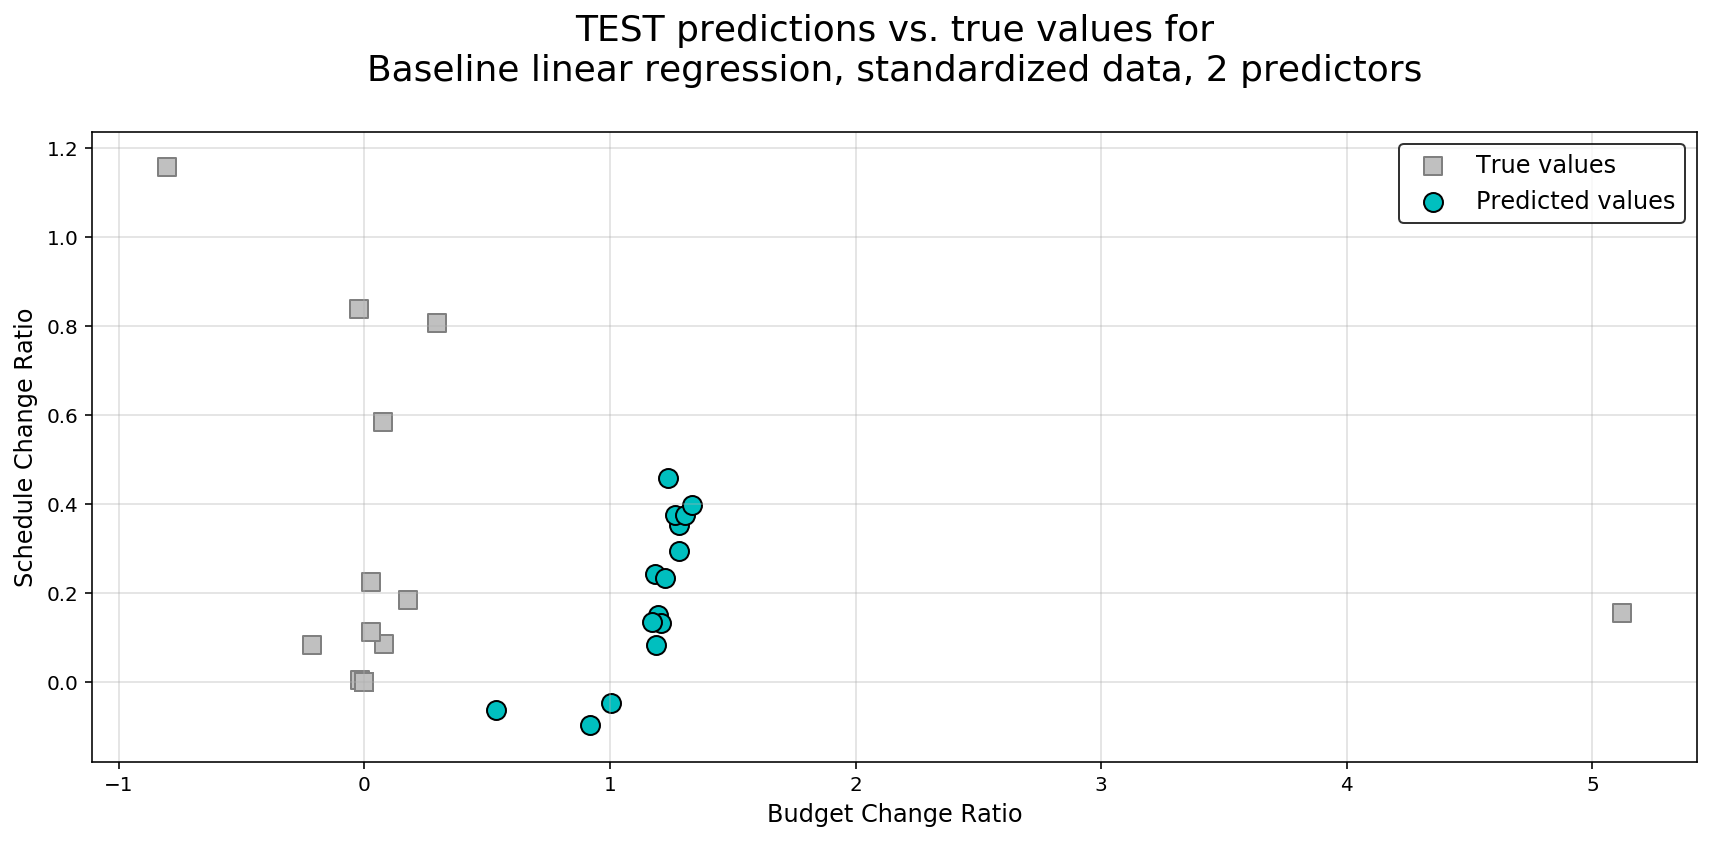

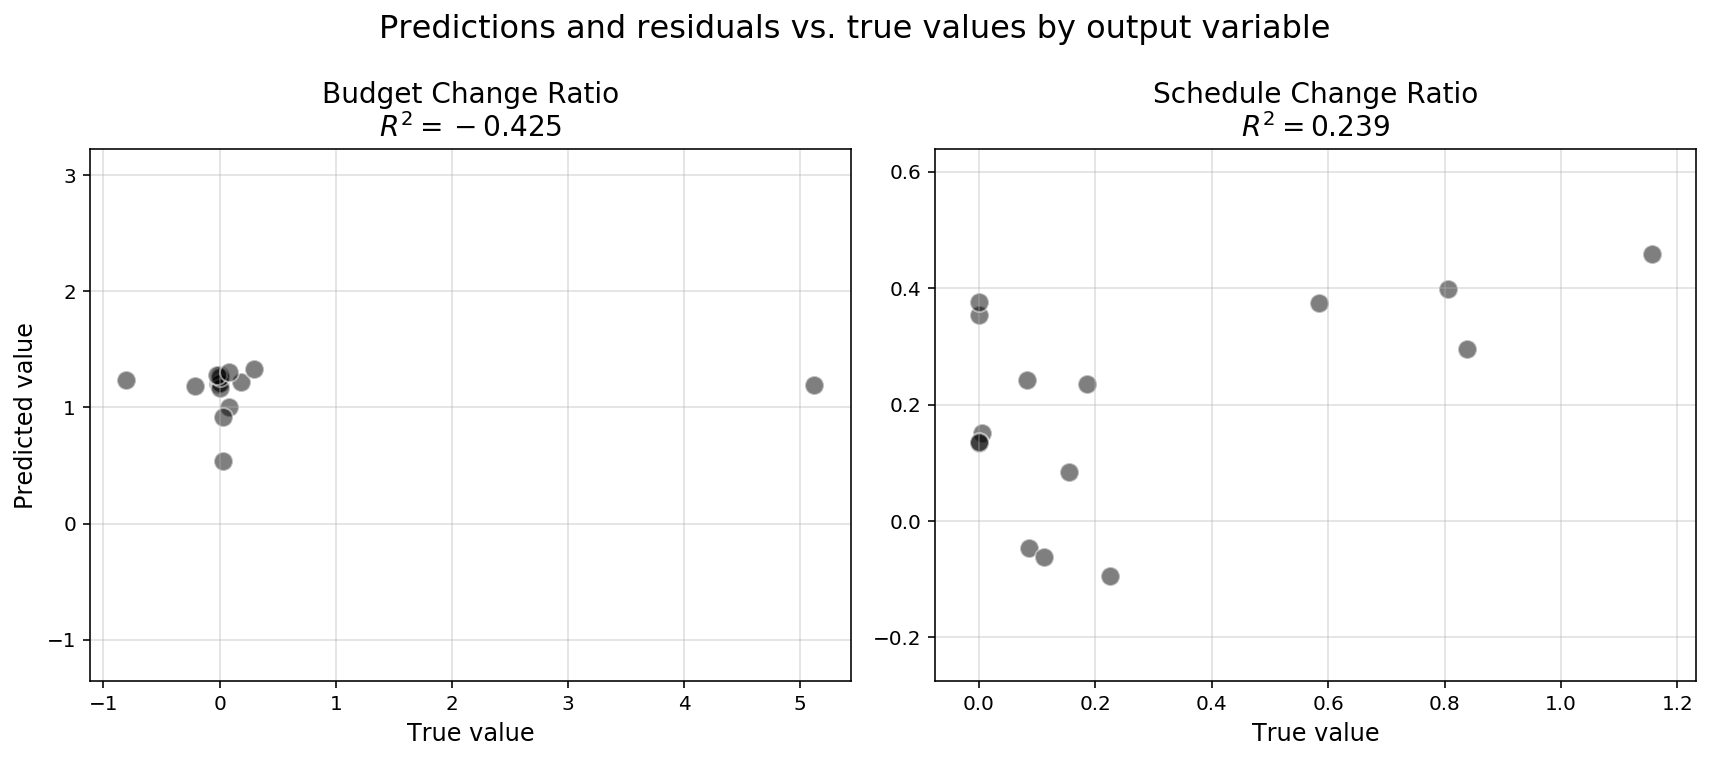

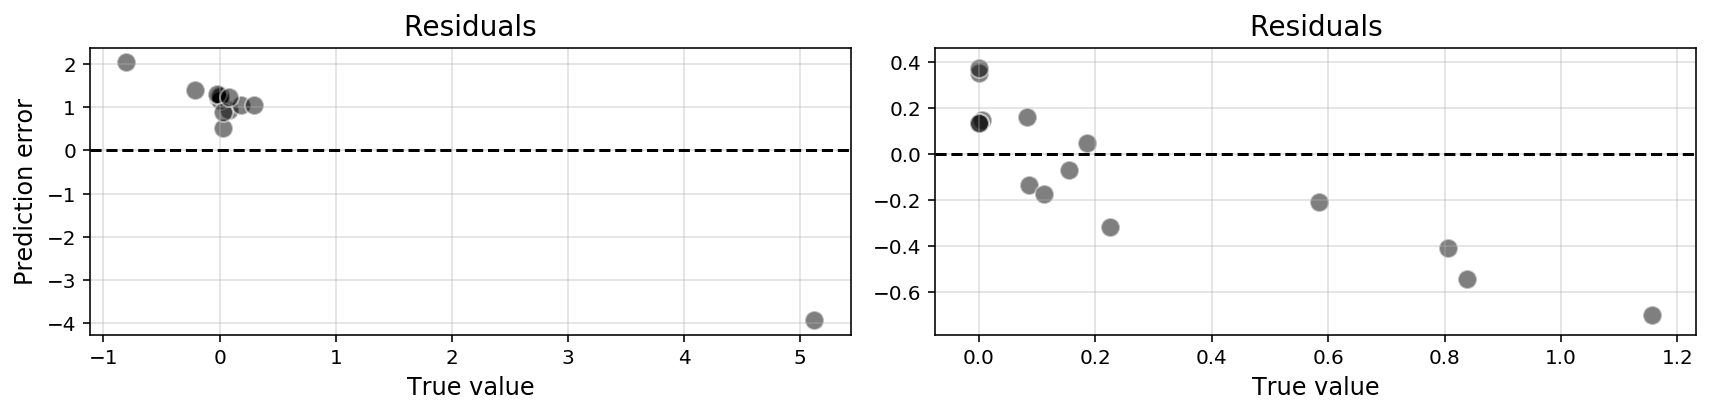

In [56]:
plot_true_pred(model_dict=model_LR2, dataset='train')
plot_true_pred(model_dict=model_LR2, dataset='test')

**ADD PLOT OF COEFFICIENTS & INTERPRETATION**

<a name='splines'></a>

## 4.2 Smoothing Spline Generalized Additive Models (GAMs)

<a href=#linear>Return to section index</a>

**IN THIS SECTION:**

**4.2.1. <a href=#spline1>Smoothing Spline GAMs with Baseline Predictors</a>**

**4.2.2. <a href=#spline2>Smoothing Spline GAMs with Engineered Features</a>**

<a name='spline1'></a>

## 4.2.1. Smoothing Spline GAMs with Baseline Predictors

<a href=#splines>Return to section index</a>

**The unabridged notebook used to generate the findings in this section can be [found here on GitHub.](https://github.com/mcdomx/cs109b_groupproject/blob/master/notebooks/06_smoothing_spline_models.ipynb)**

In [57]:
features = [
    'Budget_Start',
    'Duration_Start',
    'Category_Code',
]

print(
    '\nThis smoothing spline GAM uses the same predictors as our '\
    '"BASELINE+" regression model,\nexcept Category is label-encoded '\
    'instead of one-hot-encoded:'\
    '\n\n\t{}\n\n'.format(features)
)


model_descr = 'Smoothing spline GAM, sigmoid standarized data, with categories'

terms = s(0) + s(1) + f(2)

model_GAM0 = generate_model_dict(
    LinearGAM,
    model_descr,
    X_train_std_sig[features], X_test_std_sig[features], y_train, y_test,
    multioutput=False,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='sklearn',
    terms=terms,
)


print_model_results(model_GAM0)


This smoothing spline GAM uses the same predictors as our "BASELINE+" regression model,
except Category is label-encoded instead of one-hot-encoded:

	['Budget_Start', 'Duration_Start', 'Category_Code']



MODEL SUMMARY:
Smoothing spline GAM, sigmoid standarized data, with categories


The fitted model object(s):

	LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

	LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.5426
		Test		-1.1546

	Schedule_Change_Ratio

		Training	0.6628
		Test		0.5840





**FINDINGS:**

Here we can see that we stand to benefit from the added expressiveness of a smoothing spline class of linear model, as is illustrated by the improved $R^2$ results shown above. However, while our `Schedule_Change_Ratio` predictions have improved from $R^2=0.34$ to $R^2=0.58$, our `Budget_Change_Ratio` test $R^2$ score is still extremely negative. However, the smoothing spline GAM does appear to have fitted the training set with a `Budget_Change_Ratio` $R^2$ score of 0.54, which is somewhat promising. Now, if only we can improve on this to find a model that generalizes when to unseen data.

### Use gridsearch to find optimal value $\lambda$ for each term in the smoothing spline GAM model

- Here we treat each y output independently, partly because PyGam's Linear GAM will not fit a multi-output model, but mostly because each y output behaves differently and we have found that different $\lambda$ values are required to optimize both output


- We also use PyGam's native `gridsearch` method to choose our values $\lambda$.
    - Because there are so few instances of some project categories, traditional cross-validation using k-splits creates instances where some train instances are missing one or two categories
    - When that occurs, PyGam cannot fit a coefficient to that category and generates an error.
    

In [58]:
terms = s(0) + s(1) + f(2)

# generate list of lambdas against which to perform gridsearch for
# each outcome variable and each of our 3 input predictors
lam_list = np.logspace(-3, 5, 10)
lams = [lam_list] * 3

# fit GAM to predict budget change ratio 
gam1 = LinearGAM(terms).fit(
    X_train_std_sig[features], y_train['Budget_Change_Ratio']
)
# perform gridsearch to find optimal lambdas for each term
gam1.gridsearch(
    X_train_std_sig[features], y_train['Budget_Change_Ratio'],
    lam=lams
)

# fit GAM to predict schedule change ratio
gam2 = LinearGAM(terms).fit(
    X_train_std_sig[features], y_train['Schedule_Change_Ratio']
)
# perform gridsearch to find optimal lambdas for each term
gam2.gridsearch(
    X_train_std_sig[features], y_train['Schedule_Change_Ratio'],
    lam=lams
)

100% (1000 of 1000) |####################| Elapsed Time: 0:00:18 Time:  0:00:18
100% (1000 of 1000) |####################| Elapsed Time: 0:00:16 Time:  0:00:16


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

In [59]:
%%capture --no-stdout

print(
    '\nGAM gridsearch results for BUDGET_CHANGE_RATIO prediction model:\n'
)
gam1.summary()

print(
    '\n\n\nGAM gridsearch results for SCHEDULE_CHANGE_RATIO prediction model:\n'
)
gam2.summary()


GAM gridsearch results for BUDGET_CHANGE_RATIO prediction model:

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     18.7569
Link Function:                     IdentityLink Log Likelihood:                                  -419.7587
Number of Samples:                          134 AIC:                                              879.0312
                                                AICc:                                             886.2739
                                                GCV:                                               11.5842
                                                Scale:                                              8.7077
                                                Pseudo R-Squared:            

**ADD INTERPRETATION**

In [60]:
print(
    '\nThese smoothing spline GAMs have been fit using the optimal lambda penalties '\
    'for each term, one set of results show models optimized for BUDGET_CHANGE_RATIO '\
    'predictions, the other for SCHEDULE_CHANGE_RATIO predictions.\n\n'\
    'The predictors used are:\n\n\t{}\n\n'.format(features)
)


model_descr = 'Smoothing spline GAM: sigmoid scaled, BUDGET_CHANGE_RATIO optimal penalties'

terms = s(0, lam=0.001) + s(1, lam=100000) + f(2, lam=215.4435)

model_GAM1 = generate_model_dict(
    LinearGAM,
    model_descr,
    X_train_std_sig[features], X_test_std_sig[features], y_train, y_test,
    multioutput=False,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='sklearn',
    terms=terms,
)

print_model_results(model_GAM1)

model_descr = 'Smoothing spline GAM: sigmoid scaled, SCHEDULE_CHANGE_RATIO optimal penalties'

terms = s(0, lam=100000) + s(1, lam=27.8256) + f(2, lam=3.5938)

model_GAM2 = generate_model_dict(
    LinearGAM,
    model_descr,
    X_train_std_sig[features], X_test_std_sig[features], y_train, y_test,
    multioutput=False,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='sklearn',
    terms=terms,
)


# generate_model_dict(
#     LinearGAM, model_descr, X_le_tr_std_sig, X_le_te_std_sig, y_train, y_test, terms=terms, multioutput=False
# )

print_model_results(model_GAM2)


These smoothing spline GAMs have been fit using the optimal lambda penalties for each term, one set of results show models optimized for BUDGET_CHANGE_RATIO predictions, the other for SCHEDULE_CHANGE_RATIO predictions.

The predictors used are:

	['Budget_Start', 'Duration_Start', 'Category_Code']



MODEL SUMMARY:
Smoothing spline GAM: sigmoid scaled, BUDGET_CHANGE_RATIO optimal penalties


The fitted model object(s):

	LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

	LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.8263
		Test		-0.8736

	Schedule_Change_Ratio

		Training	0.3532
		Test		0.0337




MODEL SUMMARY:
Smoothing spline GAM: sigmoid scaled, SCHEDULE_CHANGE_RAT

**ADD INTERPRETATION**

### Visualize optimized baseline smoothing spline GAM predictions and contribution by predictor

In [61]:
y_pred_train = np.hstack(
    [
        model_GAM1['predictions']['train'][:, 0].reshape(-1,1),
        model_GAM2['predictions']['train'][:, 1].reshape(-1,1)
    ]
)

y_pred_test = np.hstack(
    [
        model_GAM1['predictions']['test'][:, 0].reshape(-1,1),
        model_GAM2['predictions']['test'][:, 1].reshape(-1,1)
    ]
)

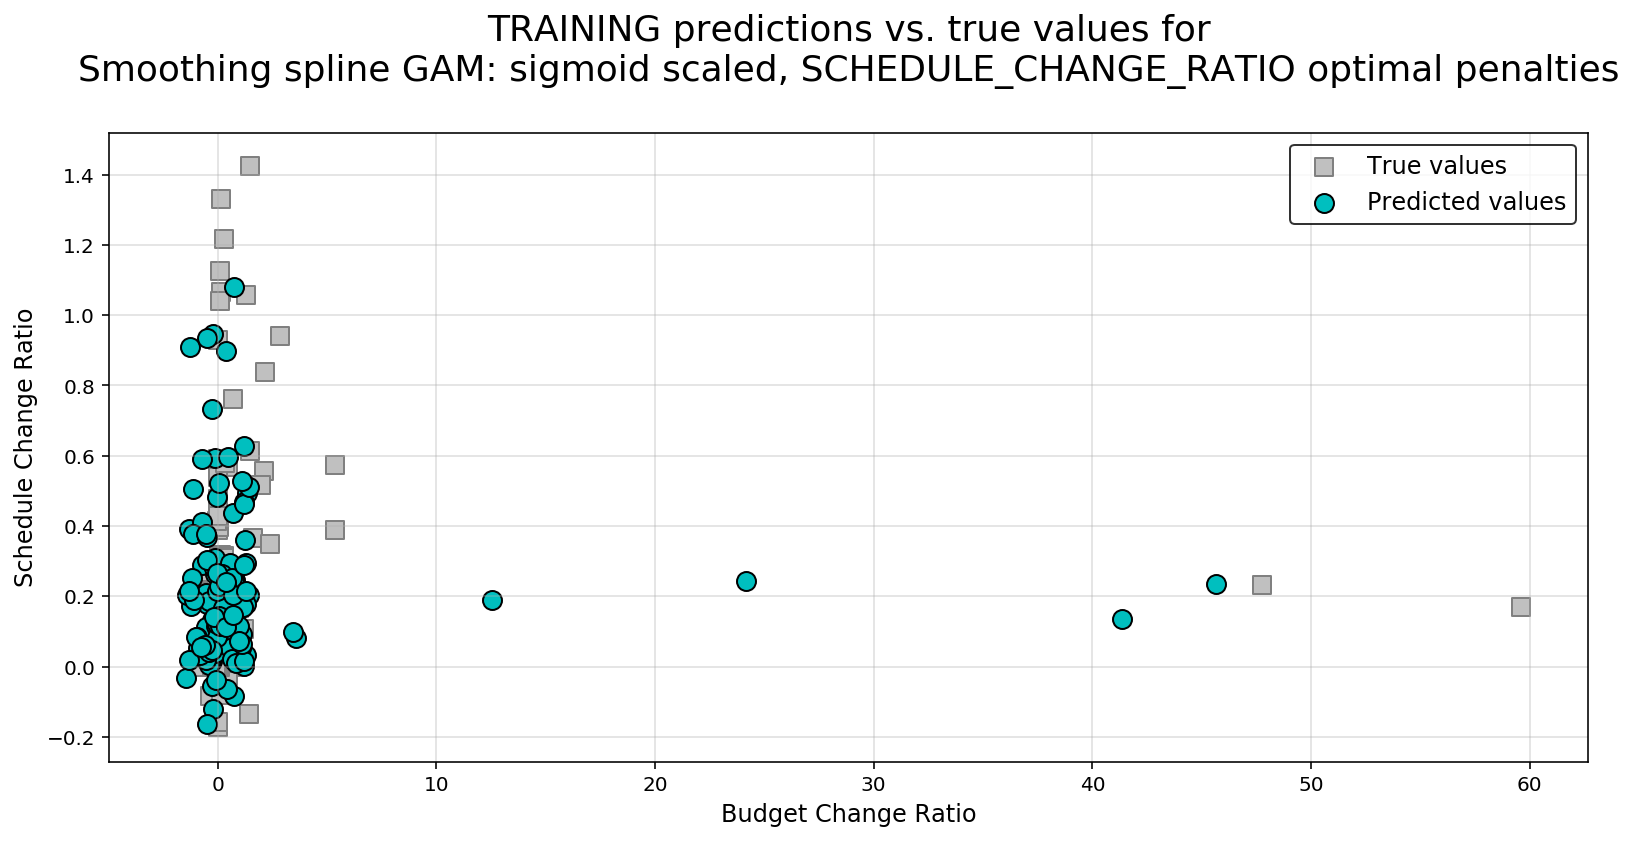

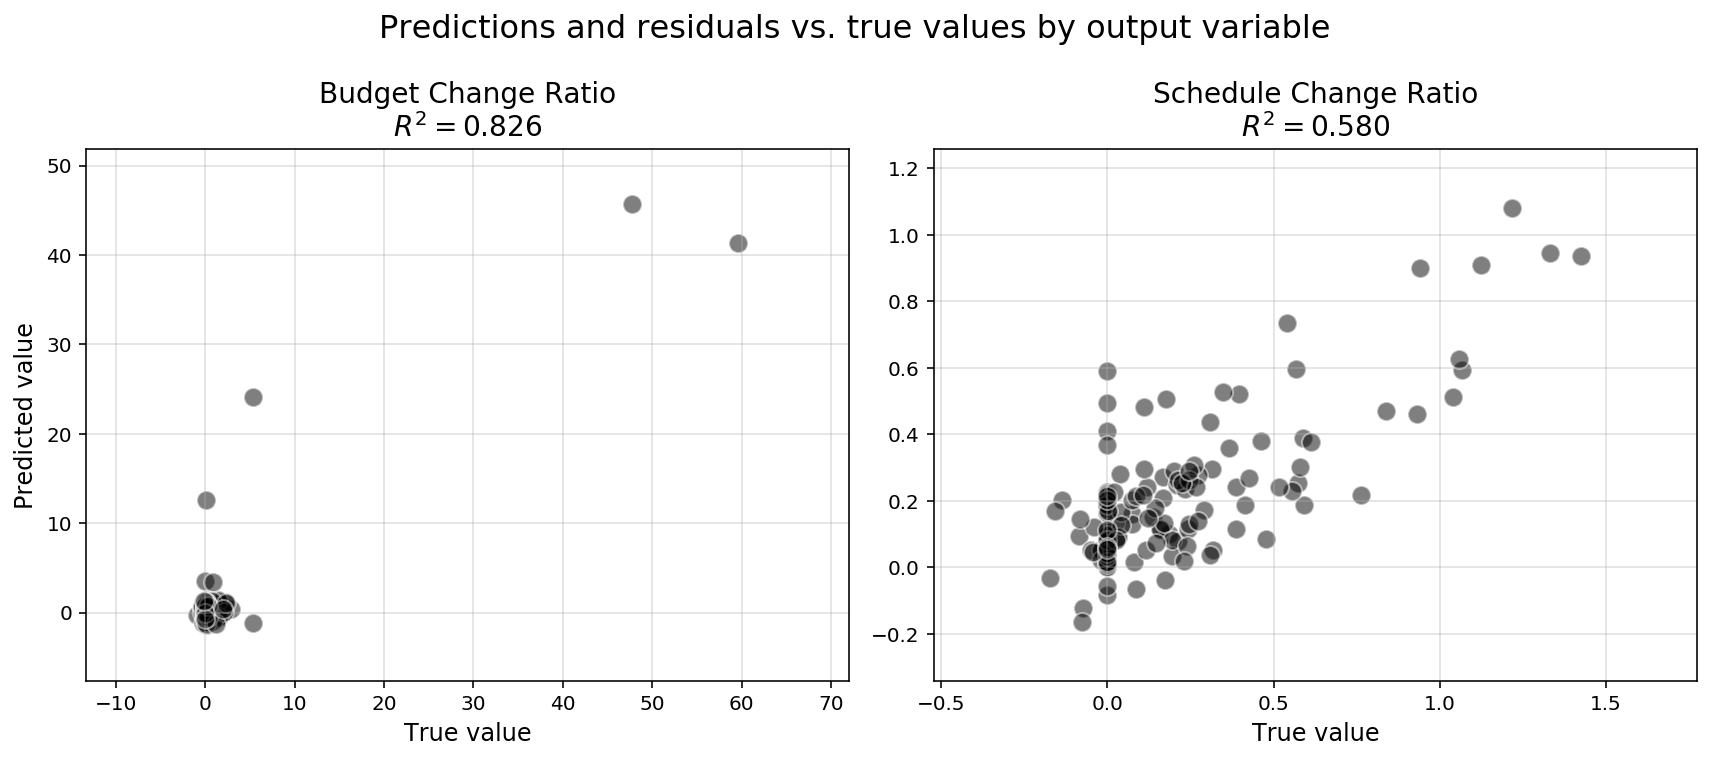

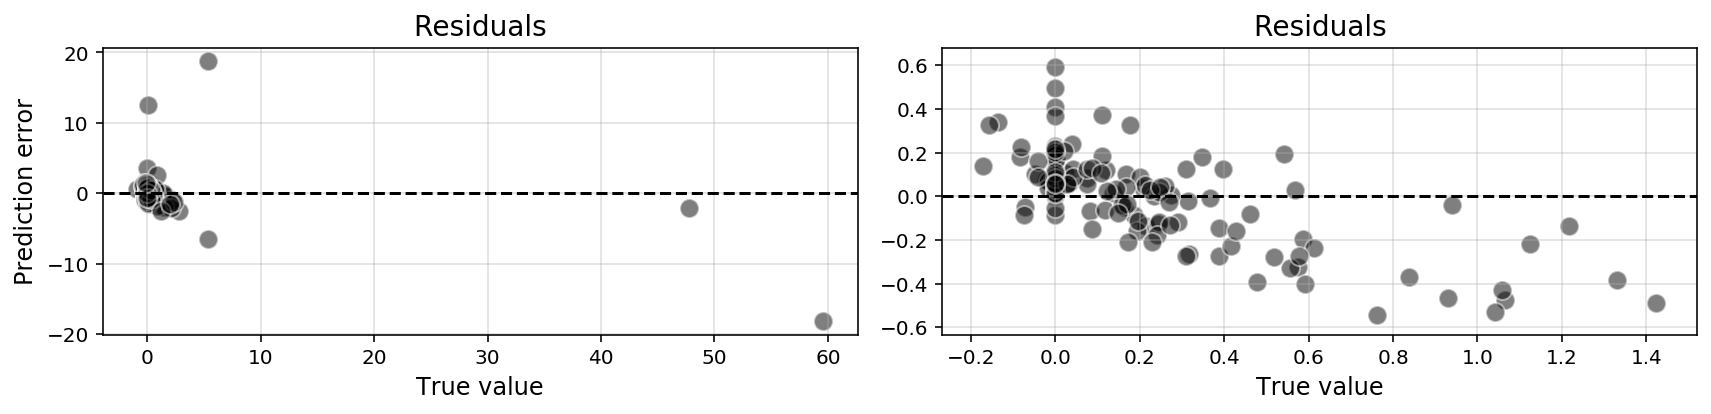

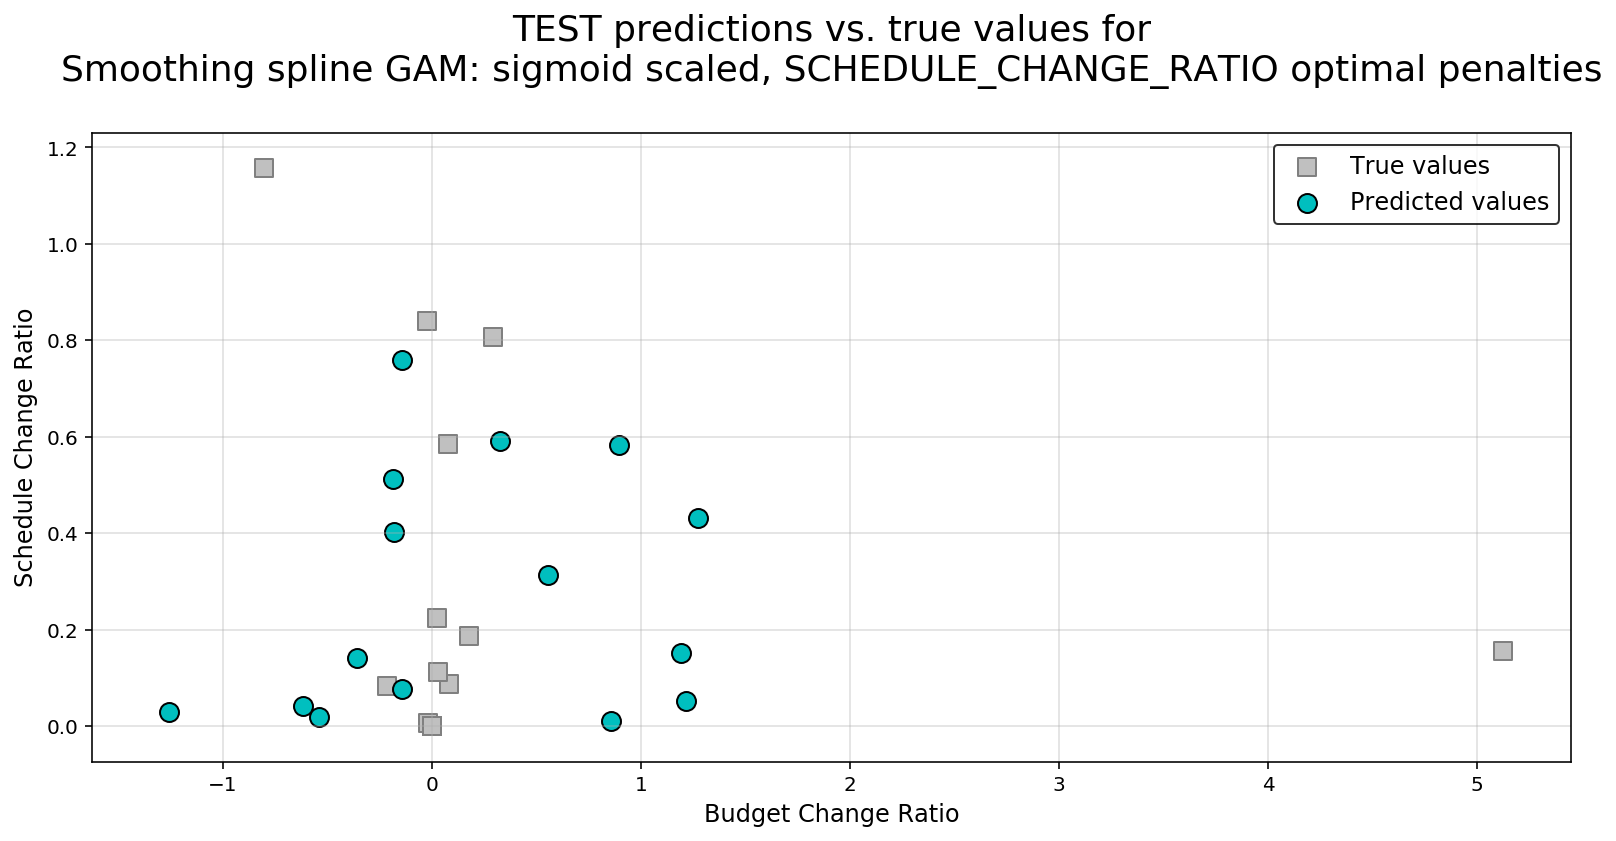

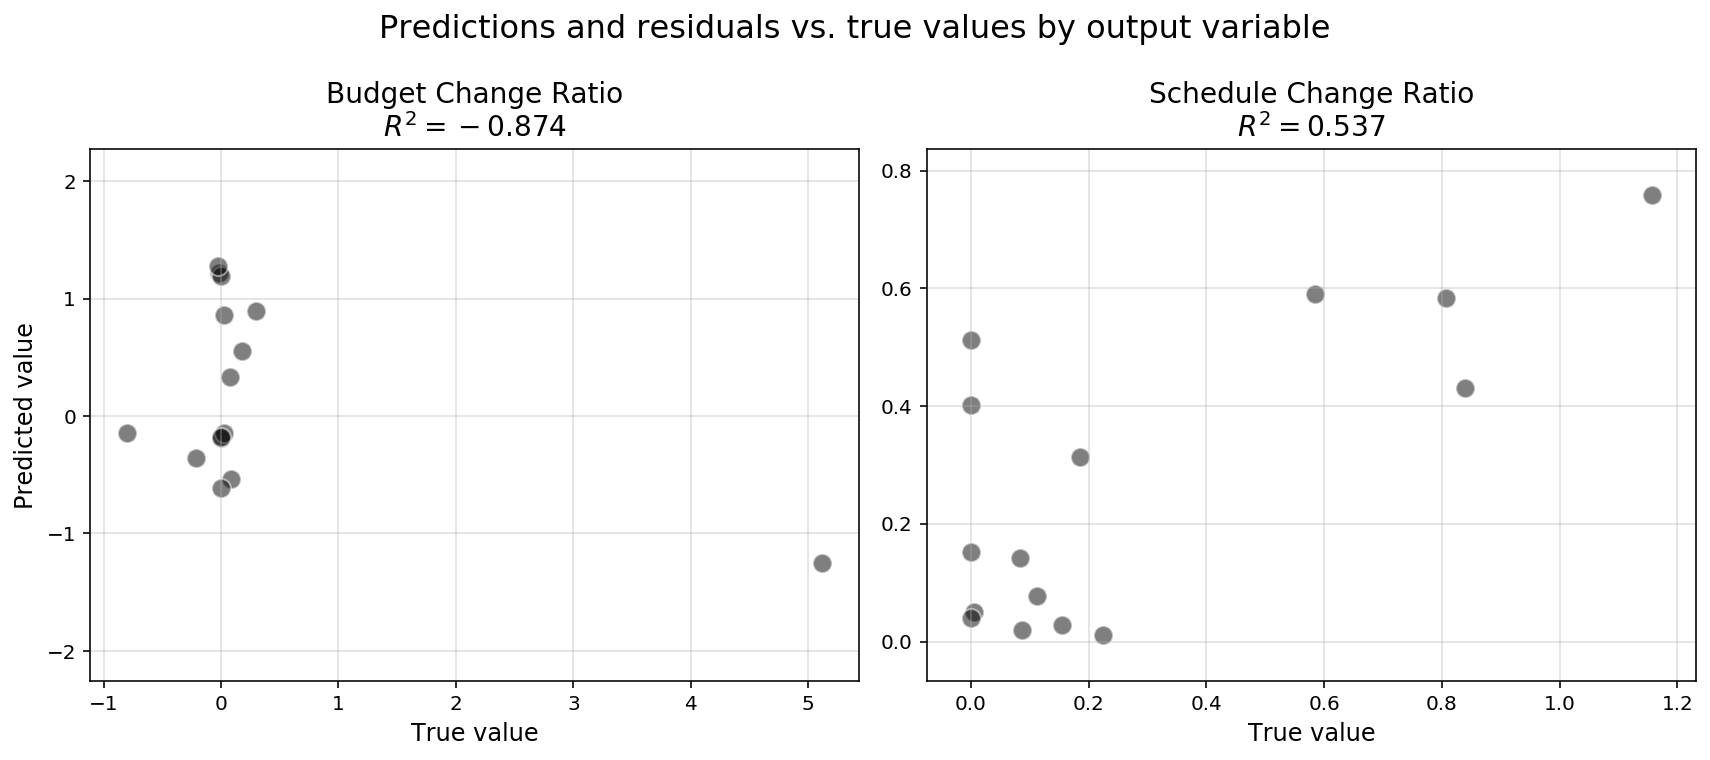

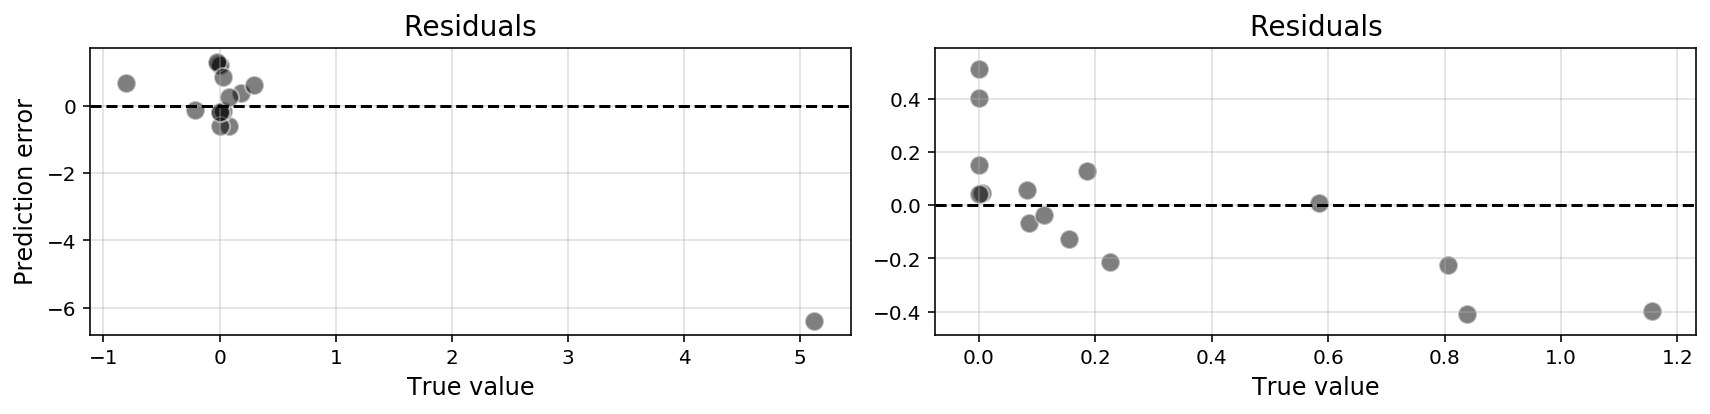

In [62]:
Conclusionsmodel_descr = "Smoothing spline GAM: standardized sigmoid scale data and optimized $\lambda$'s"
y1_label = 'Budget Change Ratio'
y2_label = 'Schedule Change Ratio'

plot_true_pred(
    dataset='train',
    y_true=y_train,
    y_pred=y_pred_train,
    y1_label=y1_label,
    y2_label=y2_label,
    model_descr=model_descr
)
plot_true_pred(
    dataset='test',
    y_true=y_test,
    y_pred=y_pred_test,
    y1_label=y1_label,
    y2_label=y2_label,
    model_descr=model_descr
)

**ADD INTERPRETATION**

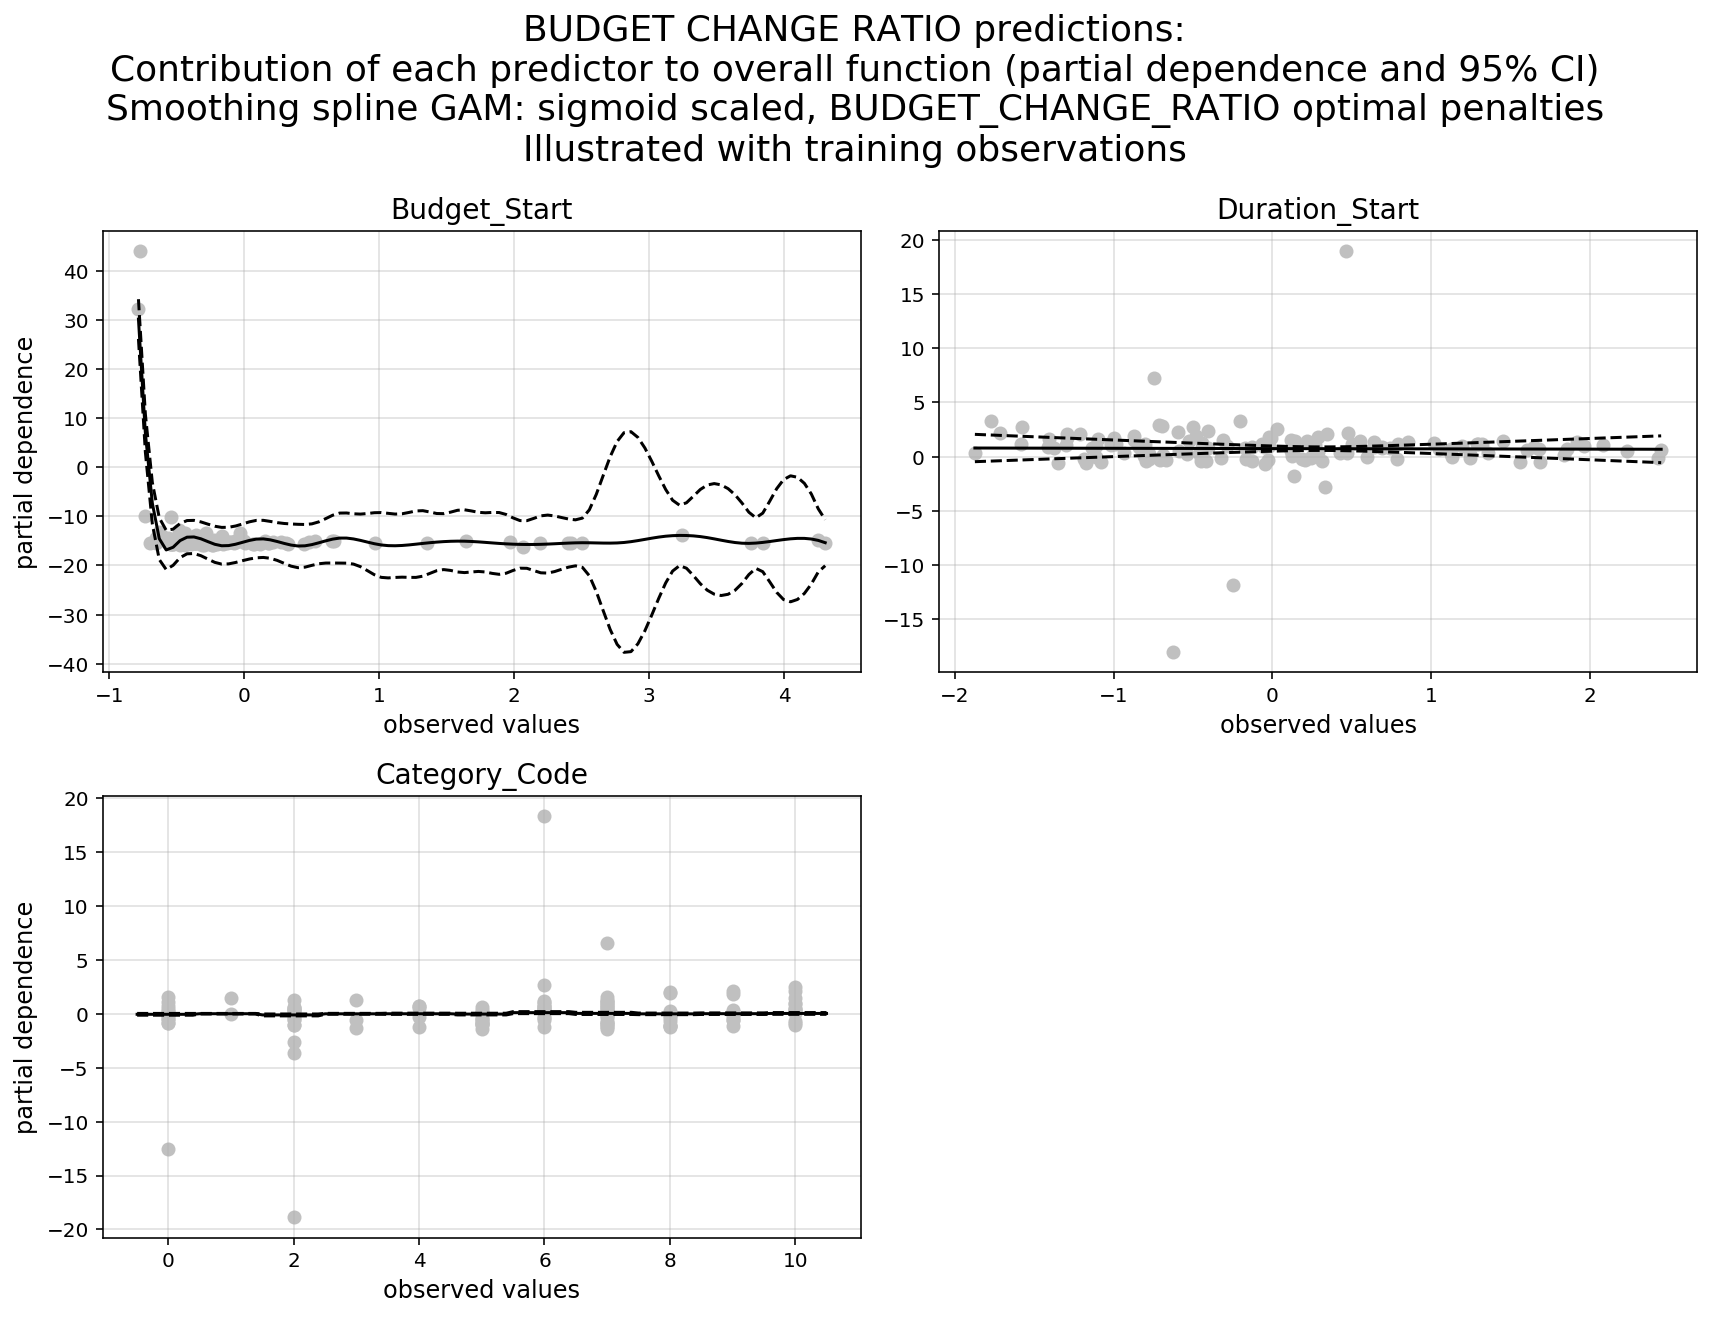

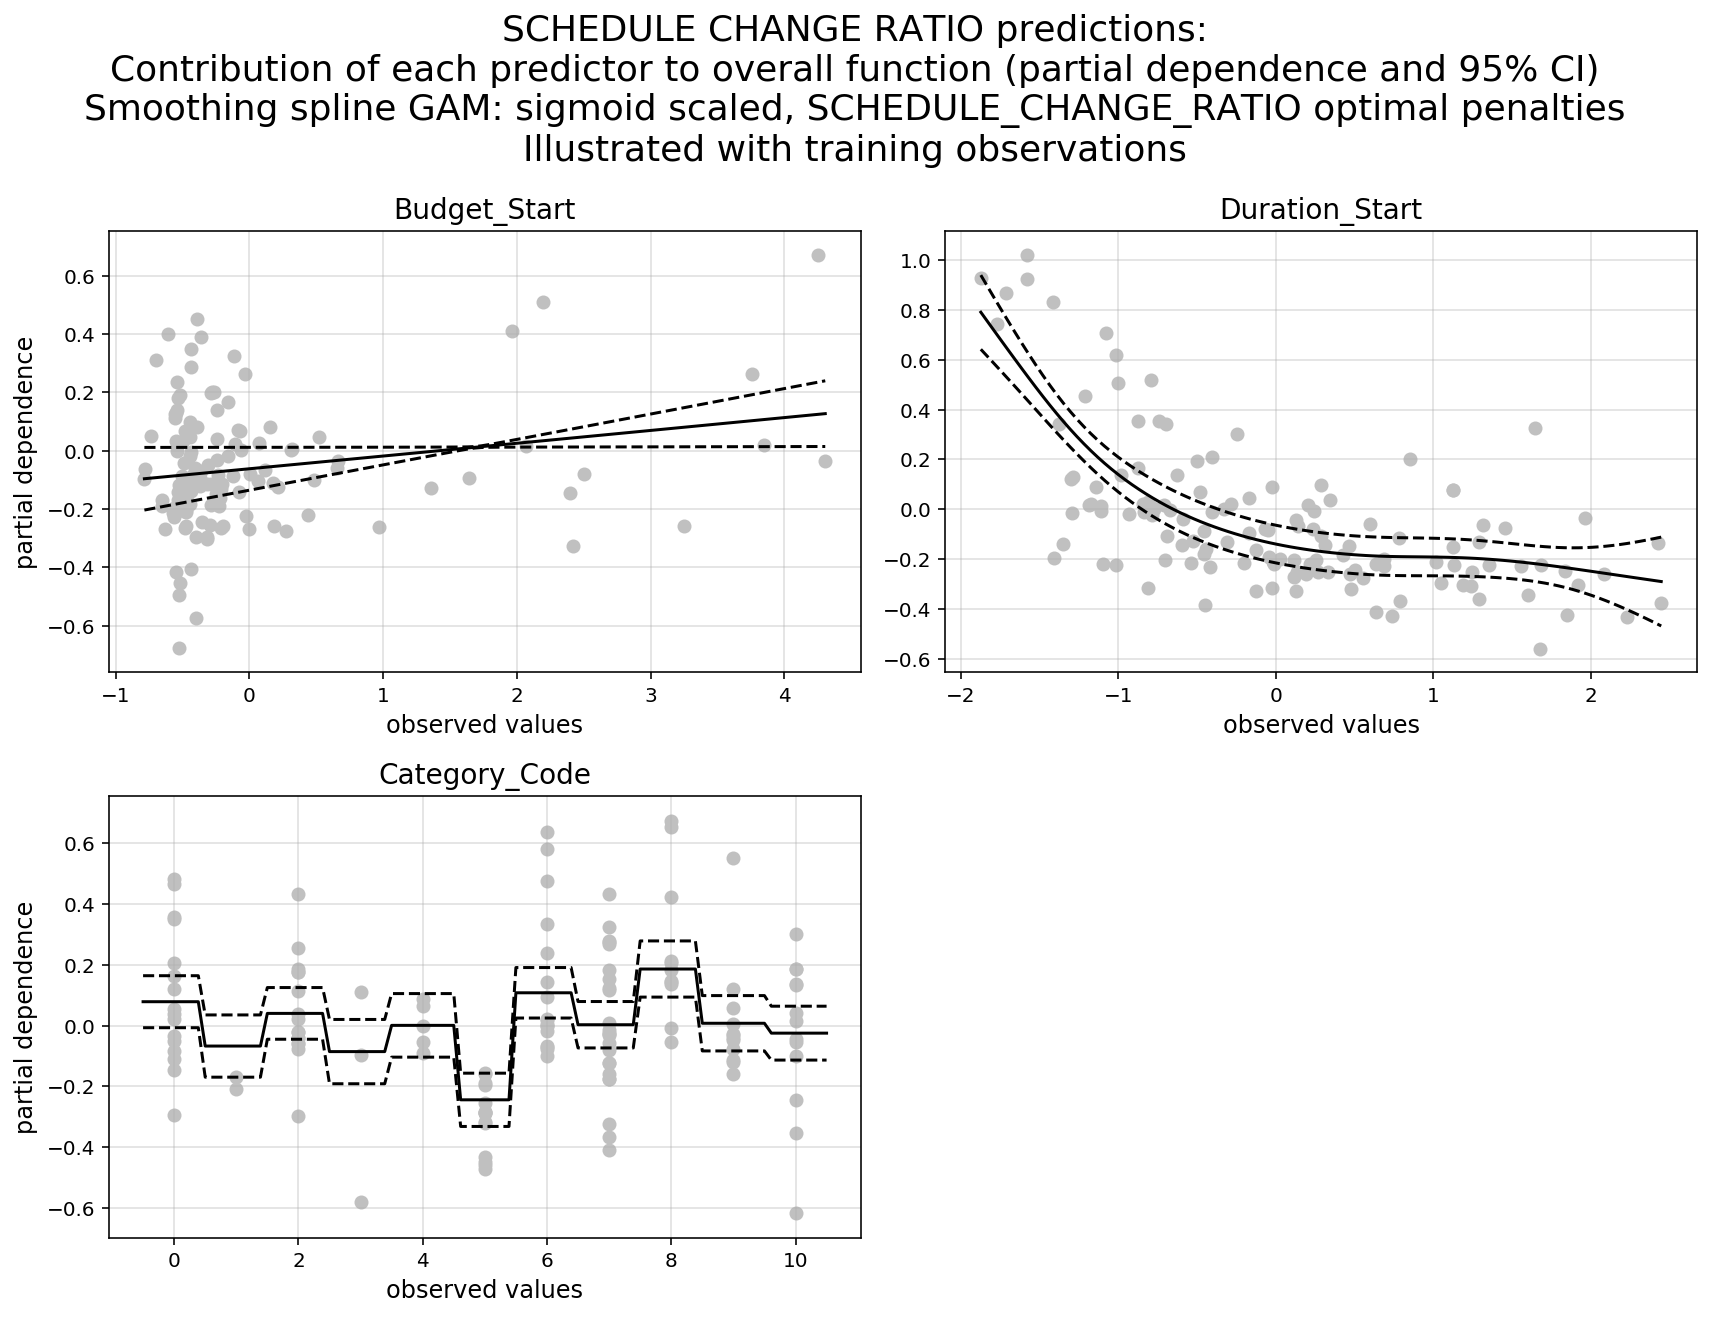

In [63]:
plot_gam_by_predictor(
    model_dict=model_GAM1, model_index=0,
    X_data=X_train_std_sig[features], y_data=y_train,
    dataset='train'
)

print()
plot_gam_by_predictor(
    model_dict=model_GAM2, model_index=1,
    X_data=X_train_std_sig[features], y_data=y_train,
    dataset='train'
)

**ADD INTERPRETATION & CONCLUSIONS**

<a name='spline2'></a>

## 4.2.2. Smoothing Spline GAMs with Engineered Features

<a href=#splines>Return to section index</a>

**The unabridged notebook used to generate the findings in this section can be [found here on GitHub.](https://github.com/mcdomx/cs109b_groupproject/blob/master/notebooks/06_smoothing_spline_models.ipynb)**

<a name='nonparam'></a>

# 5. Nonparametric Models 

<a href=#index>Index</a>

**IN THIS SECTION:**

**5.1. <a href=#trees>Decision tree regressors</a>**

**5.2. <a href=#boost>Ensemble tree regressors with boosting</a>**


In this section, we explore the use of tree models on the dataset.  Intuitively, trees were chosen as a possible solution as several data points are cateogrical in nature.  Additionally, many of the embeddings we explored clustered reasoably well leading us to believe that the nature of a nonparametric model may have a useful application.

We briefly explored using using a Classification tree in order to create a baseline for Regressors.  We found success when simply predicting whether or not a project would be over/under budget and schedule prompting us to progress with Regressors and later Boosting.

The details of the Classification trees are not included here as they only contriuted towards validation of the nonparametric approach.

<a name='trees'></a>

## 5.1. Decision Tree Regressors

<a href=#nonparam>Return to section index</a>

**The unabridged notebook used to generate the findings in this section can be [found here on GitHub.](https://github.com/mcdomx/cs109b_groupproject/blob/master/notebooks/07_decision_tree_models.ipynb)**

In [82]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score

from sklearn import tree
import graphviz

import warnings
warnings.filterwarnings('ignore')

The primary goal of this section is to find the optimal set of attributes to predict 'Budget_Change_Ratio' and 'Schedule_Change_Ratio'.  Remaining consistent with other models in this effort, we only attempt to find the best models predicting these ratios and do not consider other response variables.

### DataSet
As with the other models in this project, the models in this section will be using response variables that are project values after a 3-year period.  

### Scaling
As these models are non-parametric, the necessity to scale is not strong and therefore the values used as predictors remain unscaled and in their raw format.

### Attributes
This notebook considers 'Category', 'Budget_Start', 'Duration_Start' as well as embeddings for the all project attributes and the embeddings for the project description.  After expending the cateogries into one-hot encoded variables and using the 2 dimensions for each possible embedding, as well as each of the 2 response variables, a possine XXXXXXX 150 XXXXXXX model variations are considered.  

### MultiOutput
As has been determined throughout this project, multioutput models that consider both the 'Budget' and 'Schedule' as predicted values are not considered.  Our work has determined that models that perform well predicting one response variable do not perform well on the other.  Therefore, we assume that the optimal models will be different for each response variable.



### The following cell contains the support functions used to train and evaluate the tree models in this section.

In [76]:
# Calculate train and test scores for model inputs and outputs

depths = list(range(1, 21))
cv = 5

def calc_meanstd_logistic(X_tr, y_tr, X_te, y_te, depths:list=depths, cv:int=cv):
    
    # your code here
    cvmeans = []
    cvstds = []
    train_scores = []
    test_scores = []
    models = []
    
    for d in depths:
        model = DecisionTreeClassifier(max_depth=d, random_state=109)
        model.fit(X_tr, y_tr) # train model
        
        # cross validation
        cvmeans.append(np.mean(cross_val_score(model, X_tr, y_tr, cv=cv, scoring='accuracy' )))
        cvstds.append( np.std (cross_val_score(model, X_te, y_te, cv=cv, scoring='accuracy' )))

        models.append(model)
        
        # use AUC scoring
        train_scores.append( roc_auc_score(y_tr, model.predict(X_tr)))
        test_scores.append(  roc_auc_score(y_te, model.predict(X_te)))
 
    # make the lists np.arrays
    cvmeans = np.array(cvmeans)
    cvstds = np.array(cvstds)
    train_scores = np.array(train_scores)
    test_scores = np.array(test_scores)
    
    return cvmeans, cvstds, train_scores, test_scores, models

def calc_meanstd_regression(X_tr, y_tr, X_te, y_te, depths:list=depths, cv:int=cv):
    # your code here
    cvmeans = []
    cvstds = []
    train_scores = []
    test_scores = []
    models = []
    
    for d in depths:
        model = DecisionTreeRegressor(max_depth=d, random_state=109)
        model.fit(X_tr, y_tr) # train model
        
        # cross validation
        cvmeans.append(np.mean(cross_val_score(model, X_tr, y_tr, cv=cv, scoring='r2')))
        cvstds.append( np.std (cross_val_score(model, X_te, y_te, cv=cv, scoring='r2')))

        models.append(model)
        
        # use R2 scoring
        train_scores.append( model.score(X_tr, y_tr) )  # append train score - picks accuracy or r2 automatically
        test_scores.append(  model.score(X_te, y_te) ) # append cv test score - picks accuracy or r2 automatically
       
    # make the lists np.arrays
    cvmeans = np.array(cvmeans)
    cvstds = np.array(cvstds)
    train_scores = np.array(train_scores)
    test_scores = np.array(test_scores)
    
    return cvmeans, cvstds, train_scores, test_scores, models

# Return x and y data for train and test sets
def define_train_and_test(data_train, data_test, attributes, response, logistic) -> (pd.DataFrame, pd.DataFrame):
    X_tr = data_train[attributes]
    y_tr = data_train[response]

    X_te = data_test[attributes]
    y_te = data_test[response]
    
    if logistic:
        y_tr = (y_tr>0)*1
        y_te = (y_te>0)*1
    
    return X_tr, X_te, y_tr, y_te

# helper function to expand attributes when dummies or multuple colmuns are used
def expand_attributes(attrs):

    # update the attributes to use dummies if 'category' is included
    if 'Category' in attrs:
        attrs.remove('Category')
        attrs += categories
       
    if 'umap_attributes_2D_embed' in attrs:
        attrs.remove('umap_attributes_2D_embed')
        attrs += ['umap_attributes_2D_embed_1', 'umap_attributes_2D_embed_2']
        
    # ensure that only 1 embedding is selected
    count = 0
    embedding = None
    for i in ['umap_descr_2D_embed', 'ae_descr_embed', 'pca_descr_embed']:
        if i in attrs:
            count += 1
            embedding = i
    if count > 1:
        print("ERROR")
        print("Only one of the three embeddings is allowed.")
        return
    
    if embedding in attrs:
        attrs.remove(embedding)
        attrs += [f'{embedding}_1', f'{embedding}_2']
        
    return attrs

# plot the best depth finder for decision tree model
# relies on 'result' dictionary from 'calculate' function
def plot_me(result):
    
    depths = list(range(1, 21))
    cv = 5
    
    responses = result.get('responses')
    full_attributes = result.get('full_attributes')
    attributes = result.get('attributes')
    score_type = result.get('scoring')
    model_type = result.get('model_type')
    train_scores = result.get('train_scores')
    test_scores = result.get('test_scores')
    x = result.get('depths')
    
    print(f"Model Optmized for: {result.get('responses')}")
    
    fig, ax = plt.subplots(ncols = len(responses), figsize=(15,6))
    
    for i, (a, response) in enumerate(zip(np.ravel(ax), responses)):

        best_depth = result.get('best_depth')
        best_score = test_scores[best_depth-1]

        a.set_xlabel("Maximum Tree Depth")

        attrs_title = '\n'.join(attributes)
        title = f"Model: {model_type}\nResp: {response}\nAttrs: {attrs_title}"

        a.set_title(f"{title}\nBest test {score_type.capitalize()} score: {best_score} at depth {best_depth}", fontsize=10)
        a.set_ylabel(f"{score_type.capitalize()} Score")
        a.set_xticks(depths)

        # Plot model train scores
        a.plot(x, train_scores, 'b-', marker='o', label=f"Model Train {score_type.capitalize()} Score")

        # Plot model test scores
        a.plot(x, test_scores, 'o-', marker='.', label=f"Model Test {score_type.capitalize()} Score")

        if i == len(responses)-1:
            a.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
            
# returns the results of using a set of attributes on the data
def calculate(data_train, data_test, attributes:list, responses_list:list, logistic=True):
    
    if logistic:
        model_type = 'Logistic'
        score_type = 'auc'
        calc = calc_meanstd_logistic
    else:
        model_type = 'Regression'
        score_type = 'r2'
        calc = calc_meanstd_regression
        
    # remove multi-output responses, if not using logistic regression
    responses = [] 
    for r in responses_list:
        if type(r) == str:
            r = [r]
        if len(r) > 1 and not logistic:
            continue
        responses.append(r)
    
    results = []
    model_dict = []
    # update the attributes to use dummies if 'category' is included
    attrs = expand_attributes(attributes.copy())
    
    for i, response in enumerate(responses):

        X_tr, X_te, y_tr, y_te = define_train_and_test(data_train, data_test, attrs, ['Budget_Change_Ratio', 'Schedule_Change_Ratio'], logistic=logistic)
        
        cvmeans, cvstds, train_scores, test_scores, models = calc(X_tr, y_tr[response], X_te, y_te[response])

        best_model = models[test_scores.argmax()]
        best_score = test_scores[test_scores.argmax()]
        best_depth = test_scores.argmax()+1
        
        desc = f"{model_type} Tree. Depth: {best_depth}"

        results.append({'desc':desc,
                        'model_type':model_type,
                        'attributes':attributes,
                        'full_attributes':attrs,
                        'responses':response,
                        'Budget_Change_Ratio': 1 if 'Budget_Change_Ratio' in response and len(response) == 1 else 0,
                        'Schedule_Change_Ratio': 1 if 'Schedule_Change_Ratio' in response and len(response) == 1 else 0,
                        'Budget_and_Schedule_Change': 1 if len(response) == 2 else 0,
                        'scoring': score_type,
                        'best_depth':best_depth,
                        'train_score':train_scores[best_depth-1],
                        'train_scores':train_scores,
                        'test_score':test_scores[best_depth-1],
                        'test_scores':test_scores,
                        'best_model':best_model,
                        'depths':depths
                       })
        
        model_dict.append(generate_model_dict(model=DecisionTreeClassifier if logistic else DecisionTreeRegressor, 
                                         model_descr=desc, 
                                         X_train=X_tr, 
                                         X_test=X_te, 
                                         y_train=y_tr, 
                                         y_test=y_te, 
                                         multioutput=logistic,
                                         verbose=False,
                                         predictions=True,
                                         scores=True,
                                         model_api='sklearn',
                                         sm_formulas=None,
                                         y_stored=True,
                                         max_depth=best_depth, 
                                         random_state=109))
    
    return results, model_dict

# iterates over all combinations of attributes to return lists of resulting models
def calc_models(nondescr_attrbutes, descr_attributes, responses_list, logistic=True):
    results_all = []
    model_dicts = []
    
    print(f"Using {'LOGISTIC' if logistic else 'REGRESSION'} models")
    for i in tqdm(range(1, len(nondescr_attrbutes))):
        alist = list(itertools.combinations(nondescr_attrbutes, i))
        for a in tqdm(alist, leave=False):
            a = list(a)
            results, model_dict = calculate(data_train, data_test, attributes=a, responses_list=responses_list, logistic=logistic)
            results_all += results
            model_dicts += model_dict
            for d_emb in tqdm(descr_attributes, leave=False):
                results, model_dict = calculate(data_train, data_test, attributes=a + [d_emb], responses_list=responses_list, logistic=logistic)
                results_all += results
                model_dicts += model_dict
                
    return results_all, model_dicts

## Using Logistic Models

Here, we only predict whether the final values are higher or lower than the original start.

In [77]:
categories = ['Bridges', 'Ferries', 'Industrial_Development', 'Parks', 'Sanitation', 'Schools', 'Sewers', 'Streets_and_Roadways', 'Wastewater_Treatment', 'Water_Supply']
nondescr_attrbutes = ['Category', 'Budget_Start', 'Duration_Start', 'umap_attributes_2D_embed']
descr_attributes = ['umap_descr_2D_embed', 'ae_descr_embed', 'pca_descr_embed']
responses_list = [['Budget_Change_Ratio'], ['Schedule_Change_Ratio']] 

results_all, model_dicts = calc_models(nondescr_attrbutes, descr_attributes, responses_list, logistic=True)

Using LOGISTIC models


In [79]:
results_df = pd.DataFrame(results_all)
results_df.sort_values(by='test_score', ascending=False).head(3)

desc model_type  \
89  Logistic Tree. Depth: 8   Logistic   
25  Logistic Tree. Depth: 5   Logistic   
49  Logistic Tree. Depth: 8   Logistic   

                                           attributes  \
89  [Category, Budget_Start, umap_attributes_2D_em...   
25                         [umap_attributes_2D_embed]   
49               [Category, umap_attributes_2D_embed]   

                                      full_attributes  \
89  [Budget_Start, Bridges, Ferries, Industrial_De...   
25  [umap_attributes_2D_embed_1, umap_attributes_2...   
49  [Bridges, Ferries, Industrial_Development, Par...   

                  responses  Budget_Change_Ratio  Schedule_Change_Ratio  \
89  [Schedule_Change_Ratio]                    0                      1   
25  [Schedule_Change_Ratio]                    0                      1   
49  [Schedule_Change_Ratio]                    0                      1   

    Budget_and_Schedule_Change scoring  best_depth  train_score  \
89                           0     auc           8         0.86   
25                           0     auc           5         0.80   
49                           0     auc           8         0.86   

                                         train_scores  test_score  \
89  [0.6777911164465786, 0.7040816326530612, 0.704...        1.00   
25  [0.6777911164465786, 0.7111644657863145, 0.724...        0.88   
49  [0.6777911164465786, 0.7040816326530612, 0.704...        0.88   

                                          test_scores  \
89  [0.625, 0.625, 0.625, 0.625, 0.829545454545454...   
25  [0.625, 0.625, 0.625, 0.8295454545454546, 0.87...   
49  [0.625, 0.625, 0.625, 0.625, 0.829545454545454...   

                                           best_model  \
89  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   
25  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   
49  DecisionTreeClassifier(ccp_alpha=0.0, class_we...   

                                               depths  
89  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  
25  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  
49  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...

### Review Best Performing Model with 'Schedule Change' Response

Index Chosen: 89
Best auc Score of Model Chosen: 1.0 // Depth: 8
Model Attributes: ['Category', 'Budget_Start', 'umap_attributes_2D_embed']
Model Response: ['Schedule_Change_Ratio']


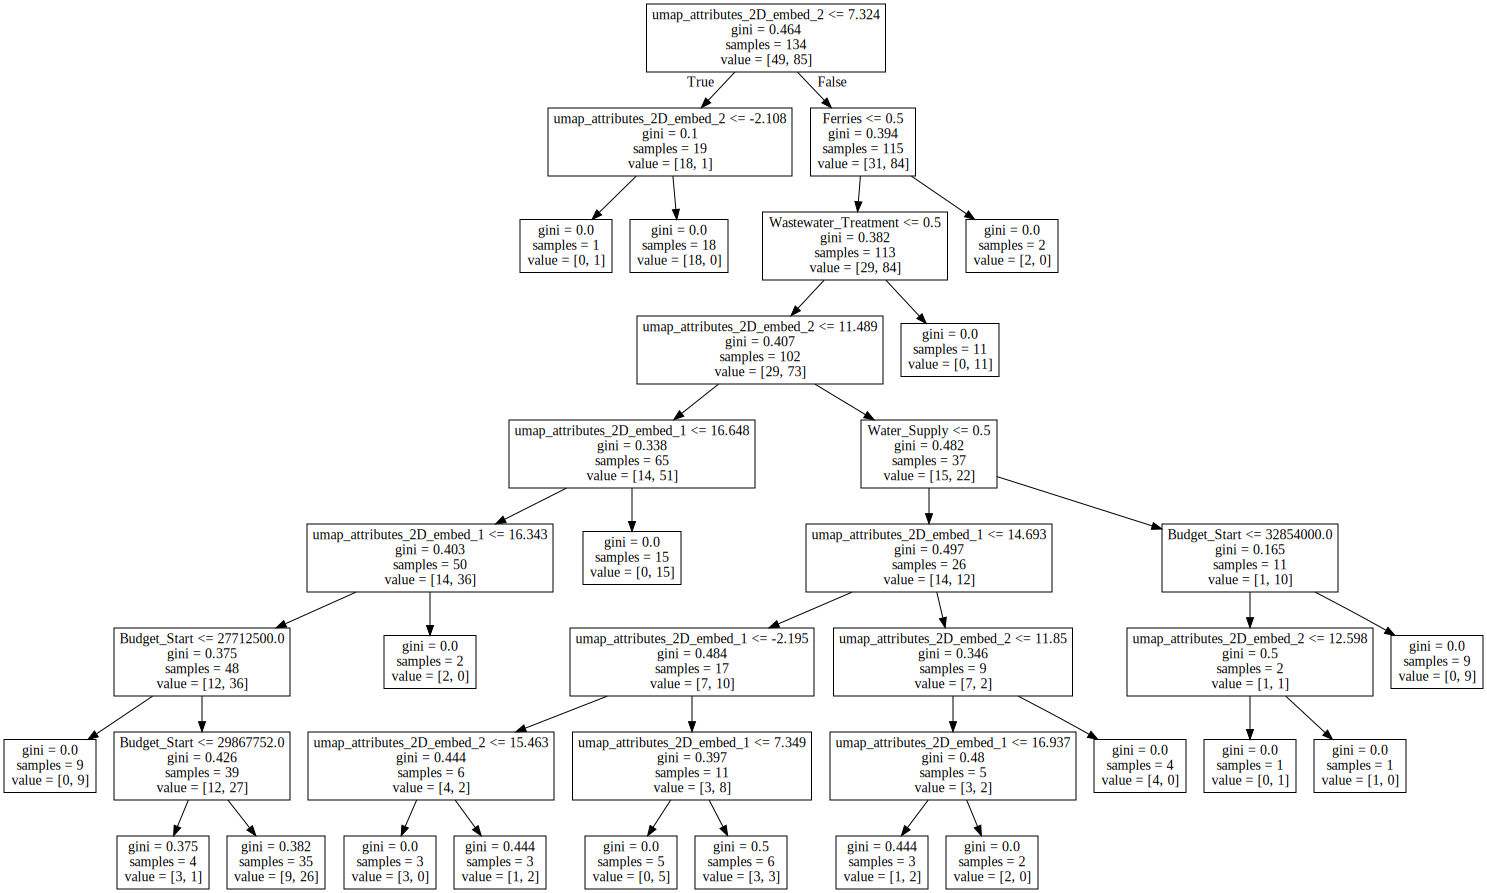

Model Optmized for: ['Schedule_Change_Ratio']


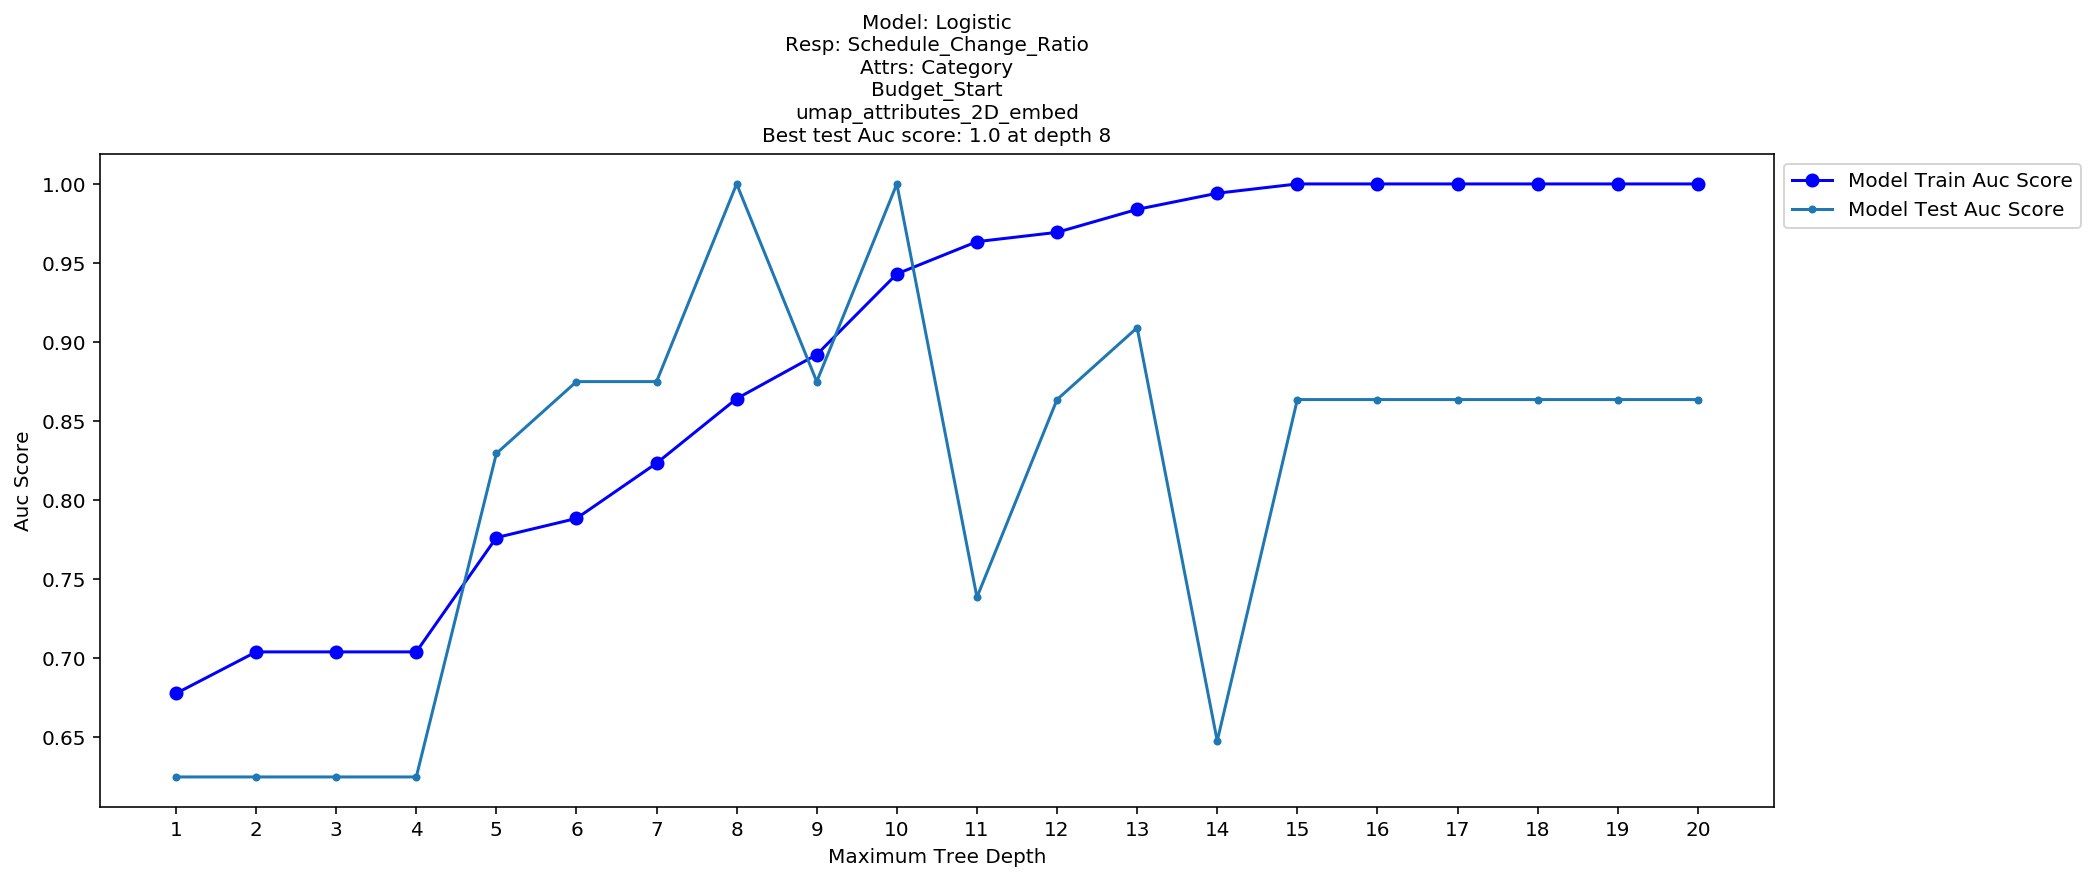

In [84]:
resp = 'Schedule_Change_Ratio'
max_score = results_df[results_df[resp]==1].test_score.max()
idx = results_df[(results_df[resp]==1) & (results_df.test_score==max_score)].sort_values(by='test_score').iloc[0].name
score_type = results_df.iloc[idx].scoring
print(f"Index Chosen: {idx}")

m_dict = results_all[idx]

print(f"Best {score_type} Score of Model Chosen: {round(max_score,4)} // Depth: {m_dict.get('best_depth')}")
print(f"Model Attributes: {m_dict.get('attributes')}")
print(f"Model Response: {m_dict.get('responses')}")

tree_dot_data = tree.export_graphviz(m_dict['best_model'], feature_names=m_dict['full_attributes'])
gr = graphviz.Source(tree_dot_data)
display(gr)

plot_me(results_all[idx])

### Review Best Performing Model with 'Budget Change' Response

Index Chosen: 54
Best auc Score of Model Chosen: 0.75 // Depth: 11
Model Attributes: ['Category', 'umap_attributes_2D_embed', 'pca_descr_embed']
Model Response: ['Budget_Change_Ratio']


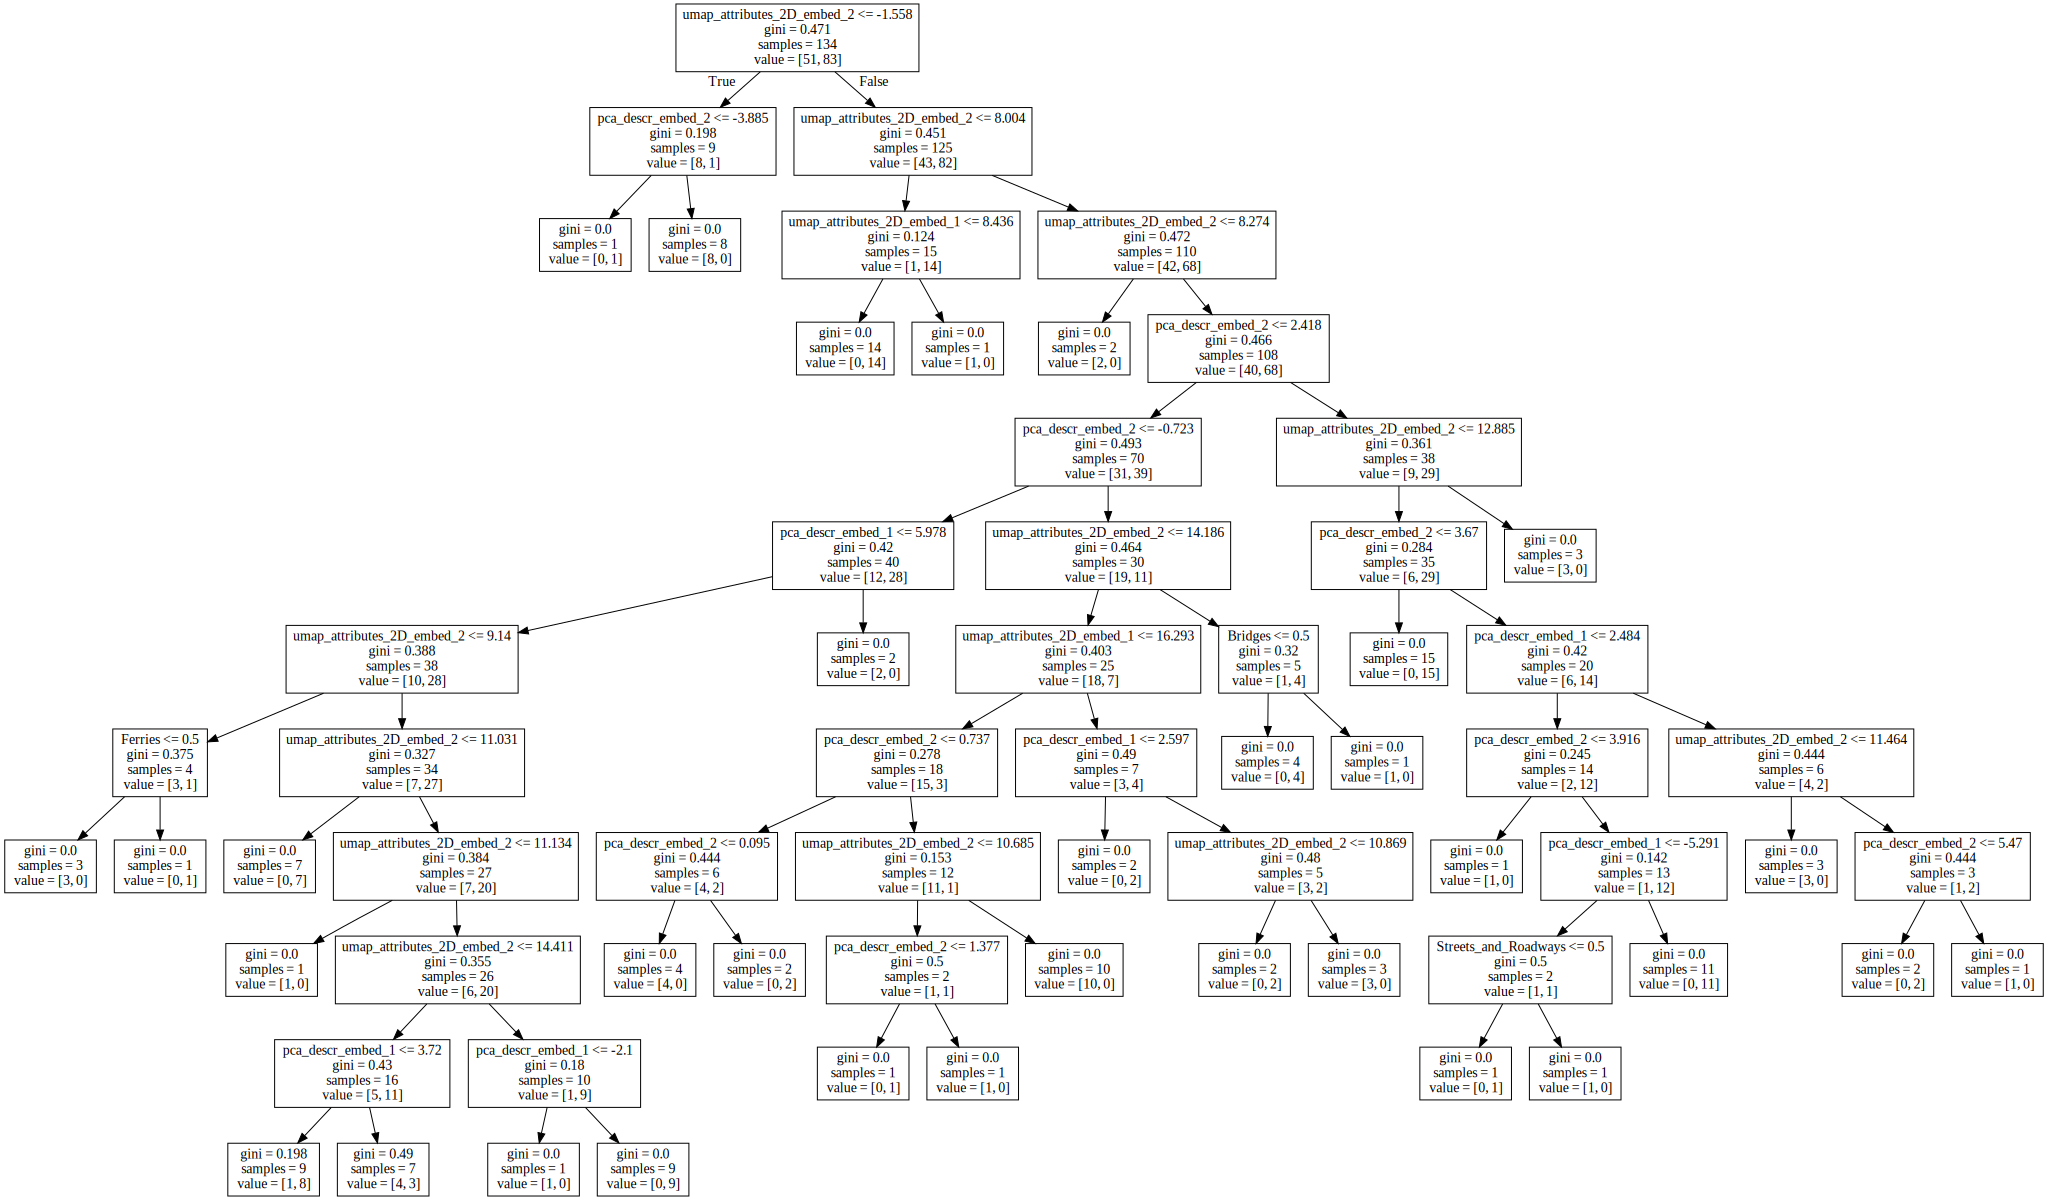

Model Optmized for: ['Budget_Change_Ratio']


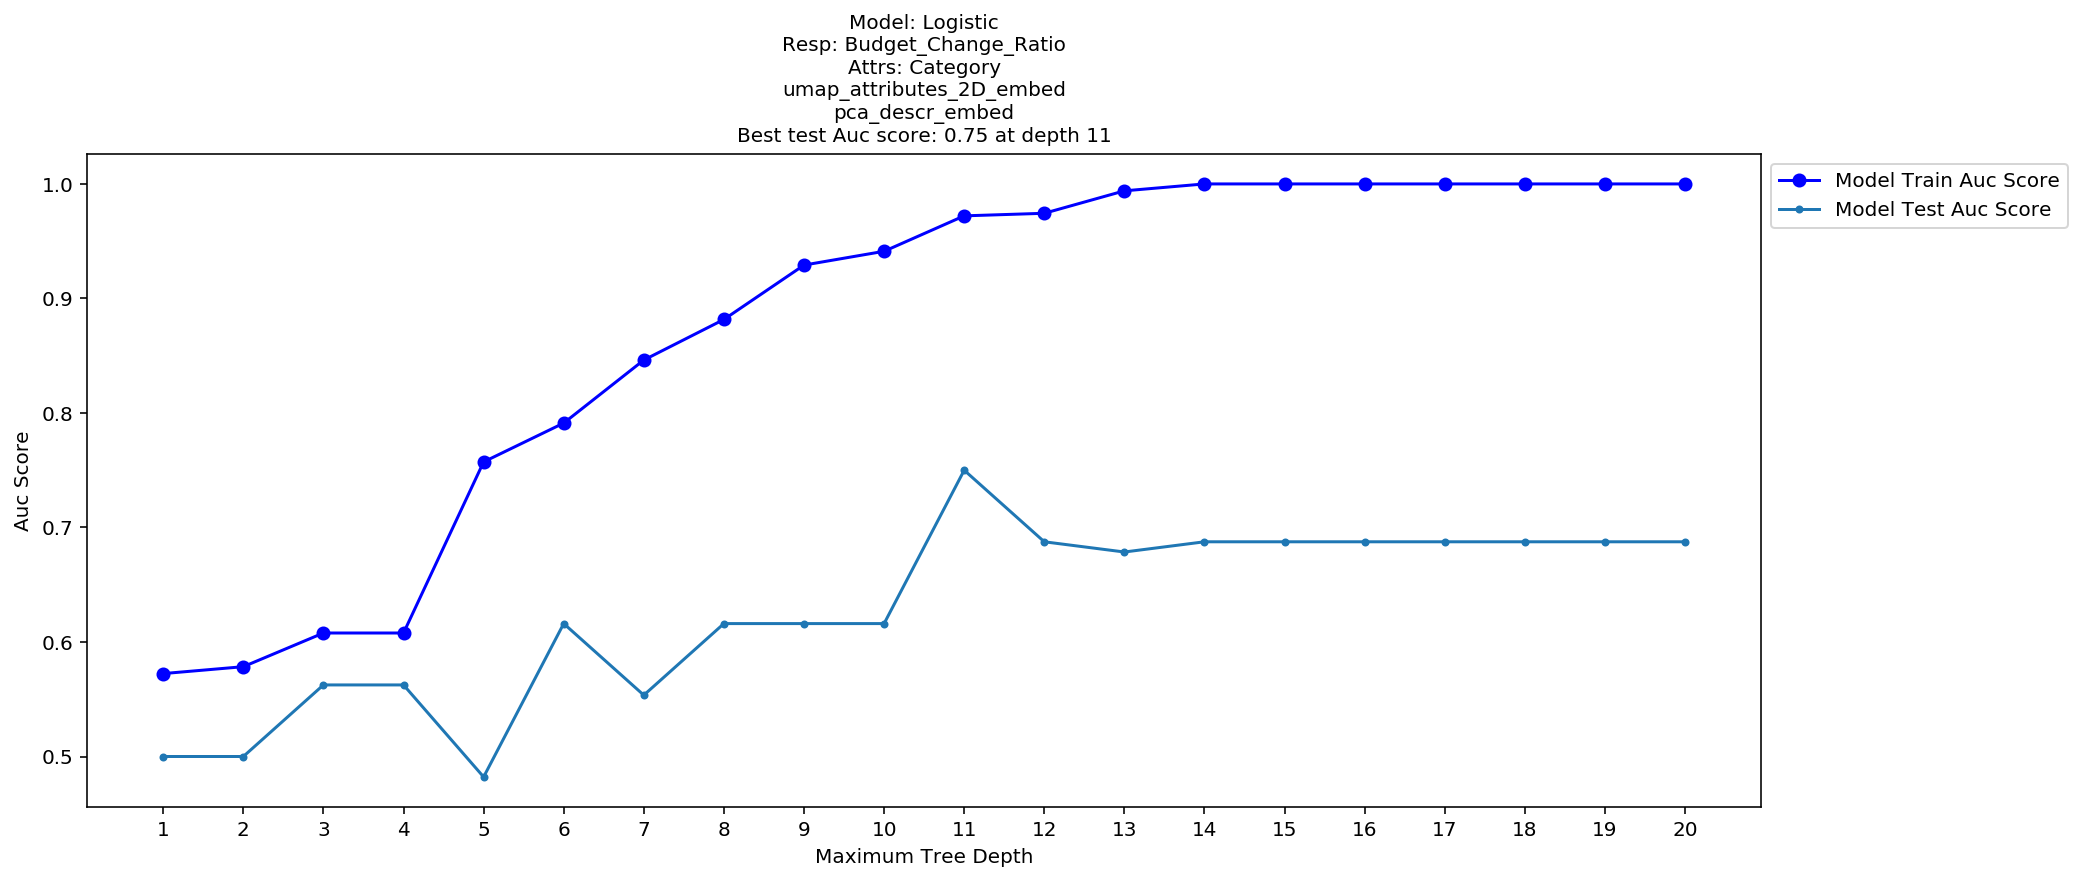

In [85]:
resp = 'Budget_Change_Ratio'
max_score = results_df[results_df[resp]==1].test_score.max()
idx = results_df[(results_df[resp]==1) & (results_df.test_score==max_score)].sort_values(by='test_score').iloc[0].name
score_type = results_df.iloc[idx].scoring
print(f"Index Chosen: {idx}")

m_dict = results_all[idx]

print(f"Best {score_type} Score of Model Chosen: {round(max_score,4)} // Depth: {m_dict.get('best_depth')}")
print(f"Model Attributes: {m_dict.get('attributes')}")
print(f"Model Response: {m_dict.get('responses')}")

tree_dot_data = tree.export_graphviz(m_dict['best_model'], feature_names=m_dict['full_attributes'])
gr = graphviz.Source(tree_dot_data)
display(gr)

plot_me(results_all[idx])

## Logsitic Models
These models will only try to predict if the budget or schedule will be over or under the initial estimate after a 3-year period.

As expected, the optimal models for predicting 'Schedule' and 'Budget' are different.  
Both models produce trees with a depth of significant complexity.

### The optimal 'Schedule' model uses the following parameters to predict 'Schedule Change Ratio :
'Category', 'Budget_Start', 'umap_attributes_2D_embed'

Best depth: 8
Best AUC score: 1.0
Of note is that attributes using the project description embeddeding did not find the optimal model.
Also interestingis that the starting planned schedule is not used to find the outcome of the Schedule.

### The optimal 'Budget' model uses the following parameters to predict 'Budget Change Ratio :
'Category', 'umap_attributes_2D_embed', 'pca_descr_embed'

Best depth: 11
Best AUC score: 0.75
Here, the description is inidicative the budget outcome.  Worth noting is the in the starting budget value is not useful in finding the optimal model to predict the budget outcome.

## Using Regression Models
The following steps will find the best combination of attributes to find the models which best predict Schedule and Budget.

In [86]:
nondescr_attrbutes = ['Category', 'Budget_Start', 'Duration_Start', 'umap_attributes_2D_embed']
descr_attributes = ['umap_descr_2D_embed', 'ae_descr_embed', 'pca_descr_embed']
responses_list = [['Budget_Change_Ratio'], ['Schedule_Change_Ratio']] 

results_all, model_dicts = calc_models(nondescr_attrbutes, descr_attributes, responses_list, logistic=False)

Using REGRESSION models


In [87]:
results_df = pd.DataFrame(results_all)
results_df.sort_values(by='test_score', ascending=False).head(3)

desc  model_type  \
105  Regression Tree. Depth: 7  Regression   
79   Regression Tree. Depth: 7  Regression   
99   Regression Tree. Depth: 3  Regression   

                                            attributes  \
105  [Budget_Start, Duration_Start, umap_attributes...   
79   [Duration_Start, umap_attributes_2D_embed, pca...   
99   [Category, Duration_Start, umap_attributes_2D_...   

                                       full_attributes  \
105  [Budget_Start, Duration_Start, umap_attributes...   
79   [Duration_Start, umap_attributes_2D_embed_1, u...   
99   [Duration_Start, Bridges, Ferries, Industrial_...   

                   responses  Budget_Change_Ratio  Schedule_Change_Ratio  \
105  [Schedule_Change_Ratio]                    0                      1   
79   [Schedule_Change_Ratio]                    0                      1   
99   [Schedule_Change_Ratio]                    0                      1   

     Budget_and_Schedule_Change scoring  best_depth  train_score  \
105                           0      r2           7         0.92   
79                            0      r2           7         0.94   
99                            0      r2           3         0.64   

                                          train_scores  test_score  \
105  [0.44471966298379717, 0.5113941010455046, 0.63...        0.71   
79   [0.44471966298379717, 0.5113941010455046, 0.64...        0.68   
99   [0.44471966298379717, 0.5113941010455046, 0.64...        0.66   

                                           test_scores  \
105  [0.3952918025270771, 0.4537588972378642, 0.537...   
79   [0.3952918025270771, 0.45375889723786433, 0.56...   
99   [0.3952918025270771, 0.4537588972378642, 0.656...   

                                            best_model  \
105  DecisionTreeRegressor(ccp_alpha=0.0, criterion...   
79   DecisionTreeRegressor(ccp_alpha=0.0, criterion...   
99   DecisionTreeRegressor(ccp_alpha=0.0, criterion...   

                                                depths  
105  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  
79   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  
99   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...

### Review Best Performing Model with 'Schedule Change' Response

Index Chosen: 105
Model Optmized for: ['Schedule_Change_Ratio']
Best r2 Score of Model Chosen: 0.7077 // Depth: 7
Model Attributes: ['Budget_Start', 'Duration_Start', 'umap_attributes_2D_embed']
Model Response: ['Schedule_Change_Ratio']


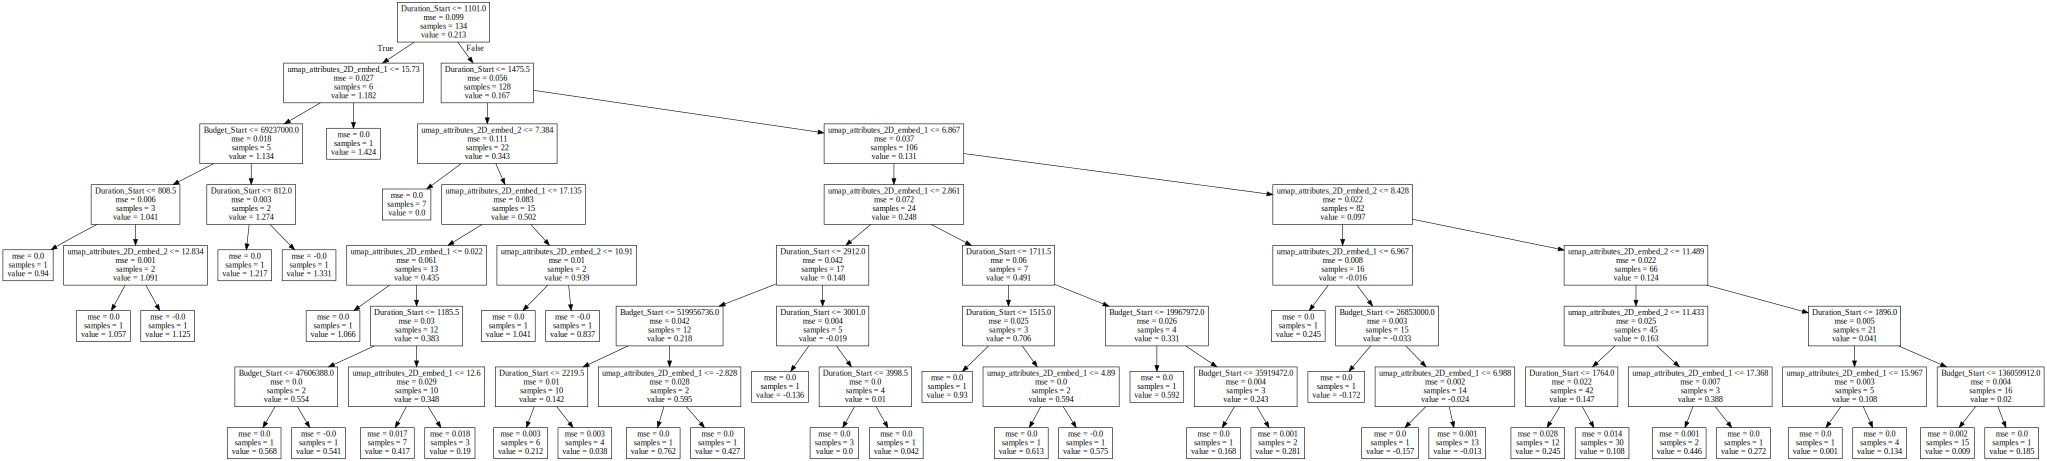


MODEL SUMMARY:
Regression Tree. Depth: 7


The fitted model object(s):

	DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=109, splitter='best')

	DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=109, splitter='best')


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.9968
		Test		-0.1285

	Schedule_Chang

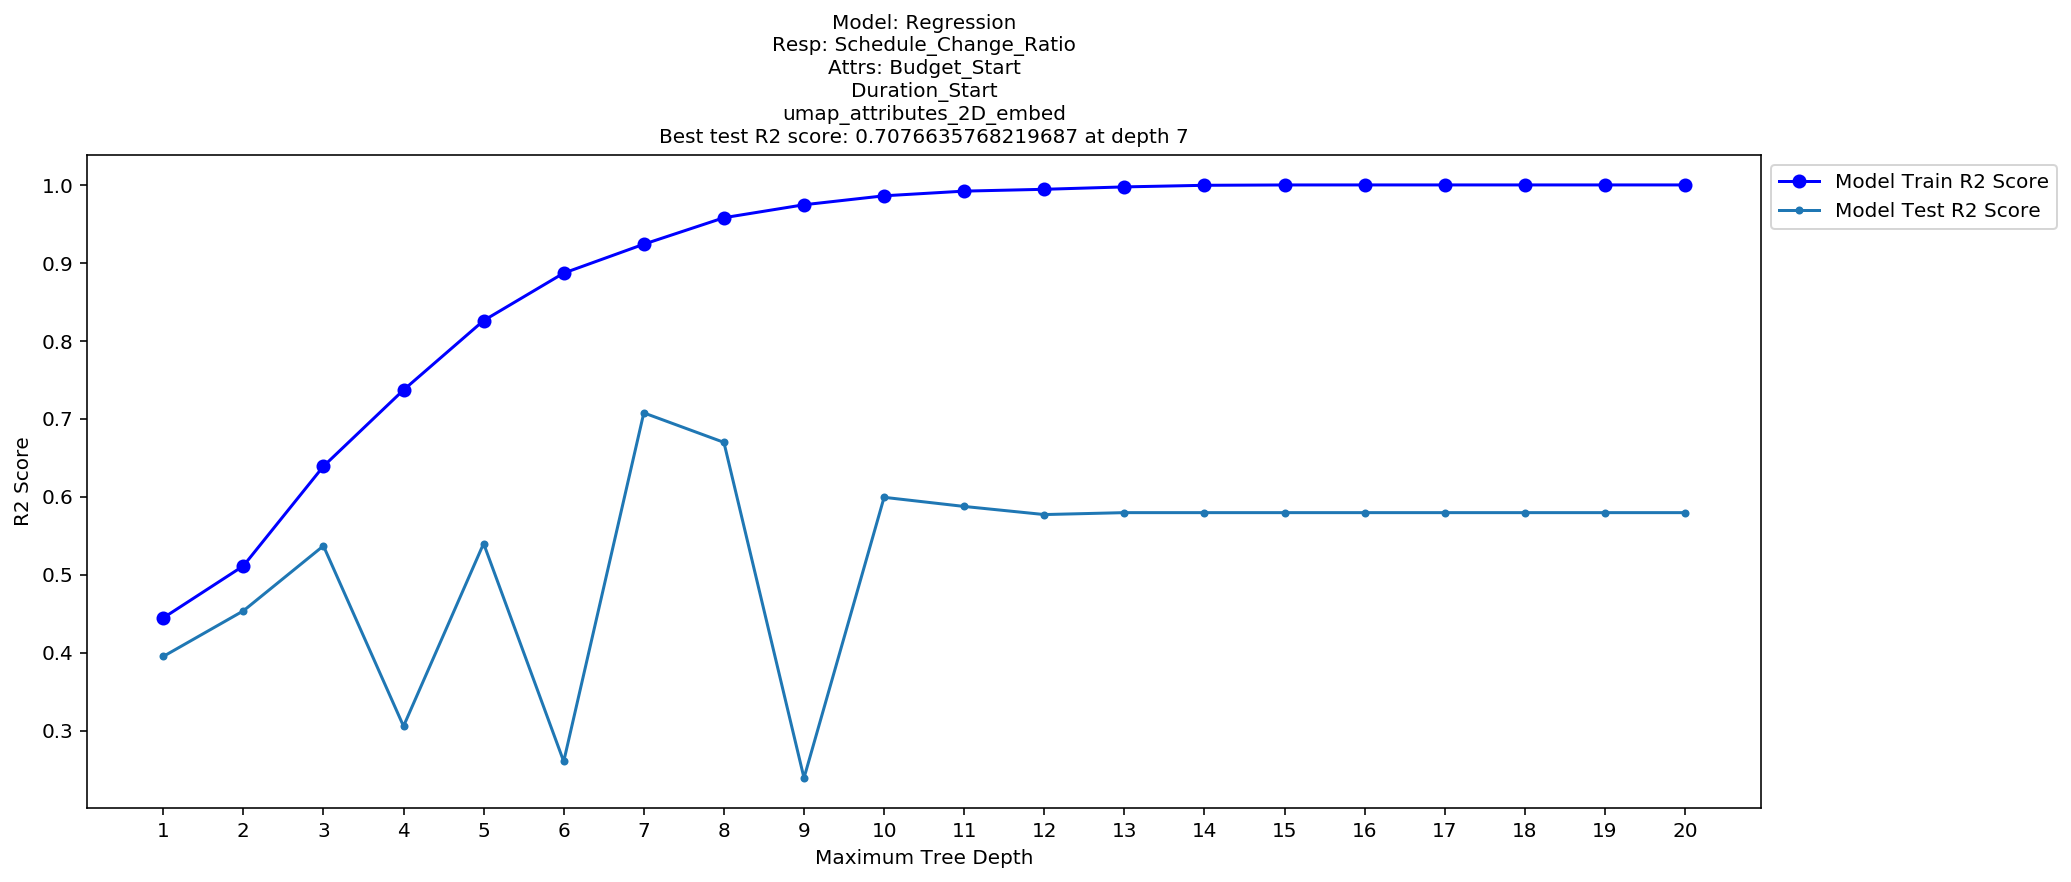

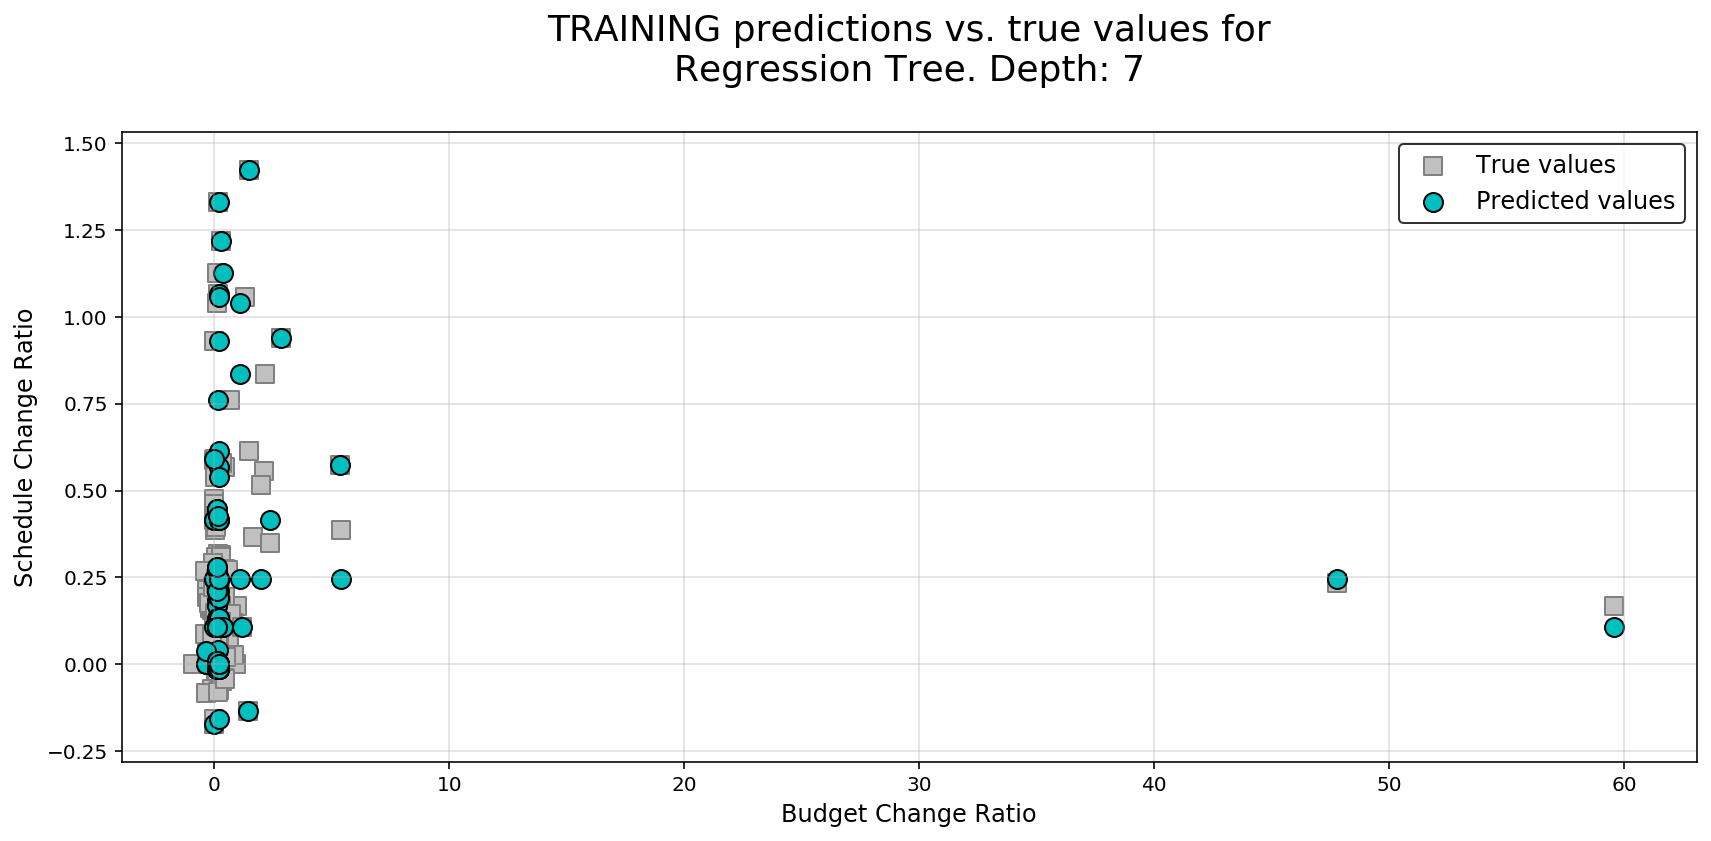

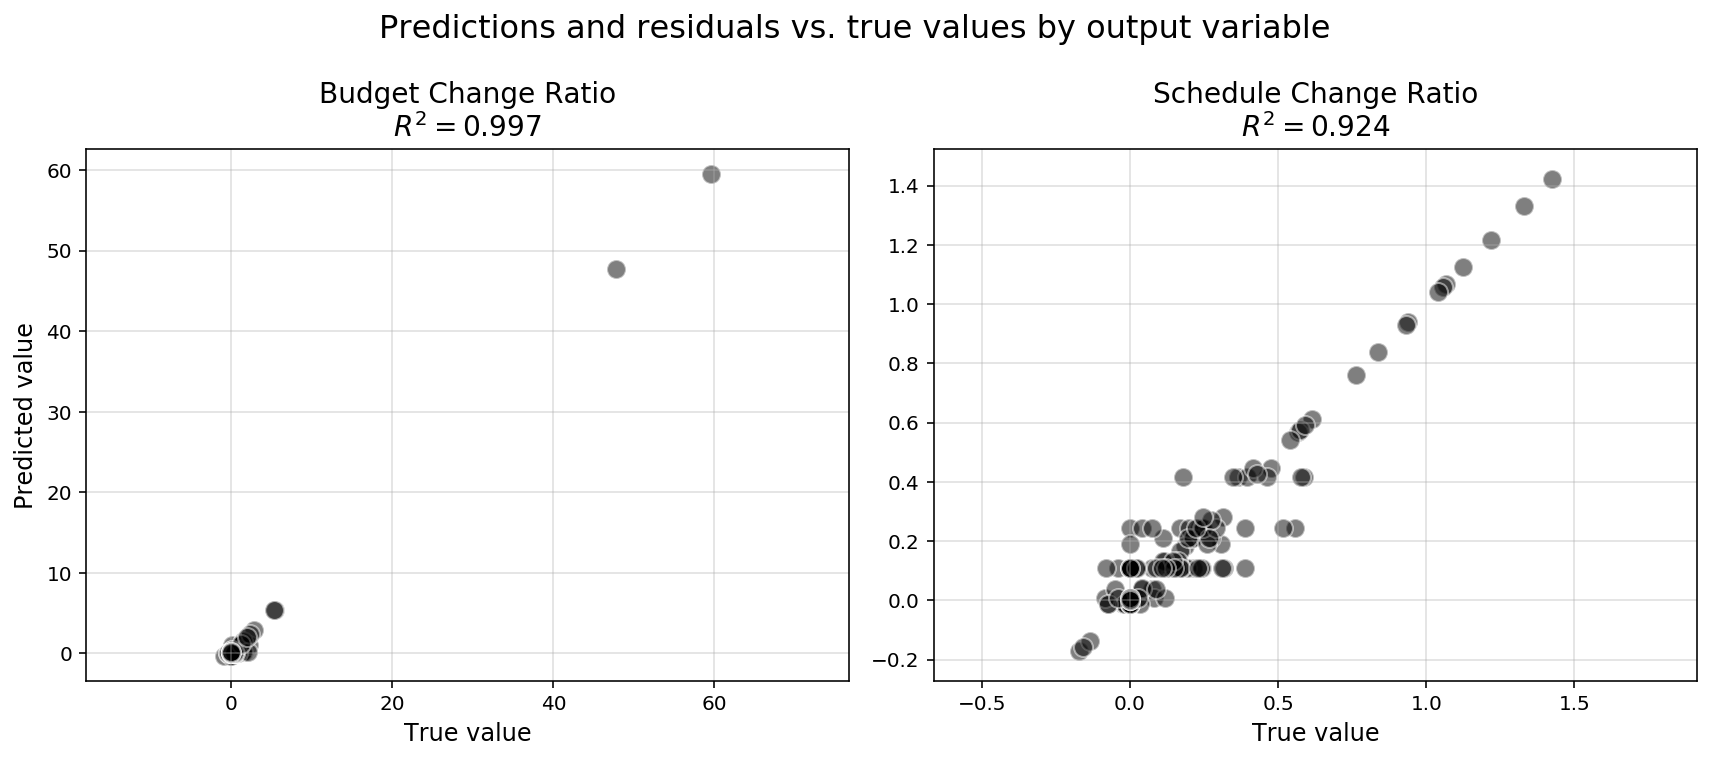

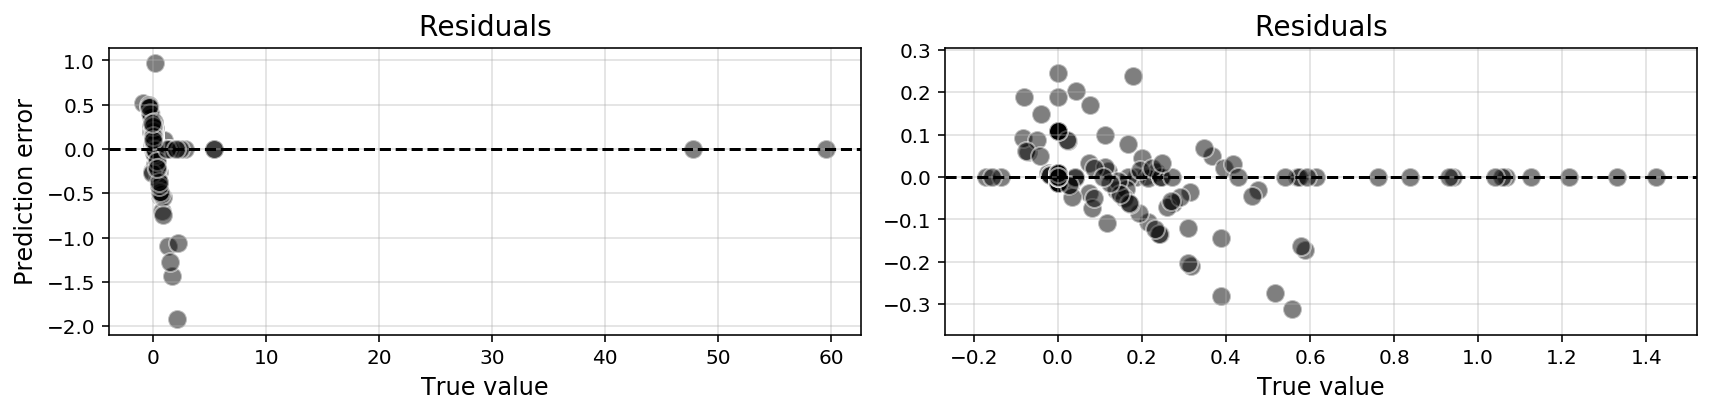

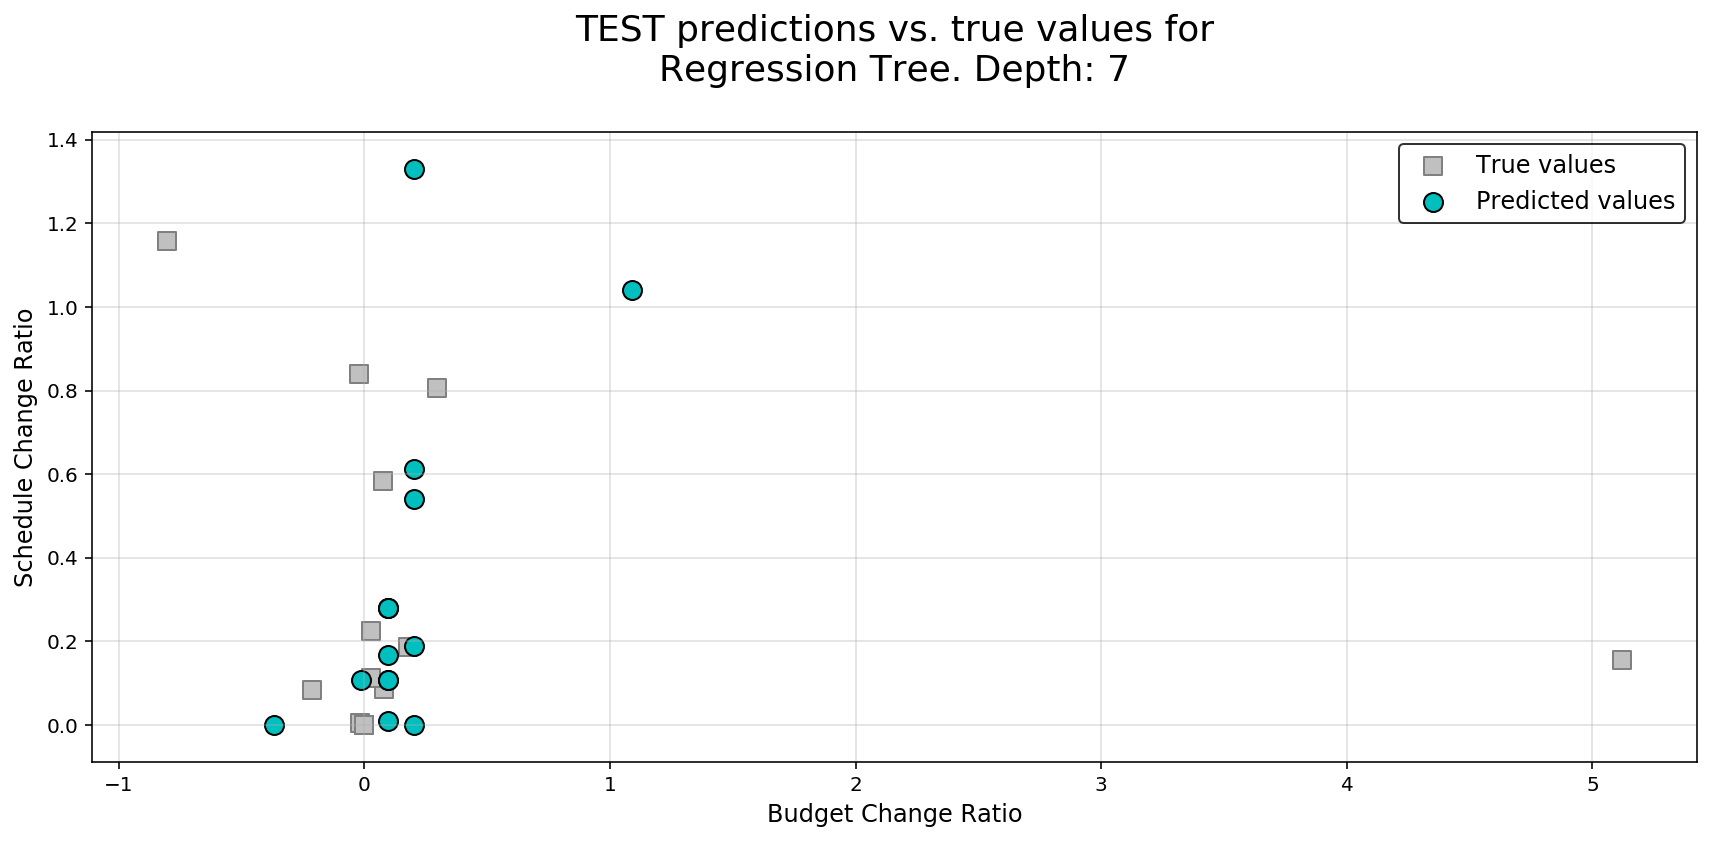

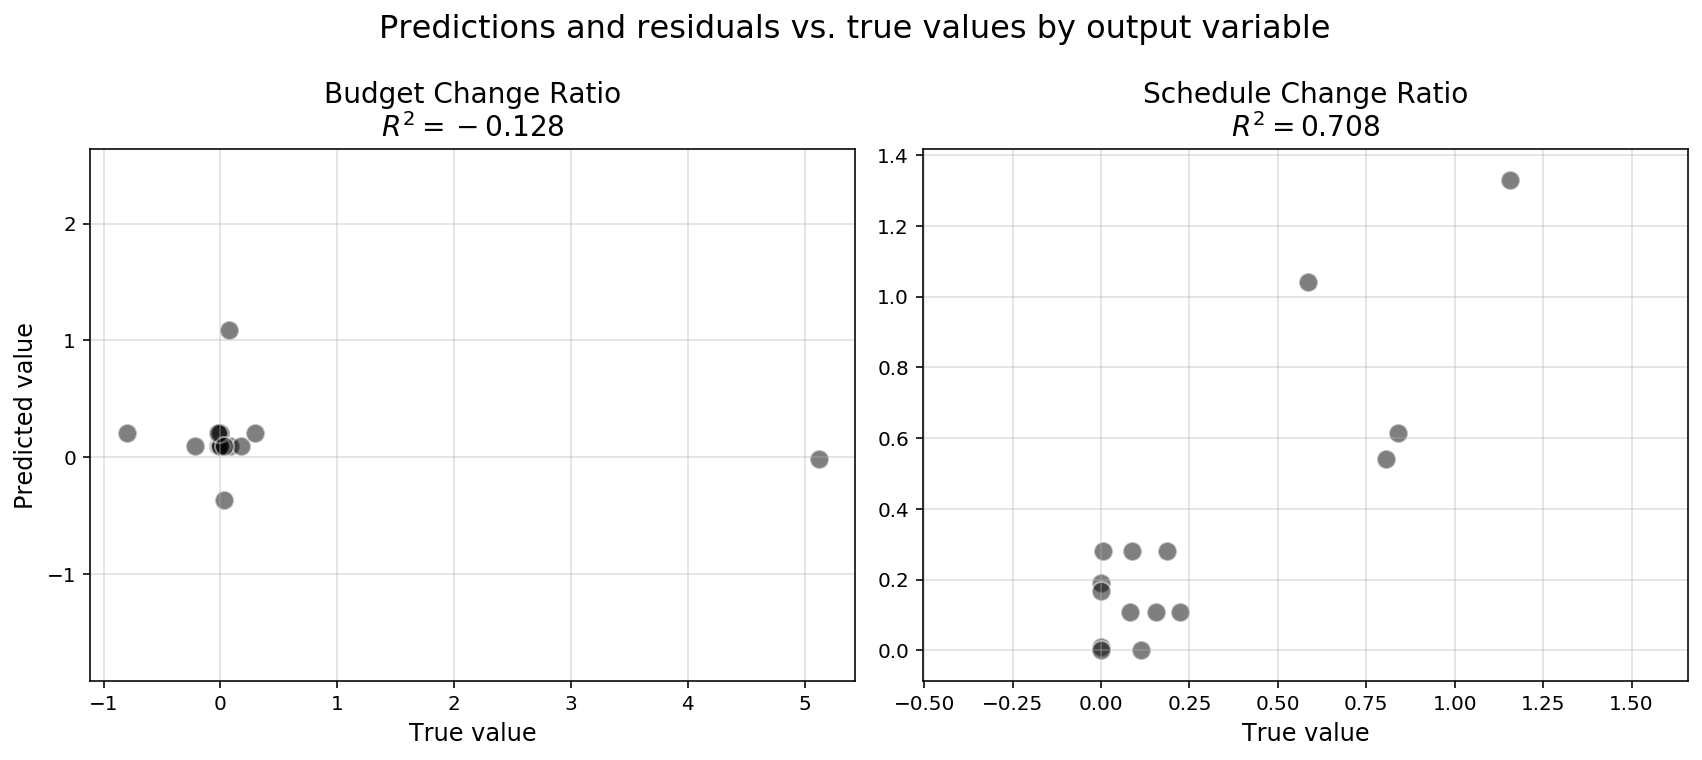

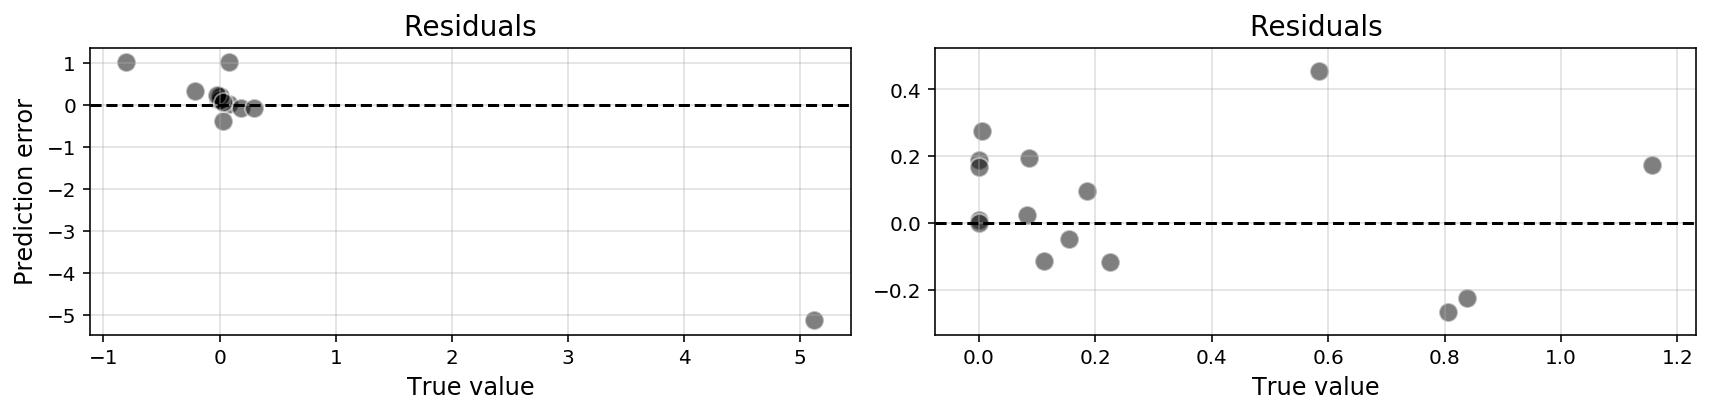

In [89]:
resp = 'Schedule_Change_Ratio'
max_score = results_df[results_df[resp]==1].test_score.max()
idx = results_df[(results_df[resp]==1) & (results_df.test_score==max_score)].sort_values(by='test_score').iloc[0].name
score_type = results_df.iloc[idx].scoring
print(f"Index Chosen: {idx}")

m_dict = results_all[idx]

plot_me(results_all[idx])

print(f"Best {score_type} Score of Model Chosen: {round(max_score,4)} // Depth: {m_dict.get('best_depth')}")
print(f"Model Attributes: {m_dict.get('attributes')}")
print(f"Model Response: {m_dict.get('responses')}")

tree_dot_data = tree.export_graphviz(m_dict['best_model'], feature_names=m_dict['full_attributes'])
gr = graphviz.Source(tree_dot_data)
display(gr)

m = model_dicts[idx]
print_model_results(m)
plot_true_pred(m, dataset='train')
plot_true_pred(m, dataset='test')

Index Chosen: 8
Model Optmized for: ['Budget_Change_Ratio']
Best r2 Score of Model Chosen: 0.3588 // Depth: 6
Model Attributes: ['Budget_Start']
Model Response: ['Budget_Change_Ratio']


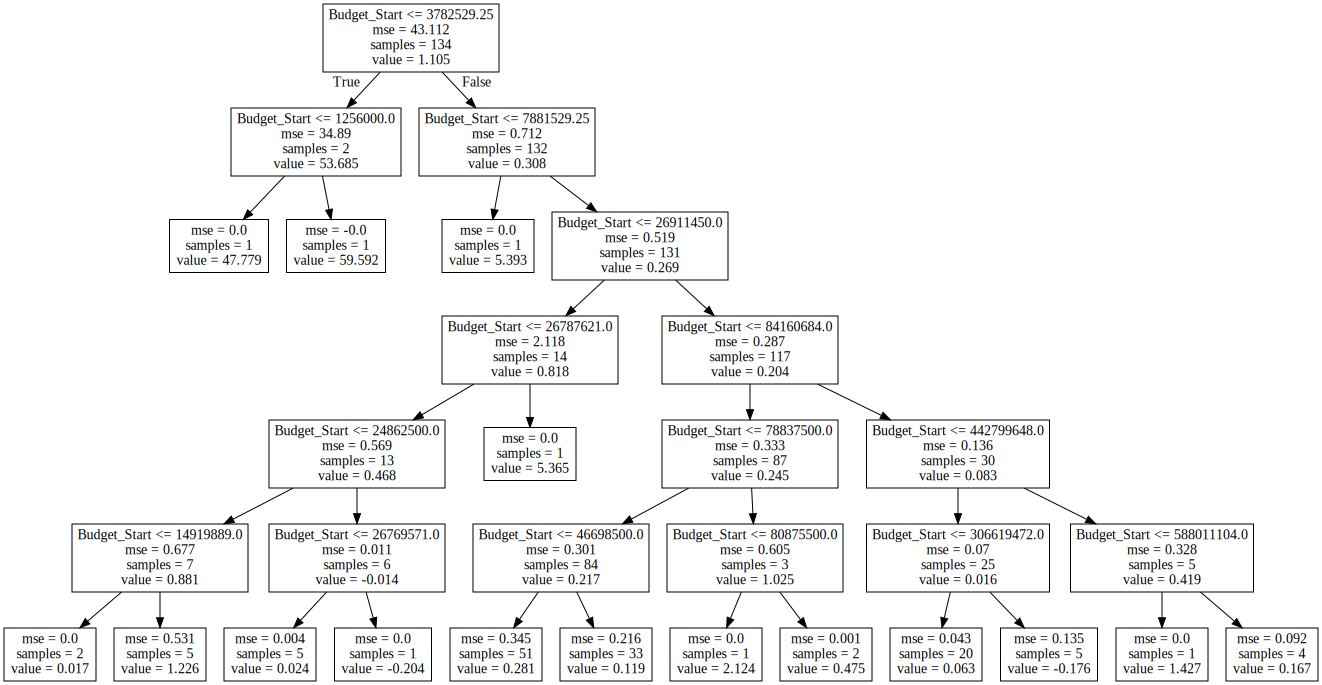


MODEL SUMMARY:
Regression Tree. Depth: 6


The fitted model object(s):

	DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=109, splitter='best')

	DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=109, splitter='best')


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.9949
		Test		0.3588

	Schedule_Change

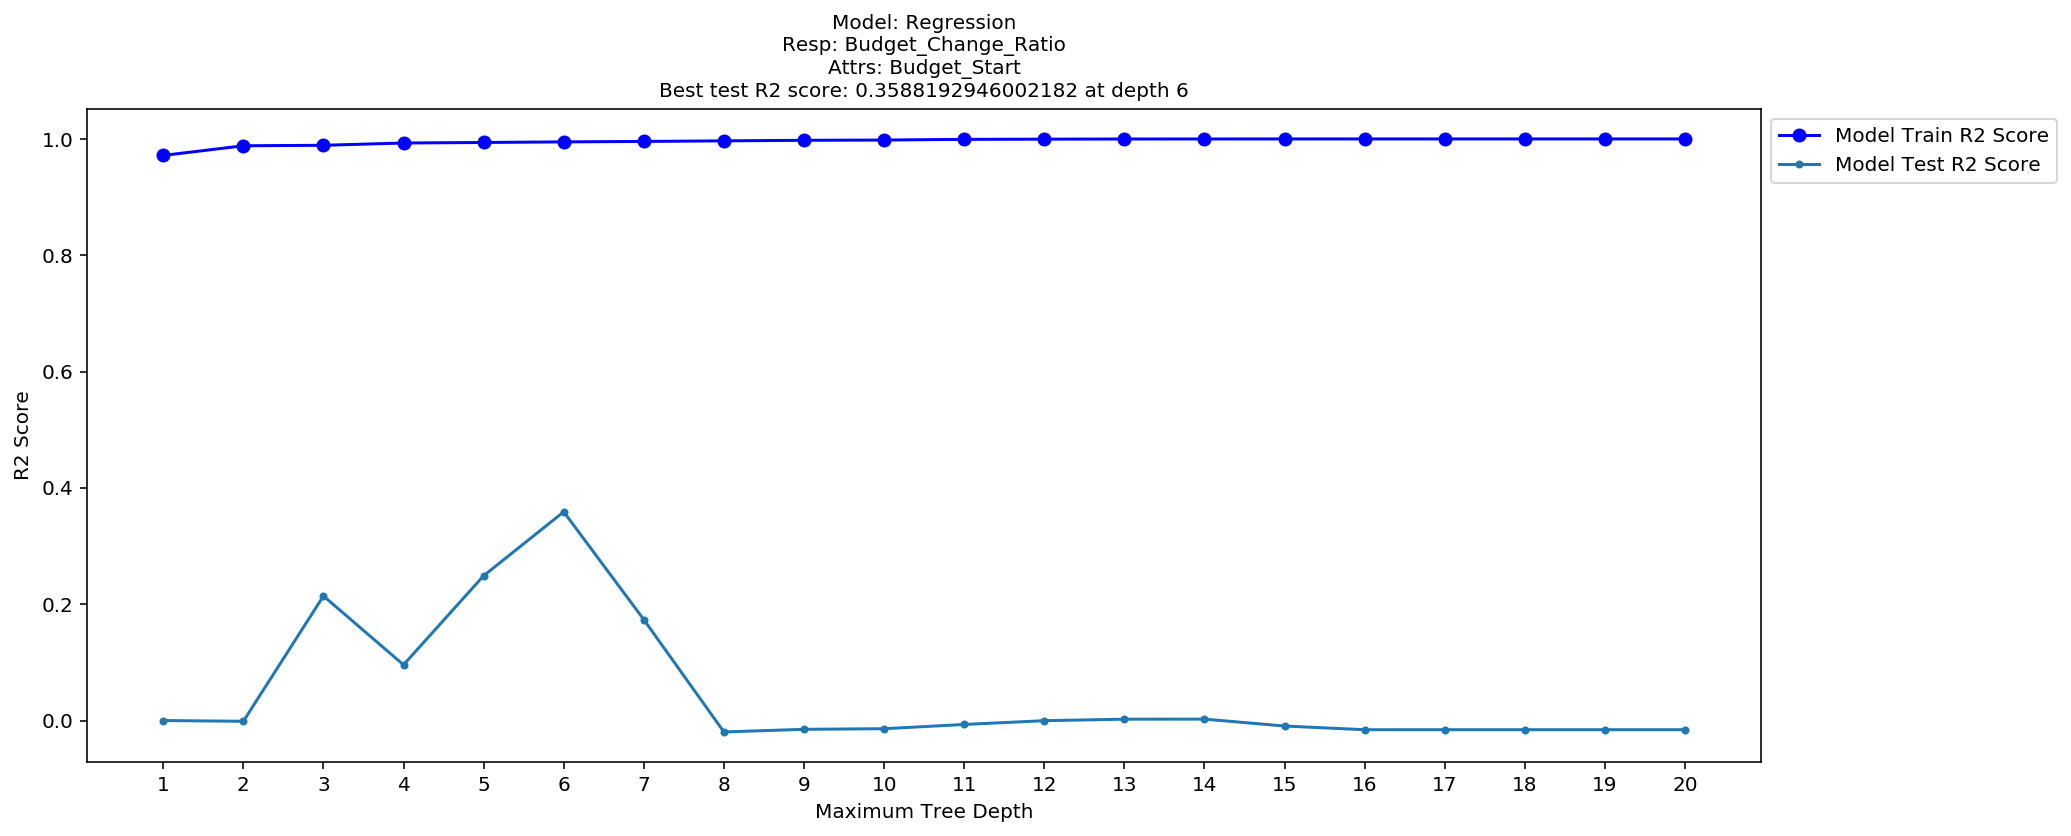

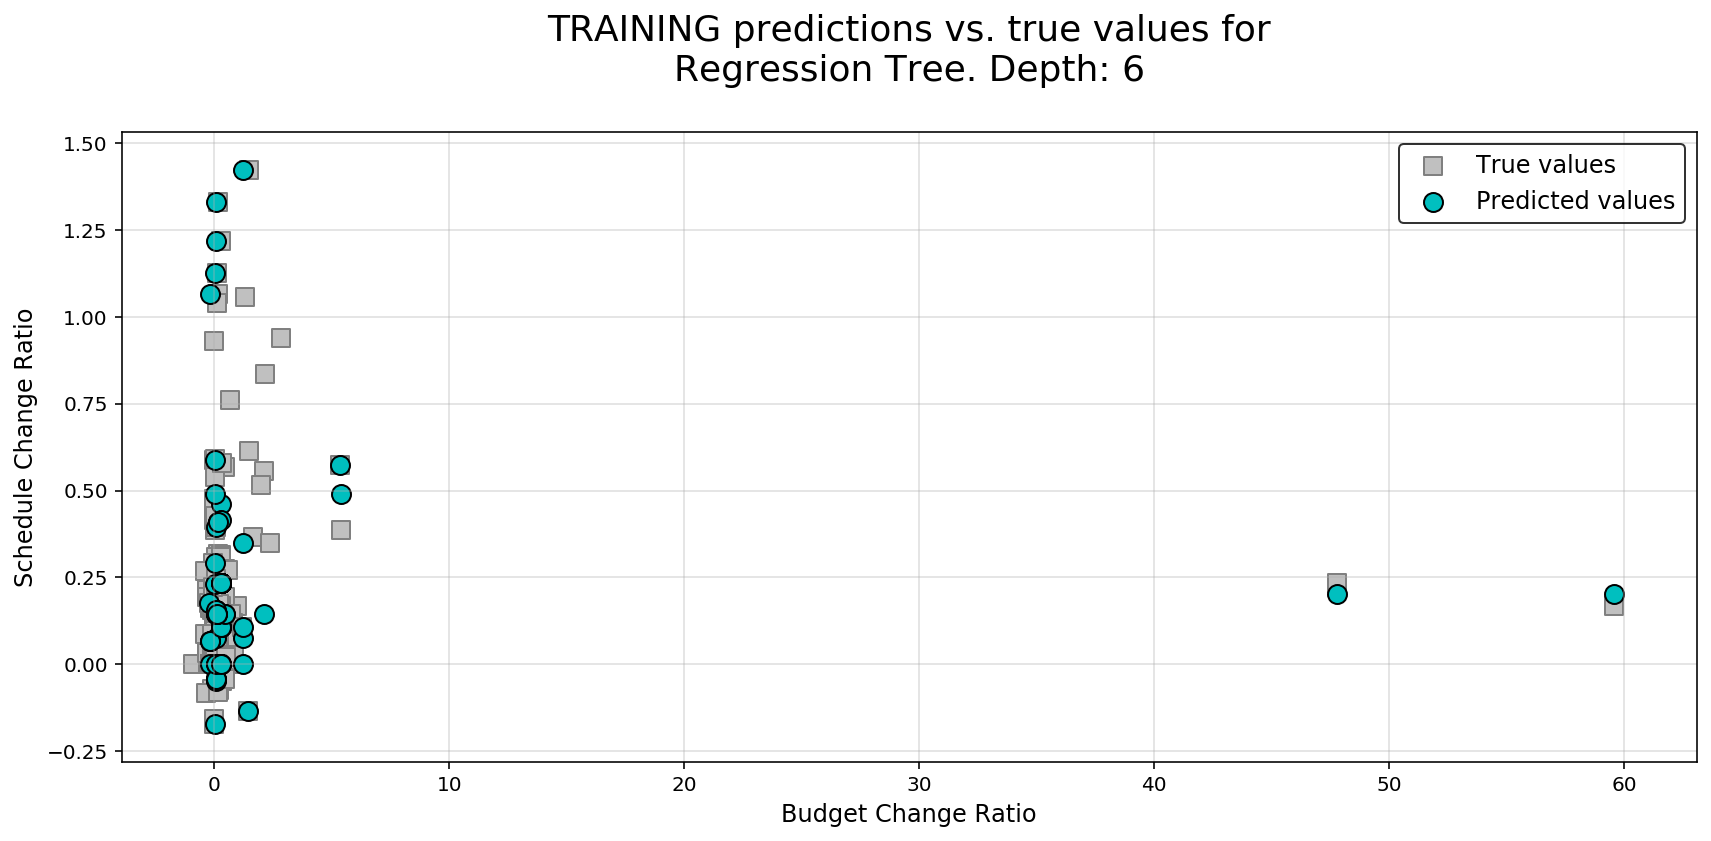

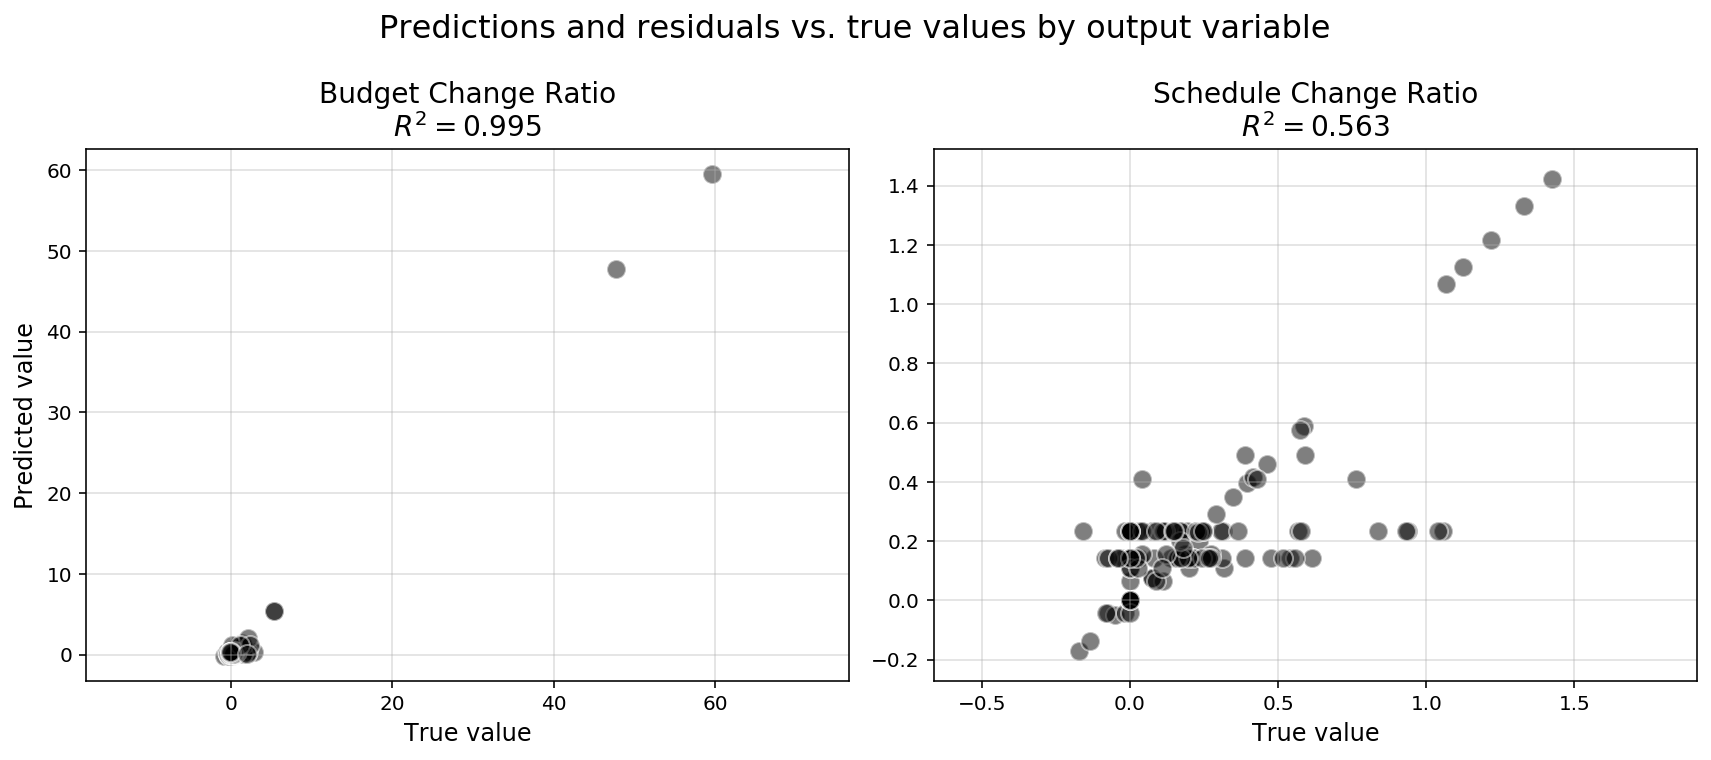

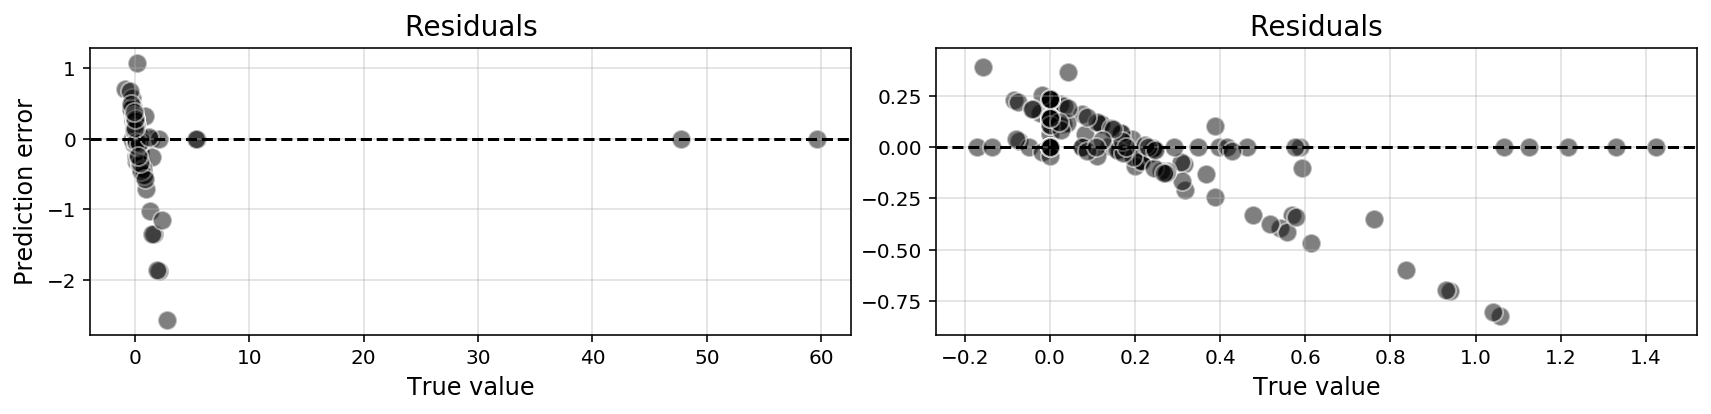

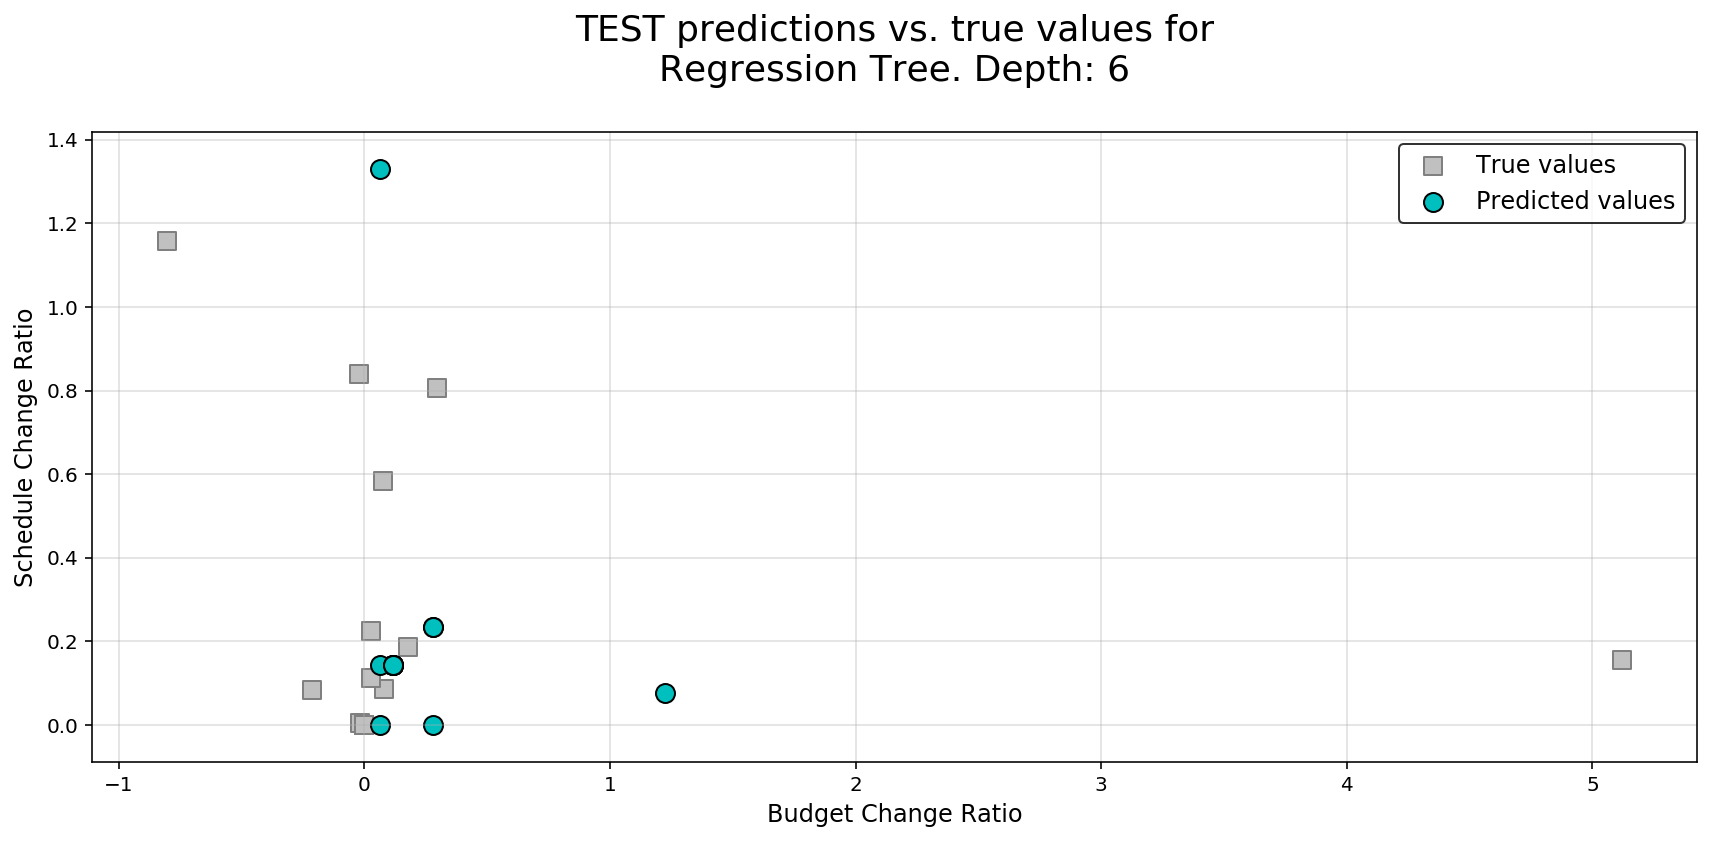

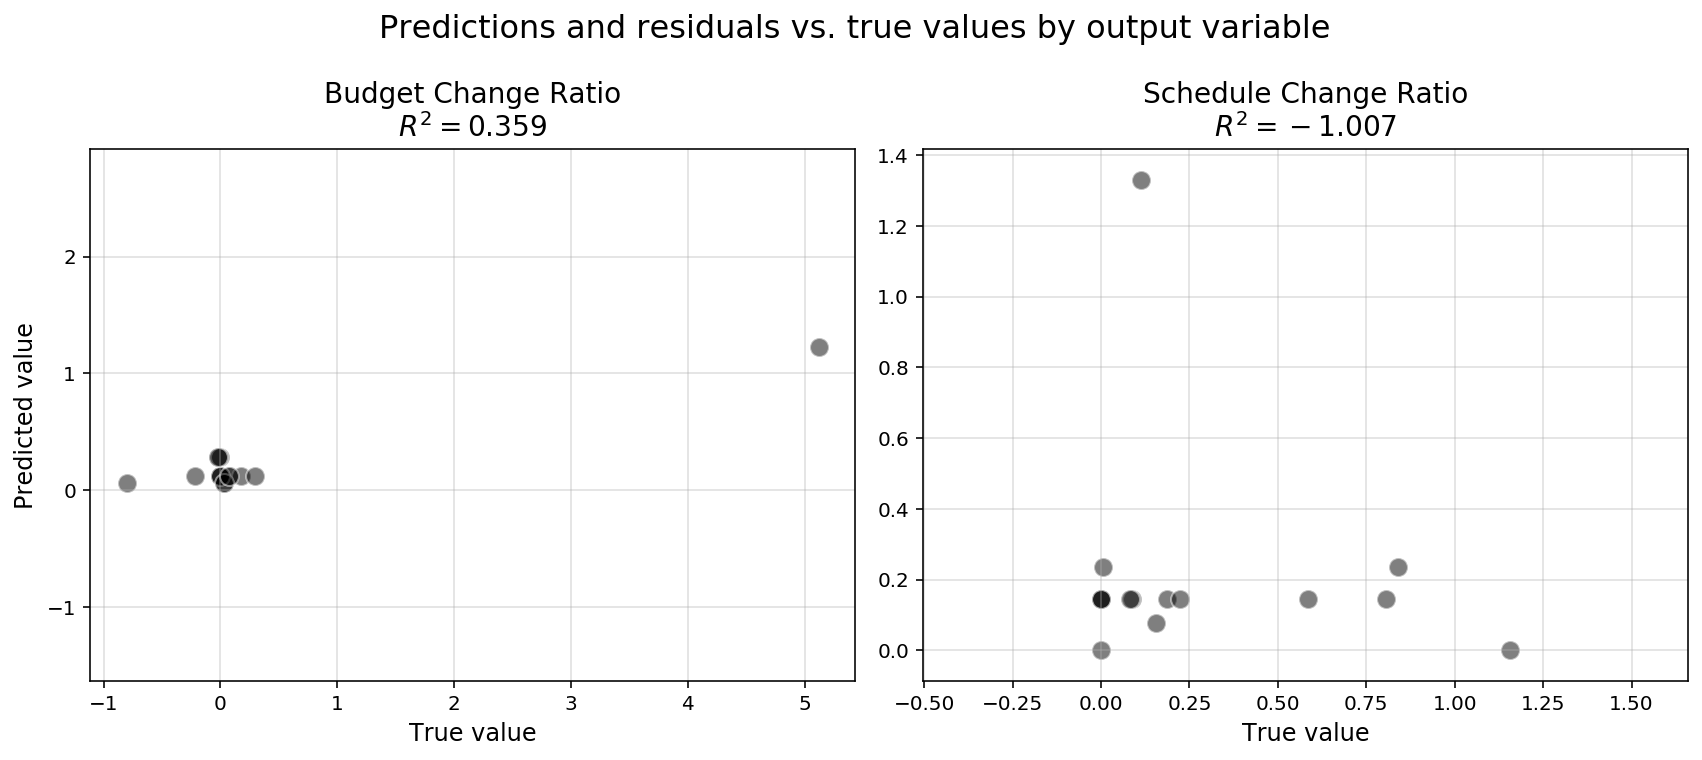

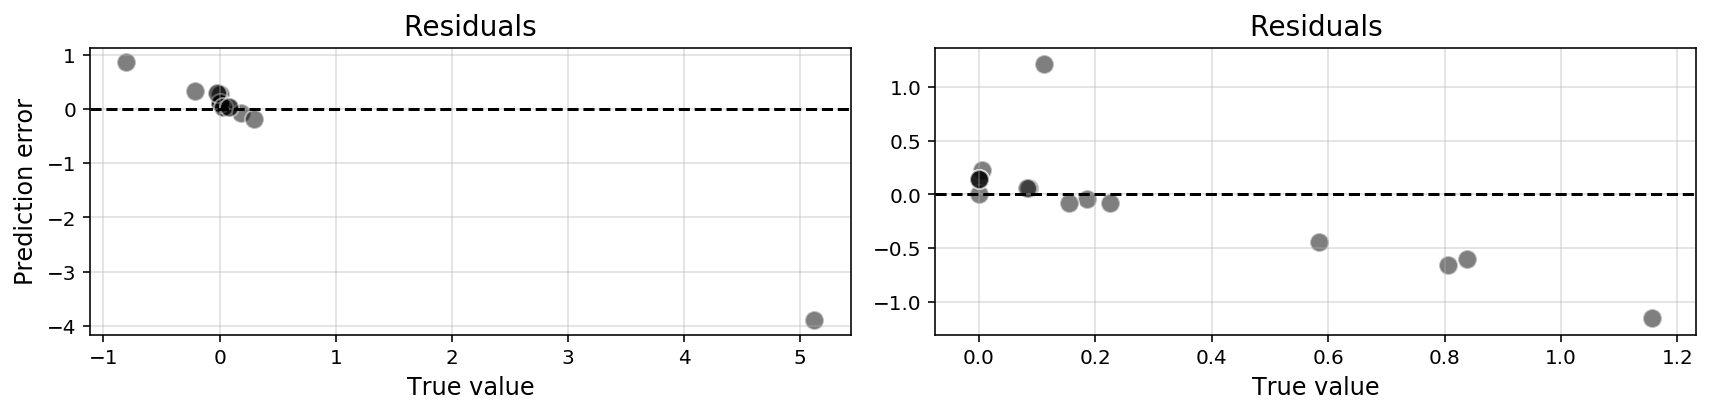

In [90]:
resp = 'Budget_Change_Ratio'
max_score = results_df[results_df[resp]==1].test_score.max()
idx = results_df[(results_df[resp]==1) & (results_df.test_score==max_score)].sort_values(by='test_score').iloc[0].name
score_type = results_df.iloc[idx].scoring
print(f"Index Chosen: {idx}")

m_dict = results_all[idx]

plot_me(results_all[idx])

print(f"Best {score_type} Score of Model Chosen: {round(max_score,4)} // Depth: {m_dict.get('best_depth')}")
print(f"Model Attributes: {m_dict.get('attributes')}")
print(f"Model Response: {m_dict.get('responses')}")

tree_dot_data = tree.export_graphviz(m_dict['best_model'], feature_names=m_dict['full_attributes'])
gr = graphviz.Source(tree_dot_data)
display(gr)

m = model_dicts[idx]
print_model_results(m)
plot_true_pred(m, dataset='train')
plot_true_pred(m, dataset='test')

## Nonparameteric Regression Models Summary 
These models attempt to predict the ending Schedule and Budget values after a 3-year period.

As expected, the optimal models for predicting 'Schedule' and 'Budget' are different.  
Both models produce trees with a depth of significant complexity.

### The optimal 'Schedule' model uses the following parameters to predict 'Schedule Change Ratio :
Budget_Start', 'Duration_Start', 'umap_attributes_2D_embed'

Best depth: 7
Best R2 score: 0.7077
Of note is that attributes using the project description embeddeding did not find the optimal model.

### The optimal 'Budget' model uses the following parameters to predict 'Budget Change Ratio :
'Budget_Start'

Best depth: 6
Best R2 score: .3588
Here, only the starting budget value is determined to be significant when predicting 'Budget Change Ratio'.  The R3 score is not exceptionally impressive which may be the result of some extreme outliers in the data.



<a name='boost'></a>

## 5.2. Ensemble Tree Regressors with Boosting

<a href=#nonparam>Return to section index</a>

**The unabridged notebook used to generate the findings in this section can be [found here on GitHub.](https://github.com/mcdomx/cs109b_groupproject/blob/master/notebooks/08_ensemble_tree_models.ipynb)**

### In this section, we continue with the nonparatric models by applying Boosting to the data using AdaBoost.  Boosting will use an ensemble of models to find an optimal model with a minimal number of iterations.  Boosting achieves this by including incorrect training iterations to find optimal parameters.

### As with the previous models, this section will iterate over all possible combination of attributes and responses to find the best model.  Additionally, we iterate over options for various AdaBoost paramters.  The process creates ### 600 ### models from which we can find the best performers.

### The cell below includes various functions used to create and evaluate various models.

In [91]:
def generate_adaboost_staged_scores(model_dict, X_train, X_test, y_train, y_test):
    """Generates adaboost staged scores in order to find ideal number of iterations
    
    :return: tuple of 2D np.arrays for adaboost staged scores at each iteration and
             each response variable, one array for training scores and one for test 
    """
    staged_scores_train = np.hstack(
        [
            np.array(
                list(
                    model.staged_score(
                        X_train.reset_index(drop=True),
                        y_train.reset_index(drop=True).iloc[:, i]
                    )
                )
            ).reshape(-1,1) for i, model in enumerate(model_dict['model'])
        ]
    )
    
    staged_scores_test = np.hstack(
        [
            np.array(
                list(
                    model.staged_score(
                        X_test.reset_index(drop=True),
                        y_test.reset_index(drop=True).iloc[:, i]
                    )
                )
            ).reshape(-1,1) for i, model in enumerate(model_dict['model'])
        ]
    )
    
    return staged_scores_train, staged_scores_test

def plot_adaboost_staged_scores(model_dict, X_train, X_test, y_train, y_test):
    """Plots the adaboost staged scores for each y variable's predictions and iteration
    
    """
    # generate staged_scores
    training_scores, test_scores = generate_adaboost_staged_scores(
        model_dict, X_train, X_test, y_train, y_test
    )
    
    max_depth = model_dict['model'][0].base_estimator.max_depth
    learning_rate = model_dict['model'][0].learning_rate
    y_vars = [var.replace('_', ' ') for var in model_dict['y_variables']]

    # create list of iteration numbers for plotting
    iteration_numbers = np.arange(model_dict['model'][0].n_estimators) + 1

    # plot figure
    fig, ax = plt.subplots(figsize=(12, 8))

    plt.title(
        "Number of iterations' effect on the AdaBoost Regessor's\nperformance "\
        "with max depth {} and learning rate {}".format(
            max_depth,
            learning_rate,
        ),
        fontsize=18,
    )

    ax.plot(
        iteration_numbers, training_scores[:, 0],
        color='k', linestyle='--', linewidth=2,
        label='{}, training'.format(y_vars[0]))

    ax.plot(
        iteration_numbers, test_scores[:, 0],
        color='k', linestyle='-', linewidth=2,
        label='{}, TEST'.format(y_vars[0]))

    ax.plot(
        iteration_numbers, training_scores[:, 1],
        color='silver', linestyle='--', linewidth=2,
        label='{}, training'.format(y_vars[1]))

    ax.plot(
        iteration_numbers, test_scores[:, 1],
        color='silver', linestyle='-', linewidth=2,
        label='{}, TEST'.format(y_vars[1]))

    ax.tick_params(labelsize=12)
    ax.set_ylabel("$R^2$ score", fontsize=16)
    ax.set_xlabel("number of adaboost iterations", fontsize=16)
    ax.set_xticks(iteration_numbers)
    ax.grid(':', alpha=0.4)
    ax.legend(fontsize=12, edgecolor='k')

    plt.tight_layout()
    plt.show();

In [93]:
# Iterate over combinations of attributes available saving the trained models in each iteration

def flatten(T):
    if type(T) != tuple: return (T,)
    if len(T) == 0: return ()
    else: return flatten(T[0]) + flatten(T[1:])

model_descr = 'AdaBoost tree ensemble unscaled data'

# set parameters for AdaBoostRegressor model object
max_depths = [2, 3, 5, 7]
learning_rate = 0.05
estimators = [20,40,60]
random_state = 109

# calculate all combinations of modeling options of attribute and responses
model_dicts = []

nondescr_attrbutes = ['Category_Code', 'Budget_Start', 'Duration_Start', ('umap_attributes_2D_embed_1', 'umap_attributes_2D_embed_2')]
descr_attributes = [['umap_descr_2D_embed_1', 'umap_descr_2D_embed_2'],
                    ['ae_descr_embed_1', 'ae_descr_embed_2'],
                    ['pca_descr_embed_1', 'pca_descr_embed_2']]

responses = ['Budget_Change_Ratio', 'Schedule_Change_Ratio']


print("Using ADABoost REGRESSION models")
for n_estimators in tqdm(estimators, desc="n_estimators"):
    for max_depth in tqdm(max_depths, desc="max_depths", leave=False):
        for i in tqdm(range(1, len(nondescr_attrbutes)), desc="nondesc attributes", leave=False):
            alist = list(itertools.combinations(nondescr_attrbutes, i))
            alist = [flatten(a) for a in alist]
            
            for a in tqdm(alist, desc="nondesc attributes combinations", leave=False):
                a = list(a)

                model_dict = generate_model_dict(
                                                    AdaBoostRegressor,
                                                    model_descr,
                                                    data_train[a], data_test[a], data_train[responses], data_test[responses],
                                                    multioutput=False,
                                                    verbose=False,
                                                    predictions=True,
                                                    scores=True,
                                                    model_api='sklearn',
                                                    # these parameters below will be passed as *kwargs,
                                                    # which means they will feed directly to the model object
                                                    # when it is initialized
                                                    base_estimator=DecisionTreeRegressor(
                                                        max_depth=max_depth, random_state=random_state
                                                    ),
                                                    learning_rate = learning_rate,
                                                    n_estimators = n_estimators,
                                                    random_state=random_state
                                                )

                staged_scores_train, staged_scores_test = generate_adaboost_staged_scores(model_dict, data_train[a], data_test[a], data_train[responses], data_test[responses])

                model_dict.update({ 'staged_scores_train': staged_scores_train, 
                                    'staged_scores_test':staged_scores_test,
                                    'max_depth': max_depth, 
                                    'learning_rate': learning_rate, 
                                    'n_estimators': n_estimators,
                                    'attributes': a,
                                    'responses': responses,
                                    'random_state': random_state})
                model_dicts.append(model_dict)

                for d_emb in tqdm(descr_attributes, desc="descriptions", leave=False):

                    model_dict = generate_model_dict(
                                                        AdaBoostRegressor,
                                                        model_descr,
                                                        data_train[a + d_emb], data_test[a + d_emb], data_train[responses], data_test[responses],
                                                        multioutput=False,
                                                        verbose=False,
                                                        predictions=True,
                                                        scores=True,
                                                        model_api='sklearn',
                                                        # these parameters below will be passed as *kwargs,
                                                        # which means they will feed directly to the model object
                                                        # when it is initialized
                                                        base_estimator=DecisionTreeRegressor(
                                                            max_depth=max_depth, random_state=random_state
                                                        ),
                                                        learning_rate = learning_rate,
                                                        n_estimators = n_estimators,
                                                        random_state=random_state
                                                    )

                    staged_scores_train, staged_scores_test = generate_adaboost_staged_scores(model_dict, data_train[a + d_emb], data_test[a + d_emb], data_train[responses], data_test[responses])

                    model_dict.update({ 'staged_scores_train': staged_scores_train, 'staged_scores_test':staged_scores_test,
                                        'max_depth': max_depth, 
                                        'learning_rate': learning_rate, 
                                        'n_estimators': n_estimators,
                                        'attributes': a + d_emb,
                                        'responses': responses,
                                        'random_state': random_state})
                    model_dicts.append(model_dict)



Using ADABoost REGRESSION models


In [94]:
# Create a dataframe from the model_dicts to allow filtering on the models created
descriptions = []
train_scores_bud = []
train_scores_sch = []
test_scores_bud = []
test_scores_sch = []
max_depths = []
staged_scores_train = []
staged_scores_test = []
lrs = []
n_estimators = []

for m in model_dicts:
    descriptions.append(m['description'])
    train_scores_bud.append(m['score']['train'][0])
    train_scores_sch.append(m['score']['train'][1])
    test_scores_bud.append(m['score']['test'][0])
    test_scores_sch.append(m['score']['test'][1])
    max_depths.append(m['max_depth'])
    lrs.append(m['learning_rate'])
    n_estimators.append(m['n_estimators'])
    staged_scores_train.append(m['staged_scores_train'])
    staged_scores_test.append(m['staged_scores_test'])
    
results = pd.DataFrame.from_dict({
                        'description': descriptions,
                        'train_score_bud': train_scores_bud,
                        'train_score_sch': train_scores_sch,
                        'test_score_bud': test_scores_bud,
                        'test_score_sch': test_scores_sch,
                        'max_depth': max_depths,
                        'lr': lrs,
                        'n_estimators': n_estimators,
                        'staged_scores_train': staged_scores_train,
                        'staged_scores_test': staged_scores_test
                        })

In [95]:
results.sort_values(by='test_score_sch', ascending=False).head(3)

description  train_score_bud  train_score_sch  \
444  AdaBoost tree ensemble unscaled data             1.00             0.96   
204  AdaBoost tree ensemble unscaled data             1.00             0.93   
332  AdaBoost tree ensemble unscaled data             0.99             0.73   

     test_score_bud  test_score_sch  max_depth   lr  n_estimators  \
444           -0.07            0.70          7 0.05            40   
204           -0.15            0.69          7 0.05            20   
332            0.14            0.69          3 0.05            40   

                                   staged_scores_train  \
444  [[0.970832325694863, 0.7604005569140995], [0.9...   
204  [[0.6753933092115462, 0.7651227626271309], [0....   
332  [[0.9646808181742339, 0.6400864763644332], [0....   

                                    staged_scores_test  
444  [[-0.032717426363226165, 0.4681959036145342], ...  
204  [[-0.10821201757168764, 0.4652116494812605], [...  
332  [[0.31276919259203106, 0.500042088490582], [0....

## Review the Impact of N_estiamtors and Max_depth

In [96]:
#we limit the outliers for display
results_no_outliers = results[(results.test_score_bud>-.4) & (results.test_score_sch>-.4)]

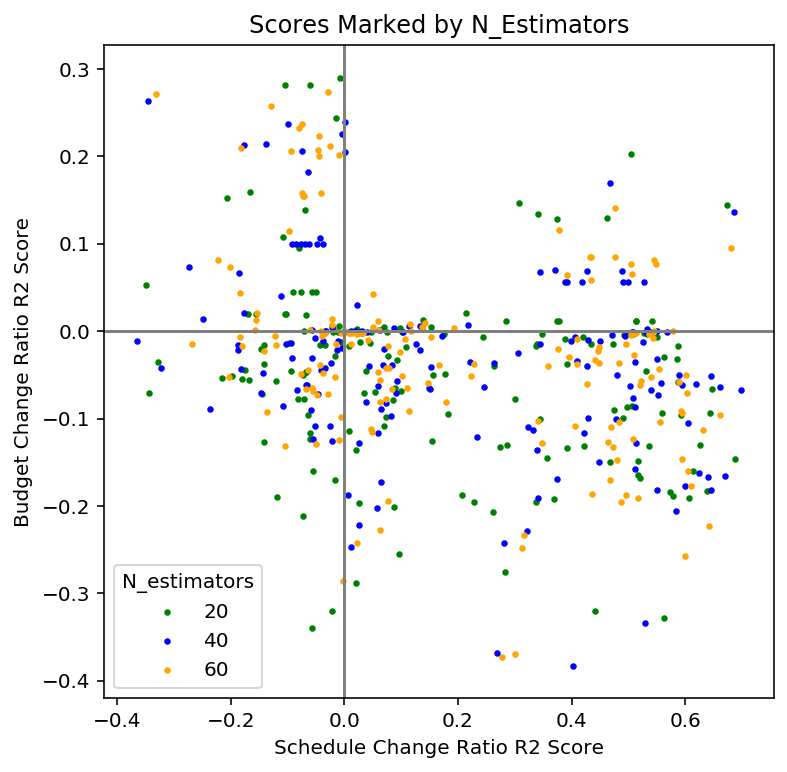

In [97]:
colors = ['g', 'b', 'orange', 'purple']
plt.figure(figsize=(6,6))

for i, e in enumerate(estimators):
    sct_data = results_no_outliers[results_no_outliers.n_estimators==e]
    plt.scatter(sct_data.test_score_sch, sct_data.test_score_bud, c=colors[i], s=5, label=e)

plt.legend()
plt.legend(title="N_estimators")
plt.title("Scores Marked by N_Estimators")
plt.axhline(c='gray')
plt.axvline(c='gray')
plt.xlabel('Schedule Change Ratio R2 Score')
plt.ylabel('Budget Change Ratio R2 Score');

### Here we want to see if there is any pattern in the n_estimators parameter.  We observe no trend that indicates any value performs consistently better than the others.

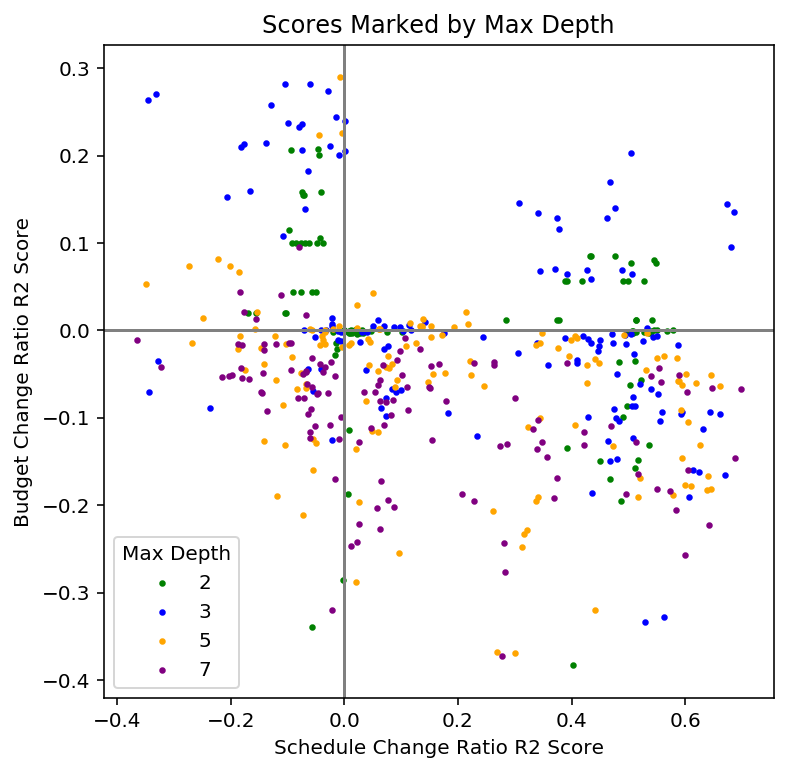

In [98]:
colors = ['g', 'b', 'orange', 'purple']
plt.figure(figsize=(6,6))

for i, m in enumerate(np.unique(max_depths)):
    sct_data = results_no_outliers[results_no_outliers.max_depth==m]
    plt.scatter(sct_data.test_score_sch, sct_data.test_score_bud, c=colors[i], s=5, label=m)

plt.legend(title="Max Depth")
plt.title("Scores Marked by Max Depth")
plt.axhline(c='gray')
plt.axvline(c='gray')
plt.xlabel('Schedule Change Ratio R2 Score')
plt.ylabel('Budget Change Ratio R2 Score');

### Here, we want to see if the maximum depth parameter has any consistent impact on the models.  We notice that the max depths of 3 perform consistently better with schedule change; however the best budget change model has a max depth of 5.   Since ADABoost learns 'fast' by also considering errors in training iterations, we can expext that lower numbers for max depth would product good results.  Predicting Budget values has been consistently more difficuly, so it makes sense that a larger max_depth is needed to find the optimal model for predicting the budget values.

## Best Scoring Schedule Change Ratio Prediction Model

Best Schedule Change Ration Prediction Model
Train Score: 0.9607
Test Score: 0.6981


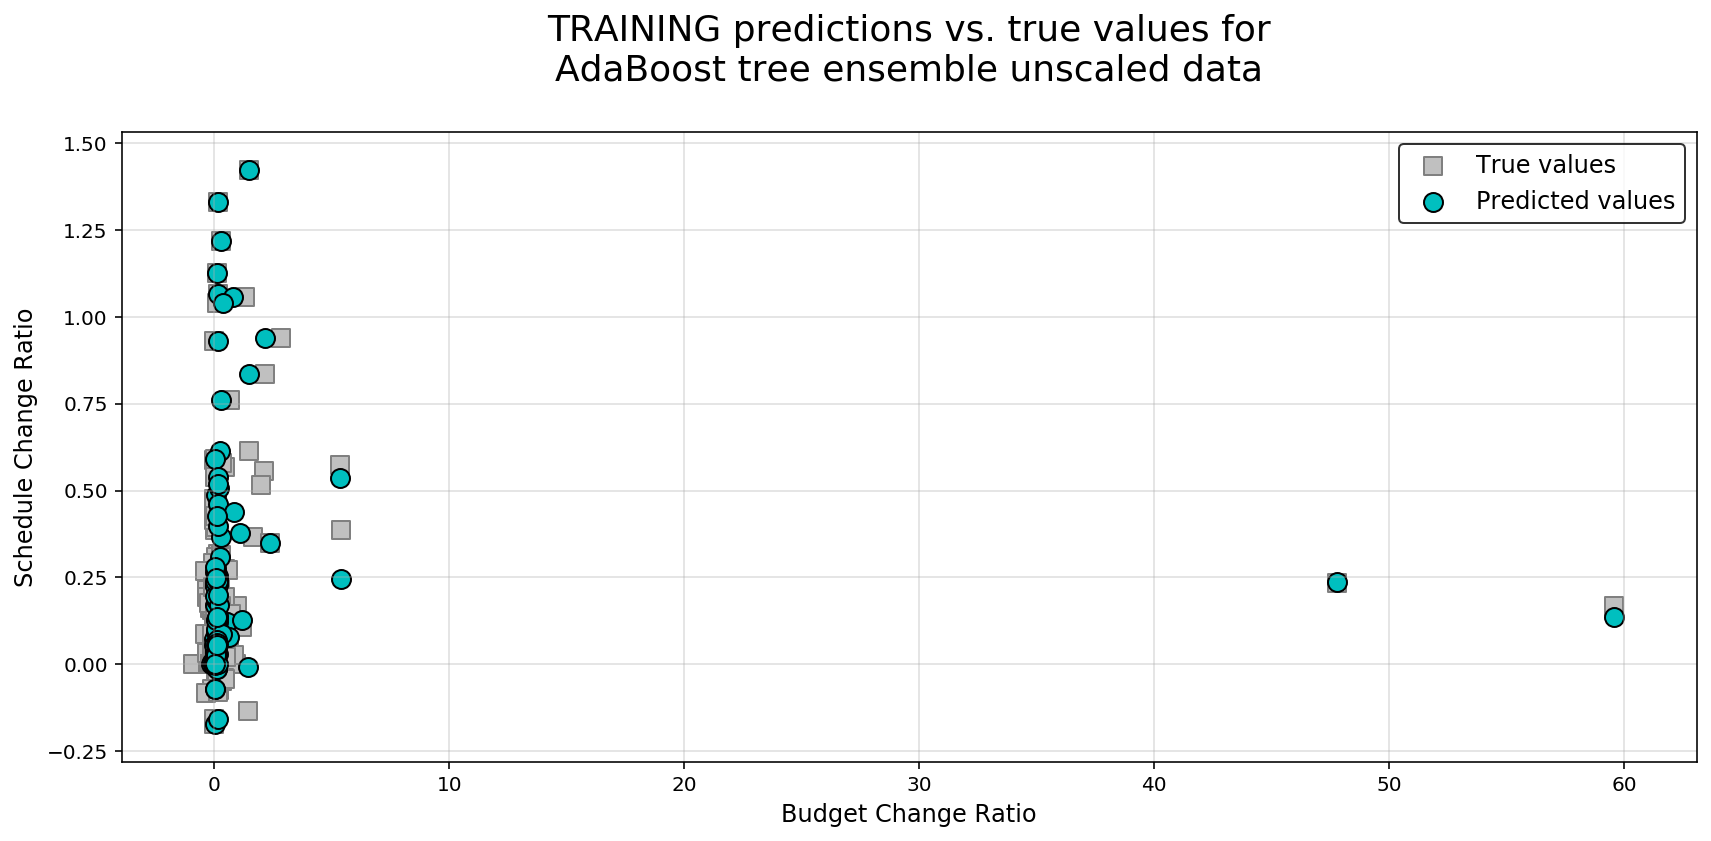

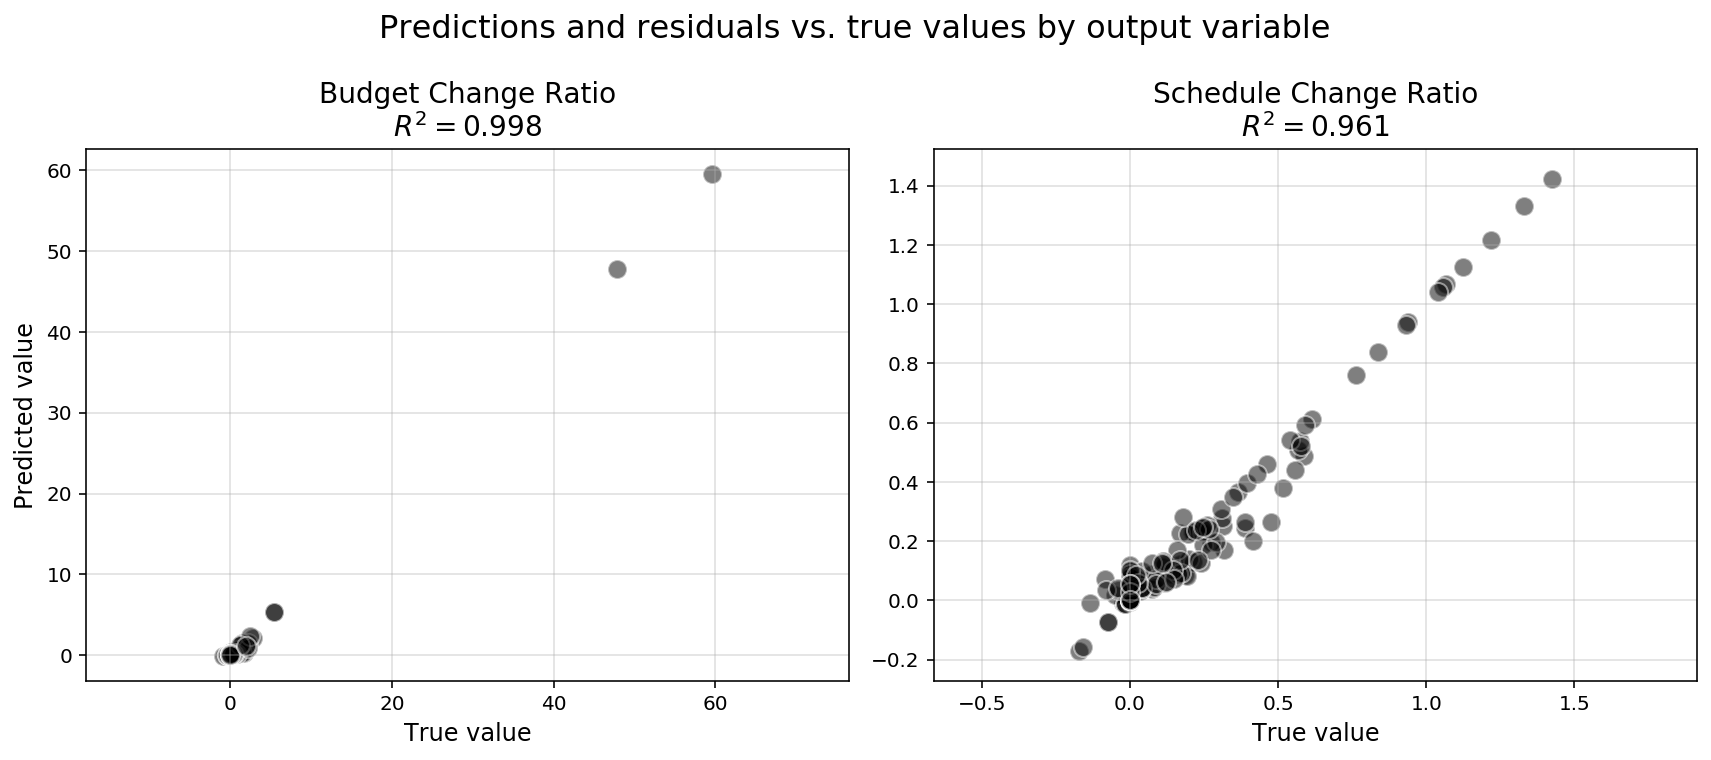

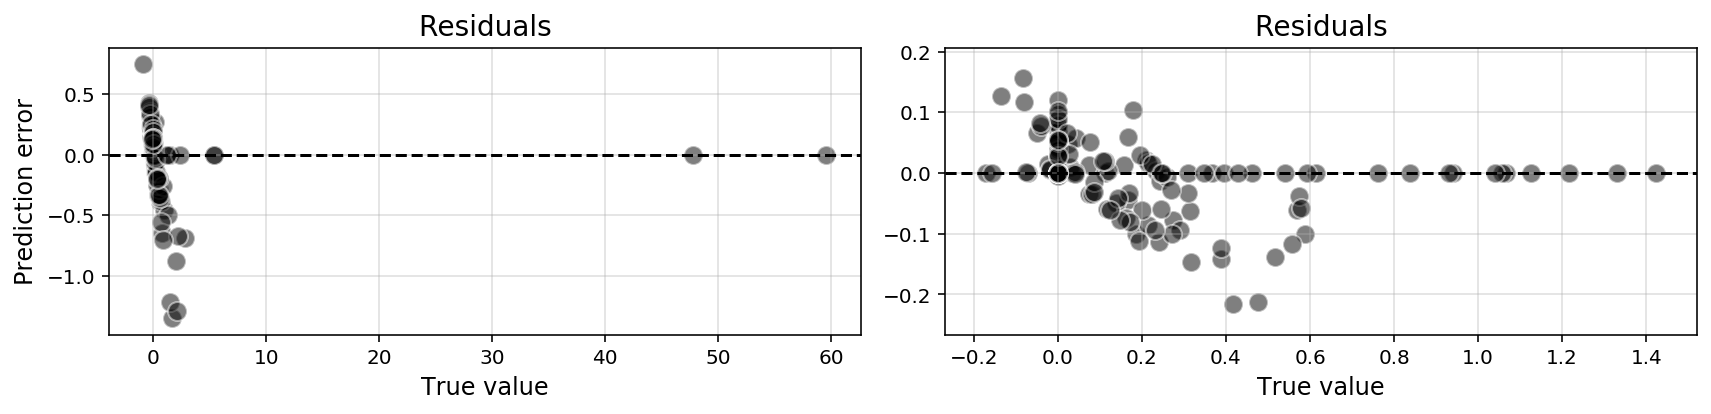

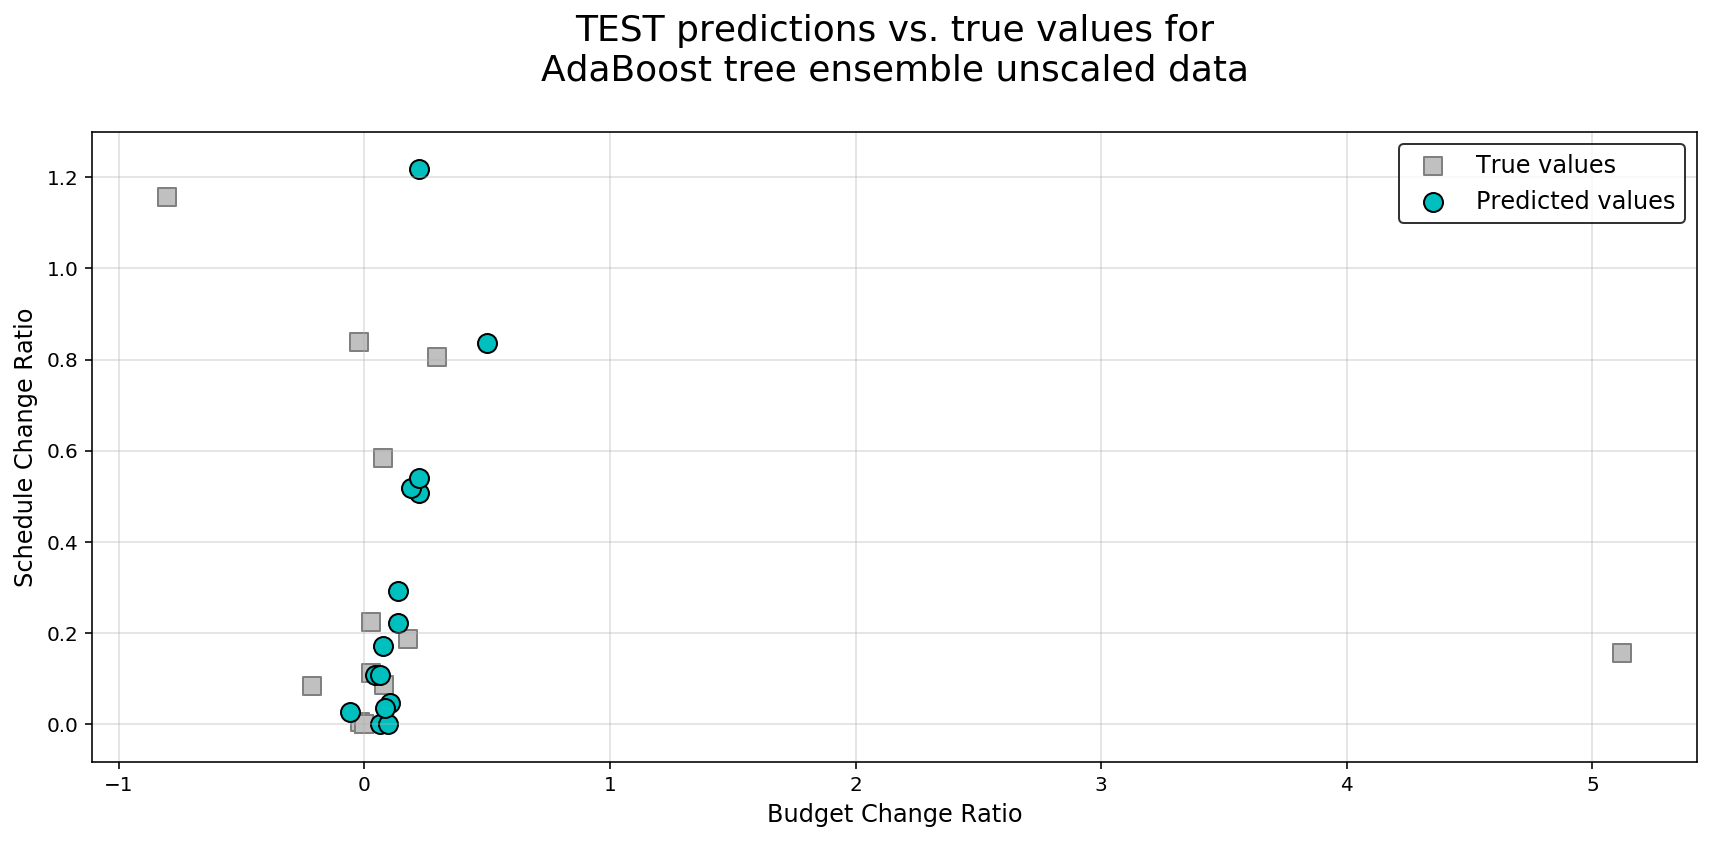

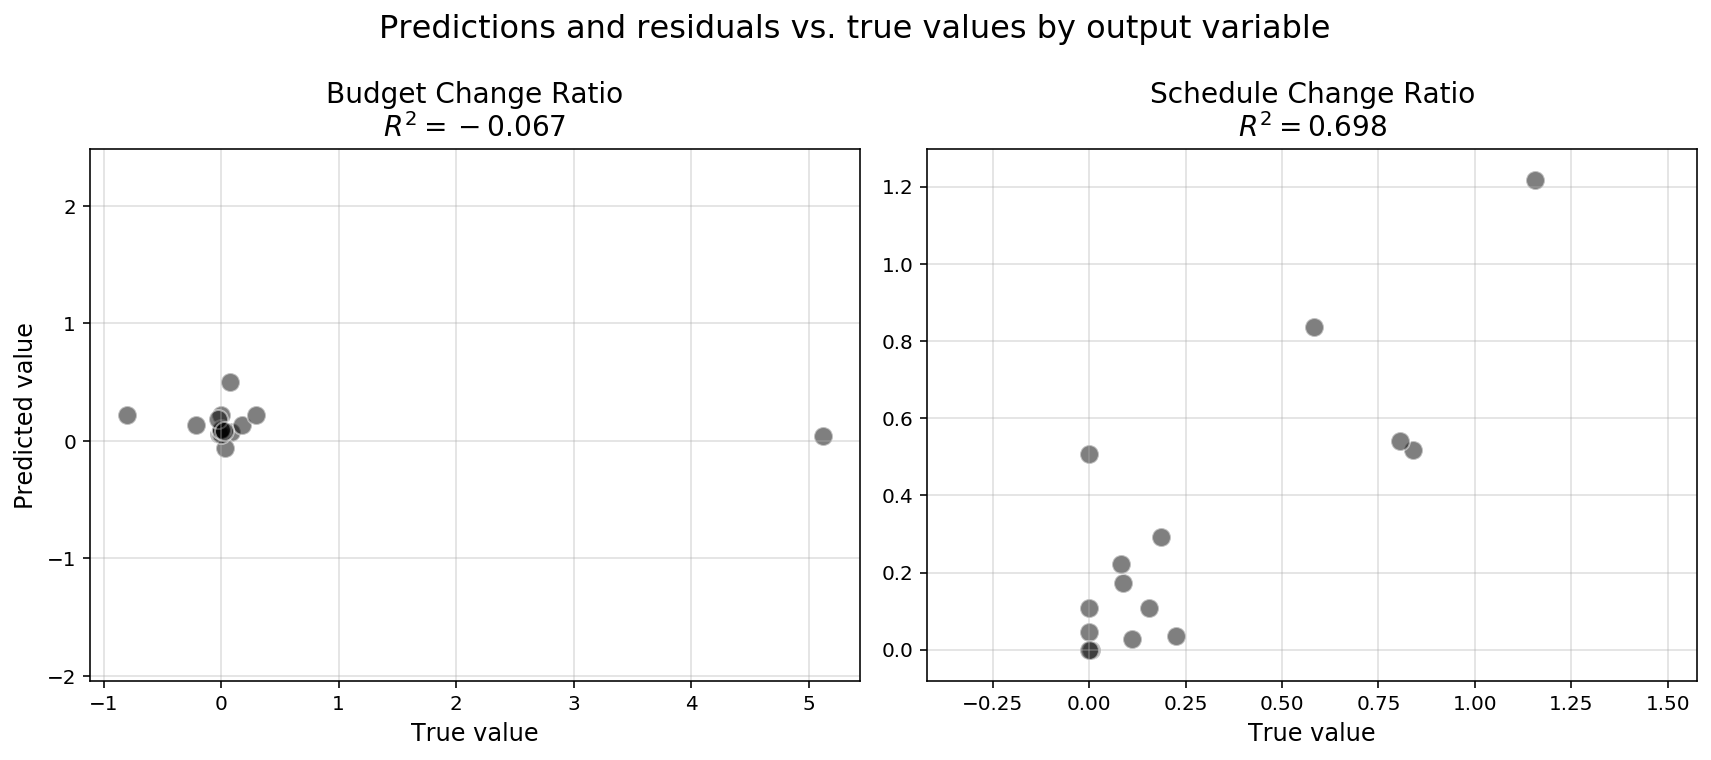

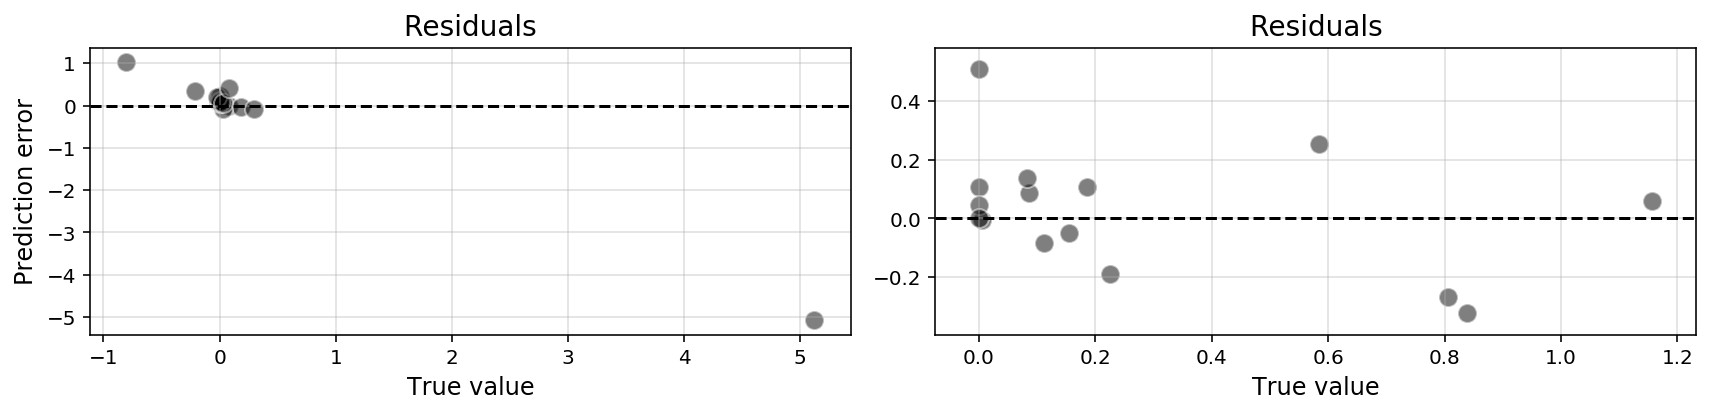

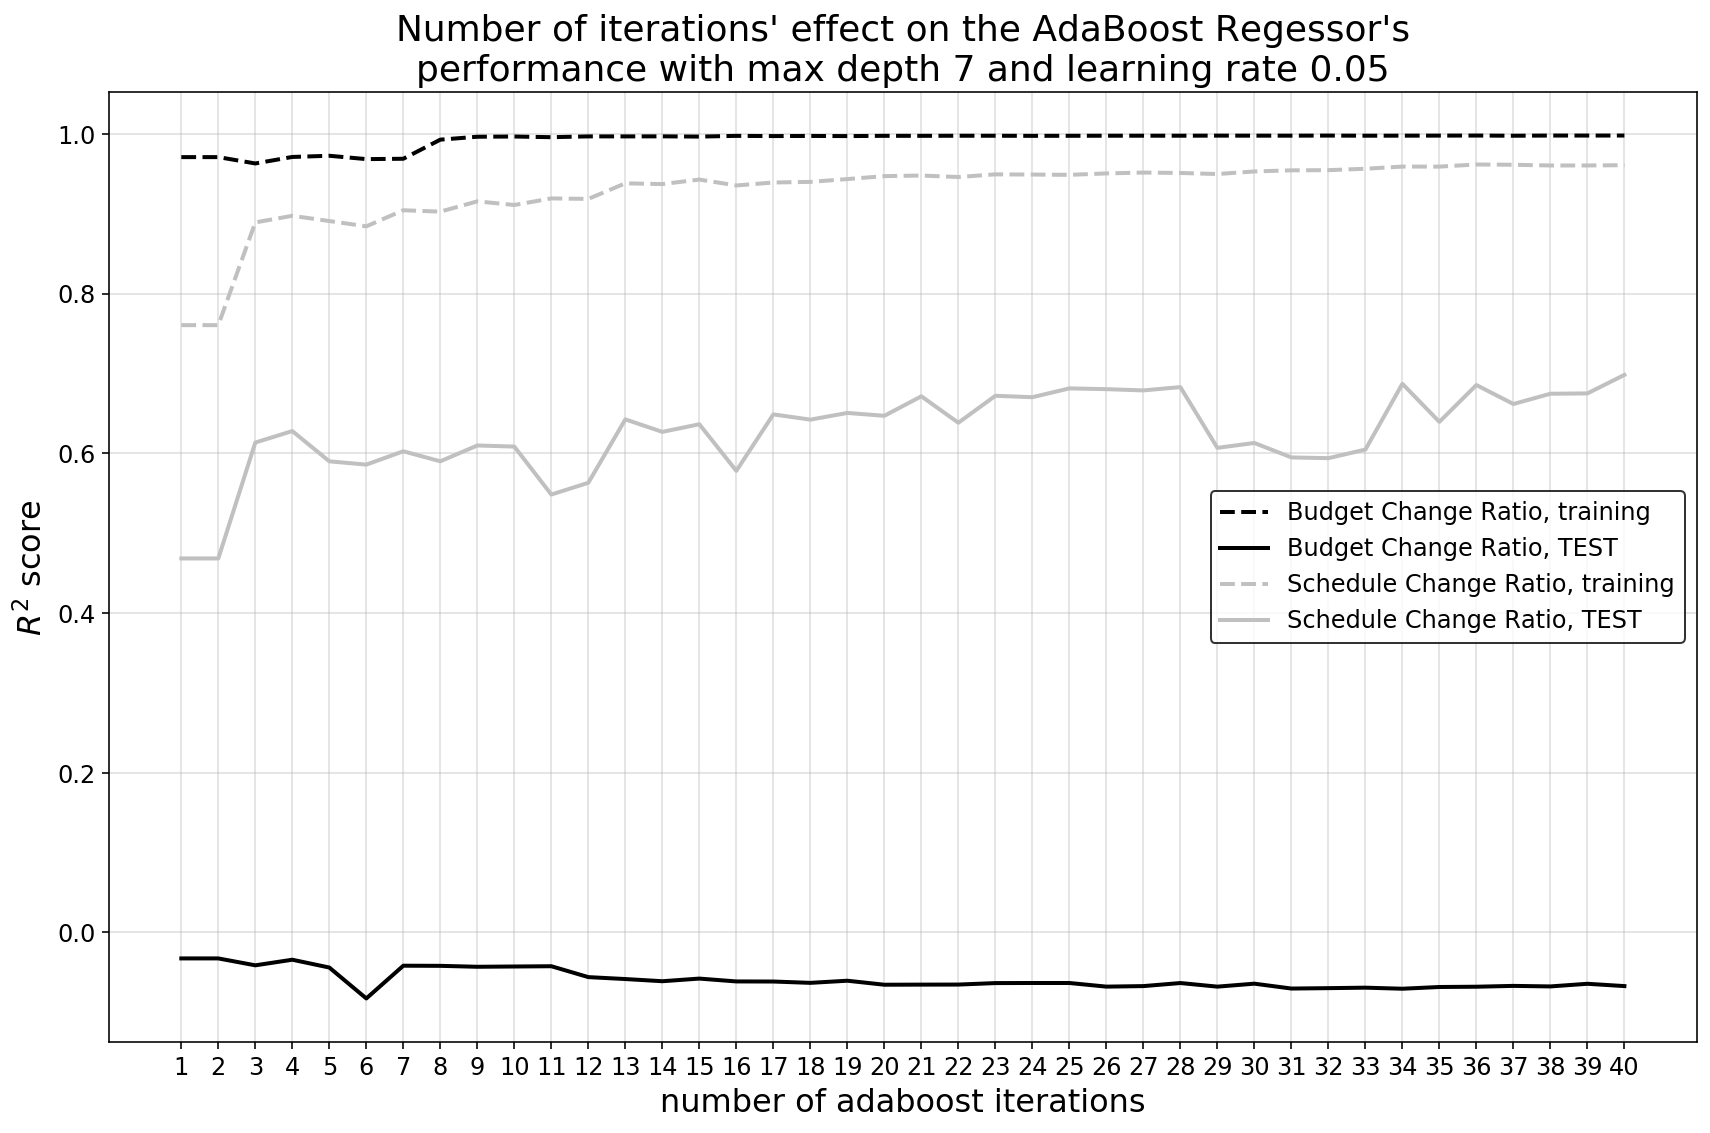

In [105]:
idx = results.sort_values(by='test_score_sch', ascending=False).iloc[0].name
m = model_dicts[idx]
best_schedule_model = m.copy()
print("Best Schedule Change Ration Prediction Model")
print(f"Train Score: {round(m['score']['train'][1],4)}")
print(f"Test Score: {round(m['score']['test'][1],4)}")
plot_true_pred(model_dict=m, dataset='train')
plot_true_pred(model_dict=m, dataset='test')
plot_adaboost_staged_scores(m, data_train[m.get('attributes')], data_test[m.get('attributes')], data_train[m.get('responses')], data_test[m.get('responses')])


## Best Scoring Budget Change Ratio Prediction Model

Best Budget Change Ratio Prediction Model
Train Score: 0.9942
Test Score: 0.2897


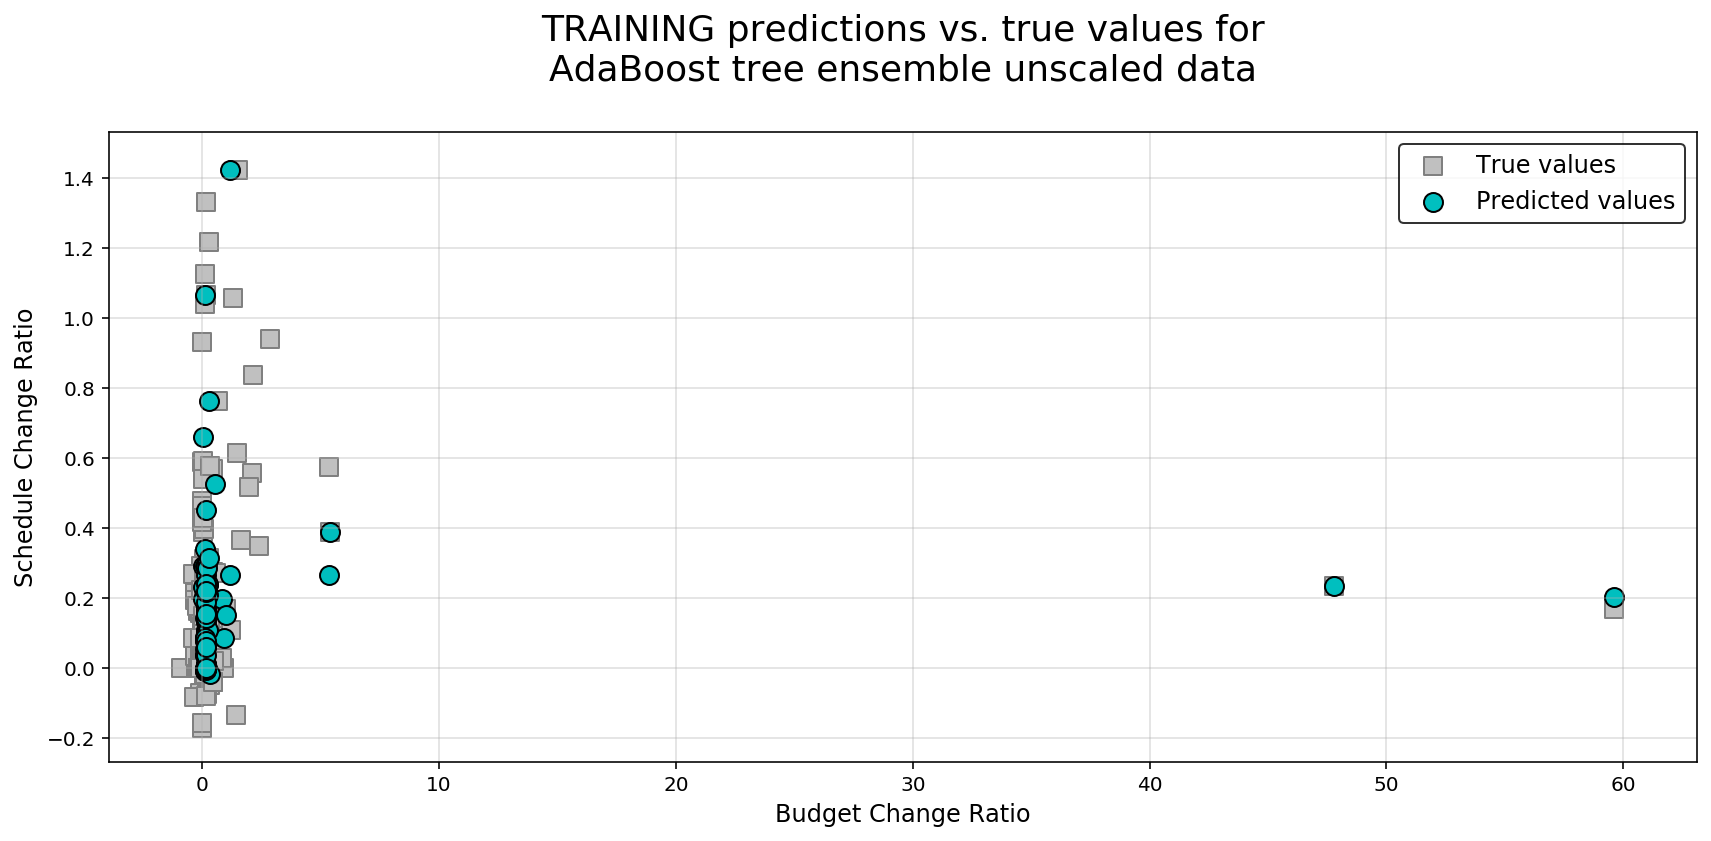

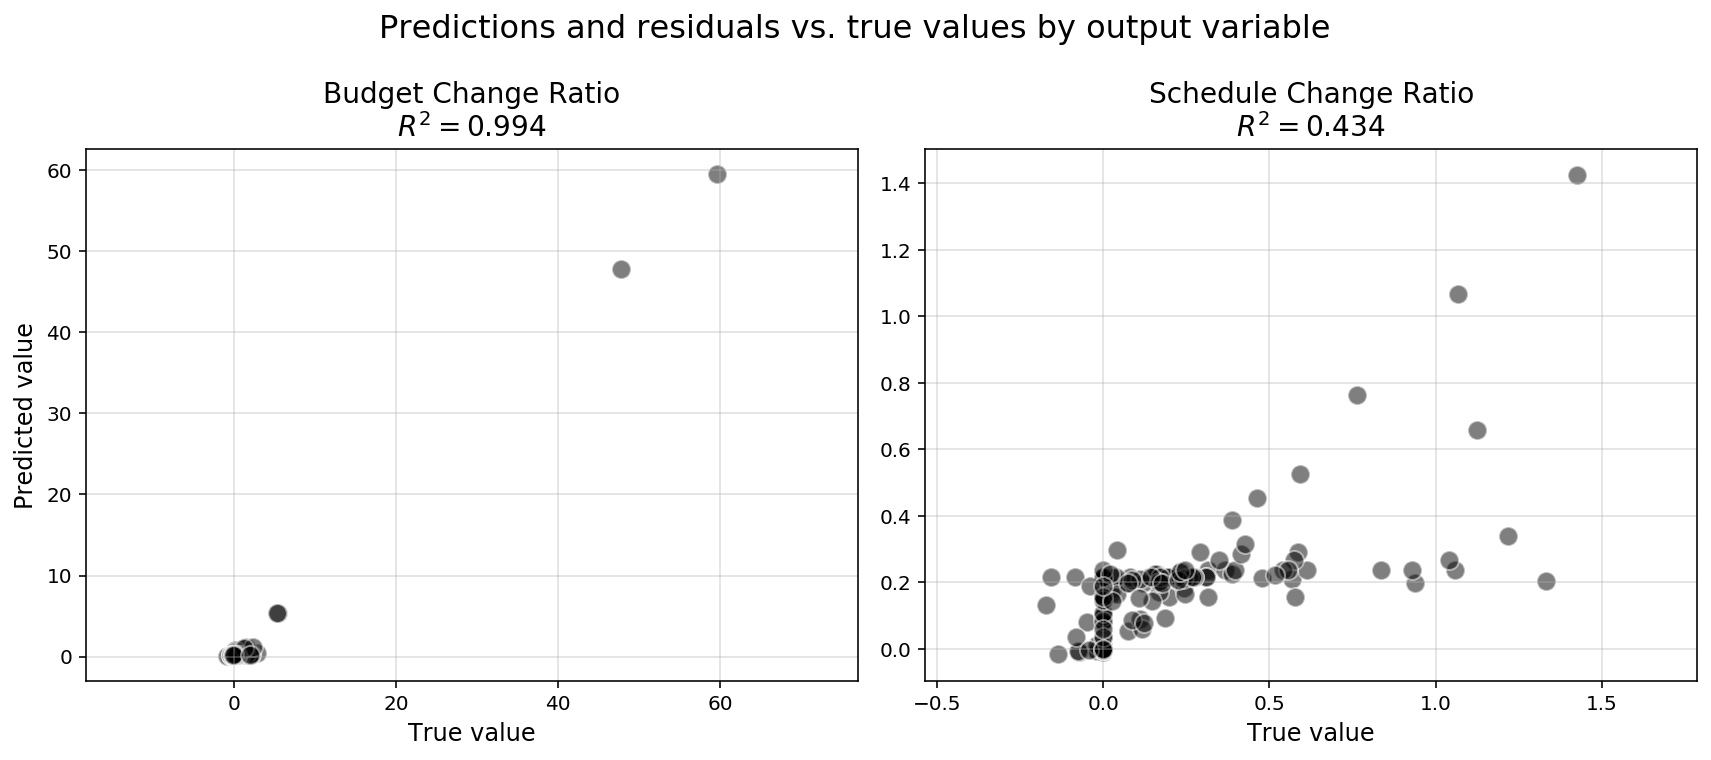

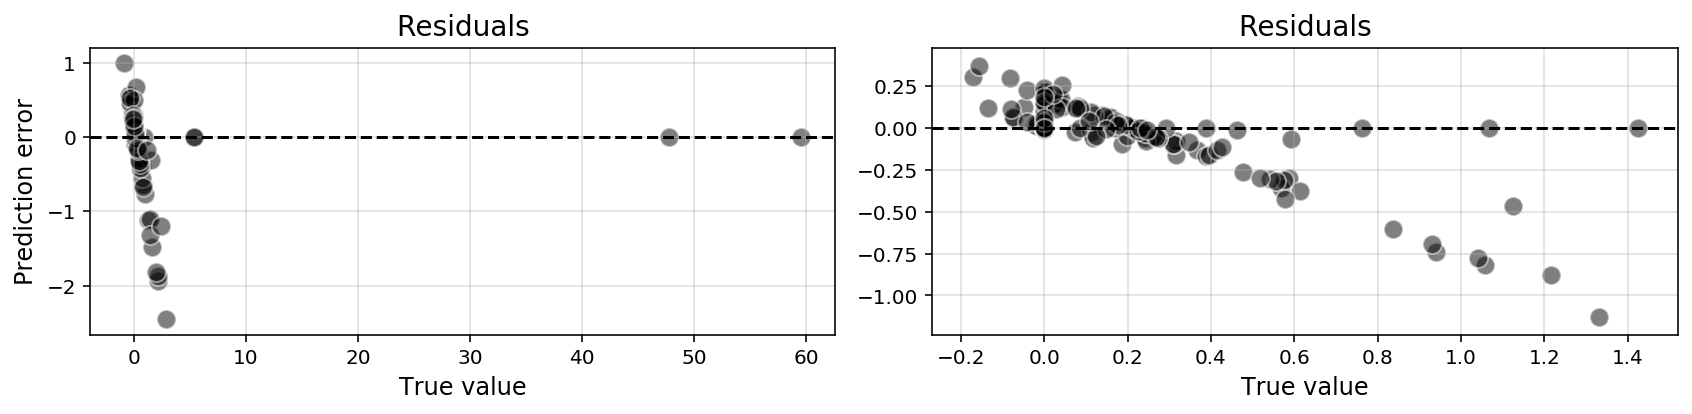

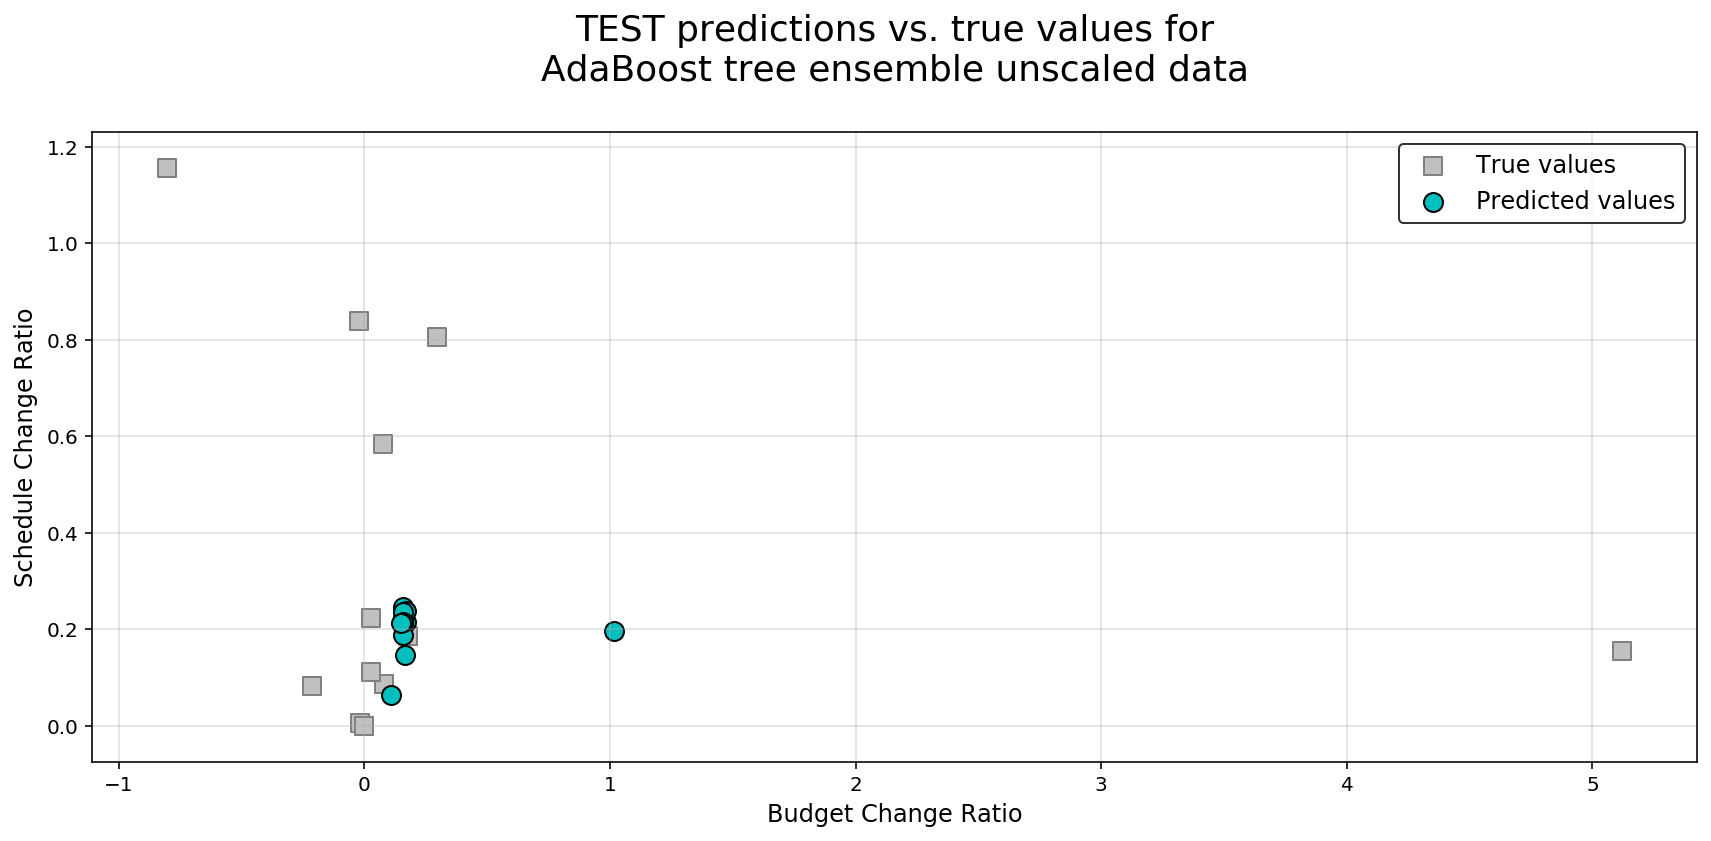

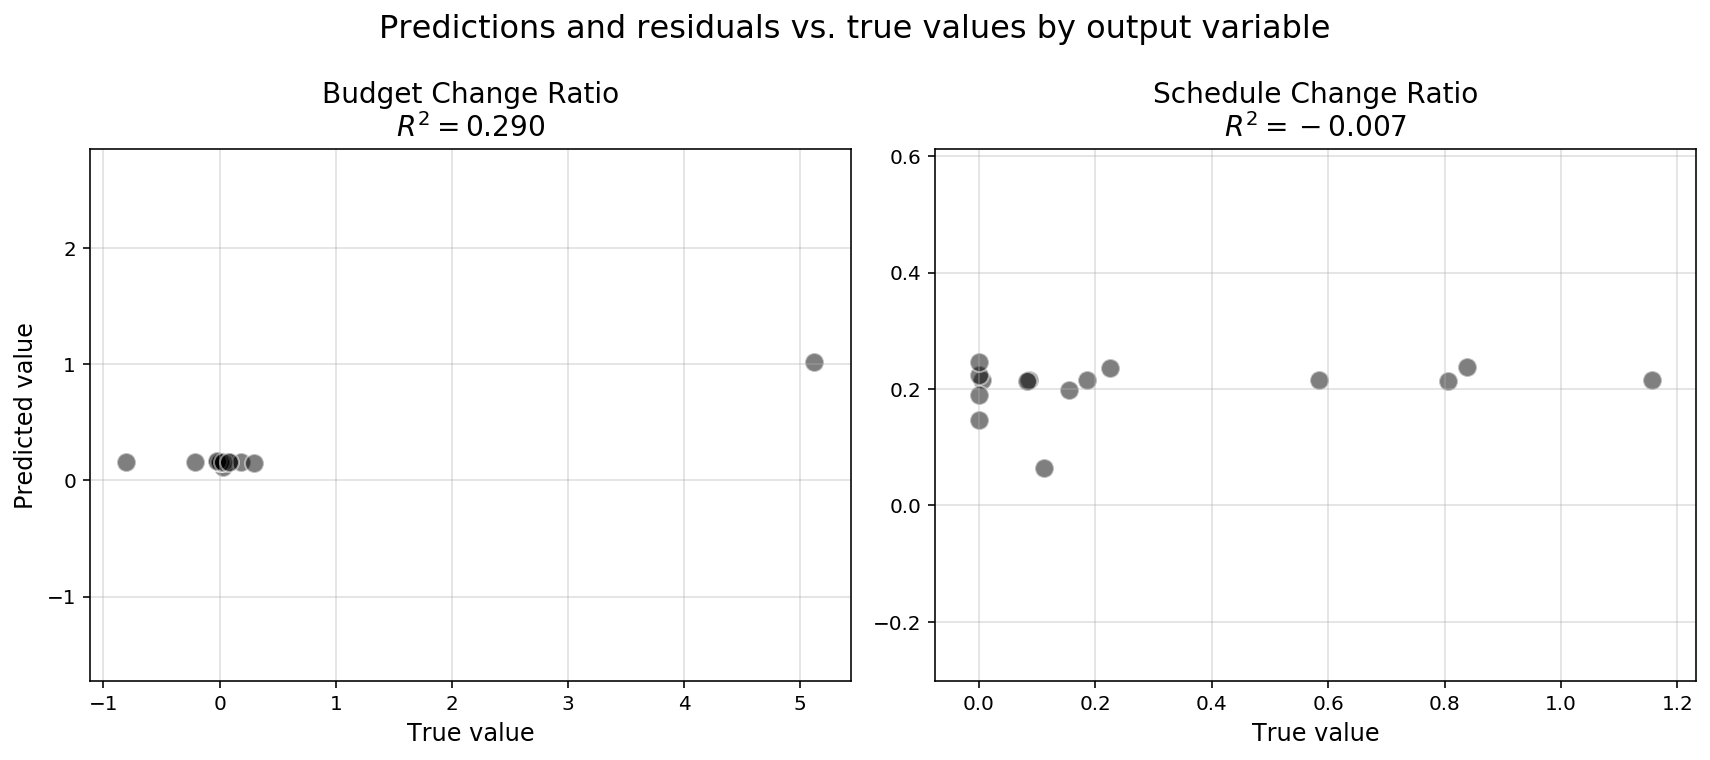

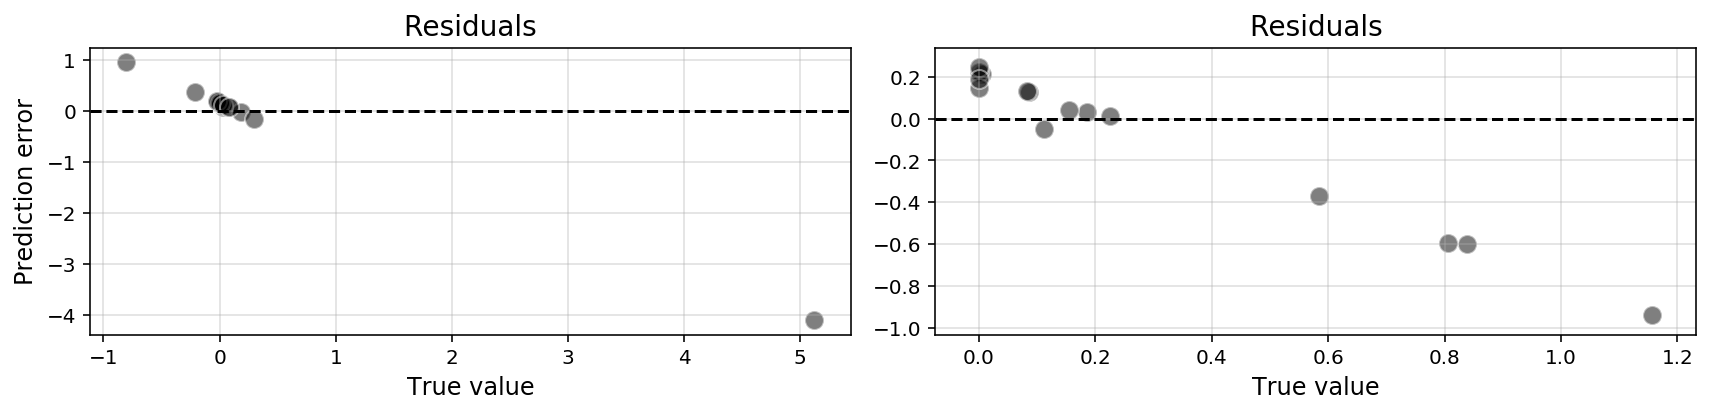

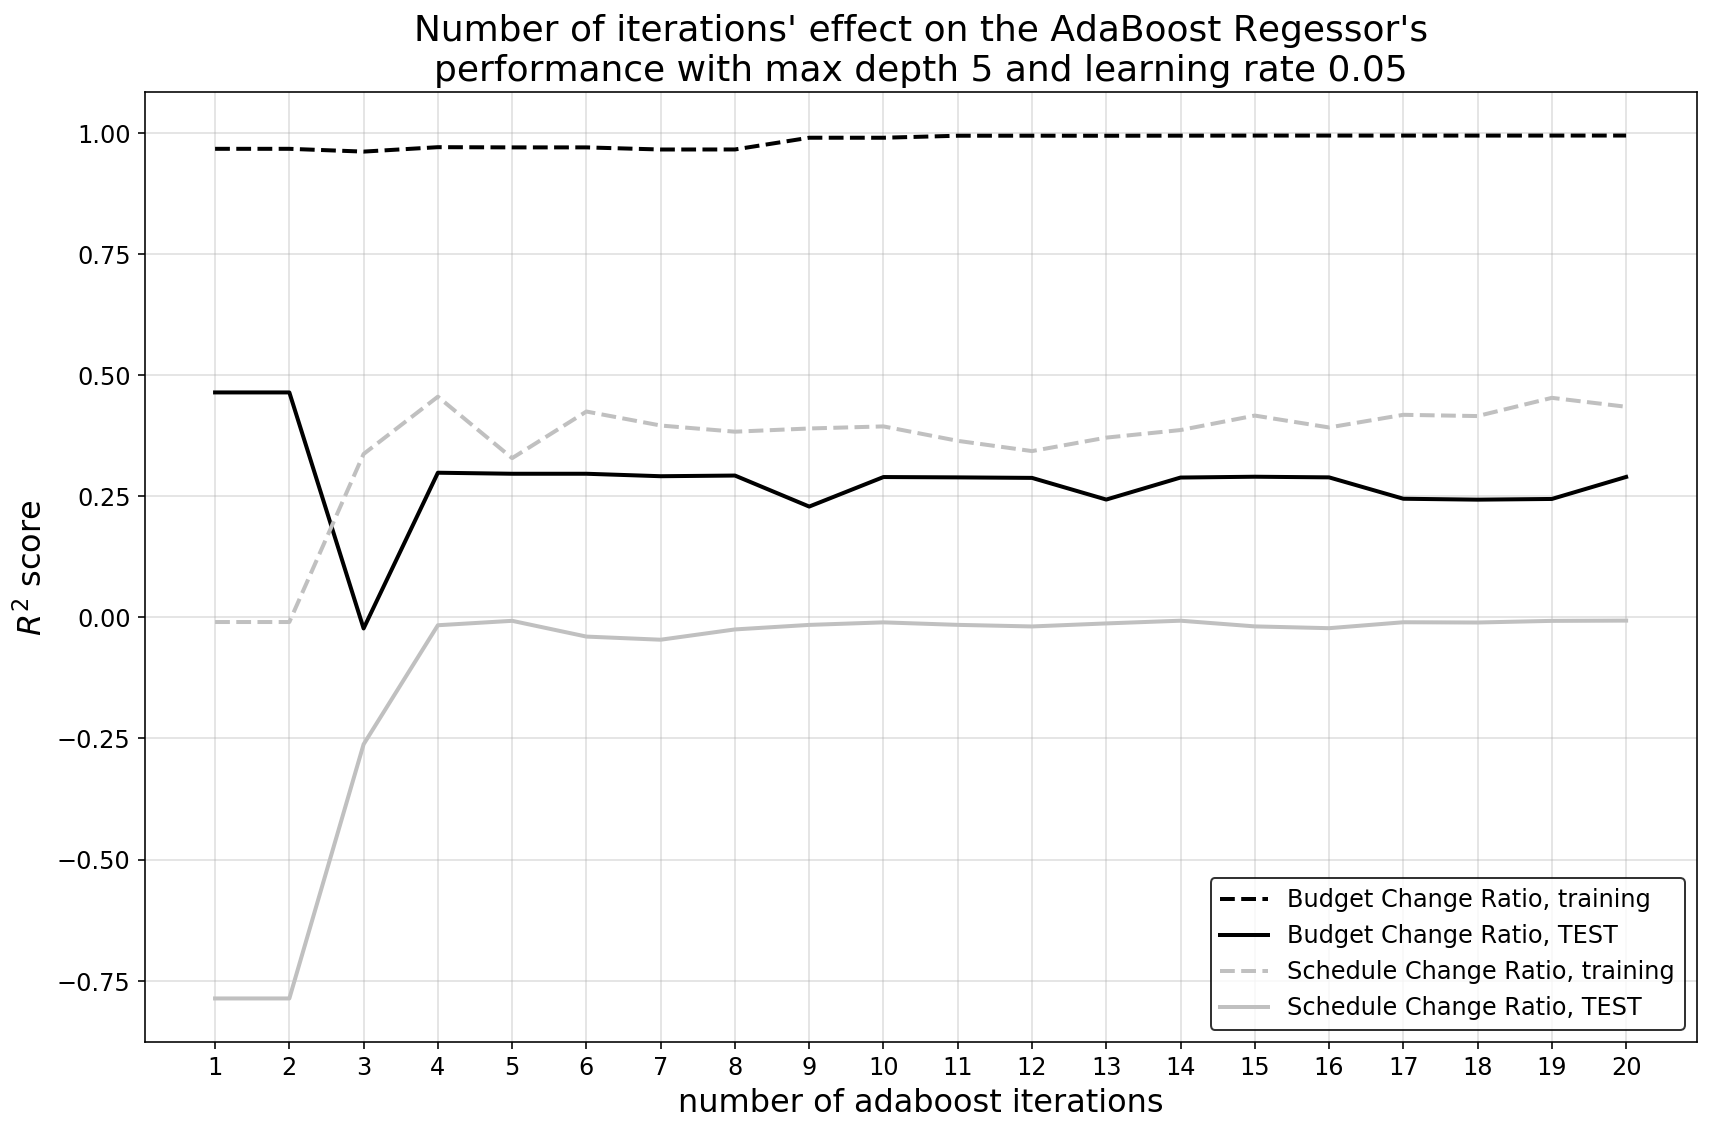

In [102]:
# best scoring model predicting schedule changes
idx = results.sort_values(by='test_score_bud', ascending=False).iloc[0].name
m = model_dicts[idx]
best_budget_model = m.copy()
print("Best Budget Change Ratio Prediction Model")
print(f"Train Score: {round(m['score']['train'][0],4)}")
print(f"Test Score: {round(m['score']['test'][0],4)}")
plot_true_pred(model_dict=m, dataset='train')
plot_true_pred(model_dict=m, dataset='test')
plot_adaboost_staged_scores(m, data_train[m.get('attributes')], data_test[m.get('attributes')], data_train[m.get('responses')], data_test[m.get('responses')])


### Again, the most complling chart is the last one.  This model was optimized for schedule change and we see a reasonably good performance that increases with more iterations.  The model which trains on 60 iterations was not chosen as optimal so we can safely assume that performance drops after 40 iterations.  Again, we note that the budget predictions perform poorly here as this model is not optimized for budget predictions.

In [106]:
y_pred_train = np.hstack(
    [
        best_schedule_model['predictions']['train'][:, 0].reshape(-1,1),
        best_budget_model['predictions']['train'][:, 1].reshape(-1,1)
    ]
)

y_pred_test = np.hstack(
    [
        best_schedule_model['predictions']['test'][:, 0].reshape(-1,1),
        best_budget_model['predictions']['test'][:, 1].reshape(-1,1)
    ]
)

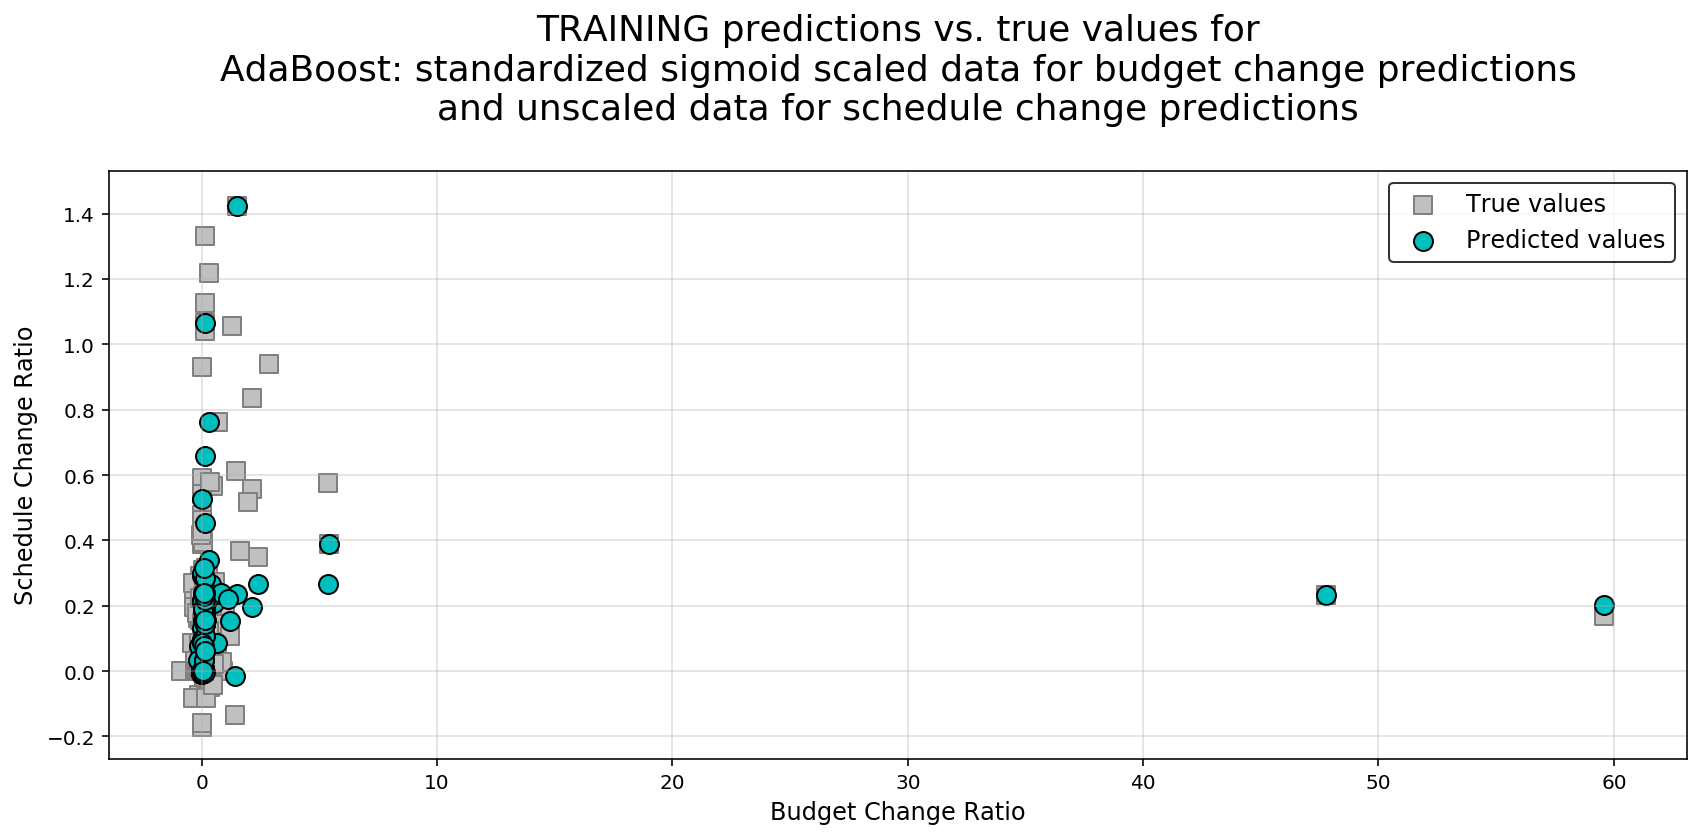

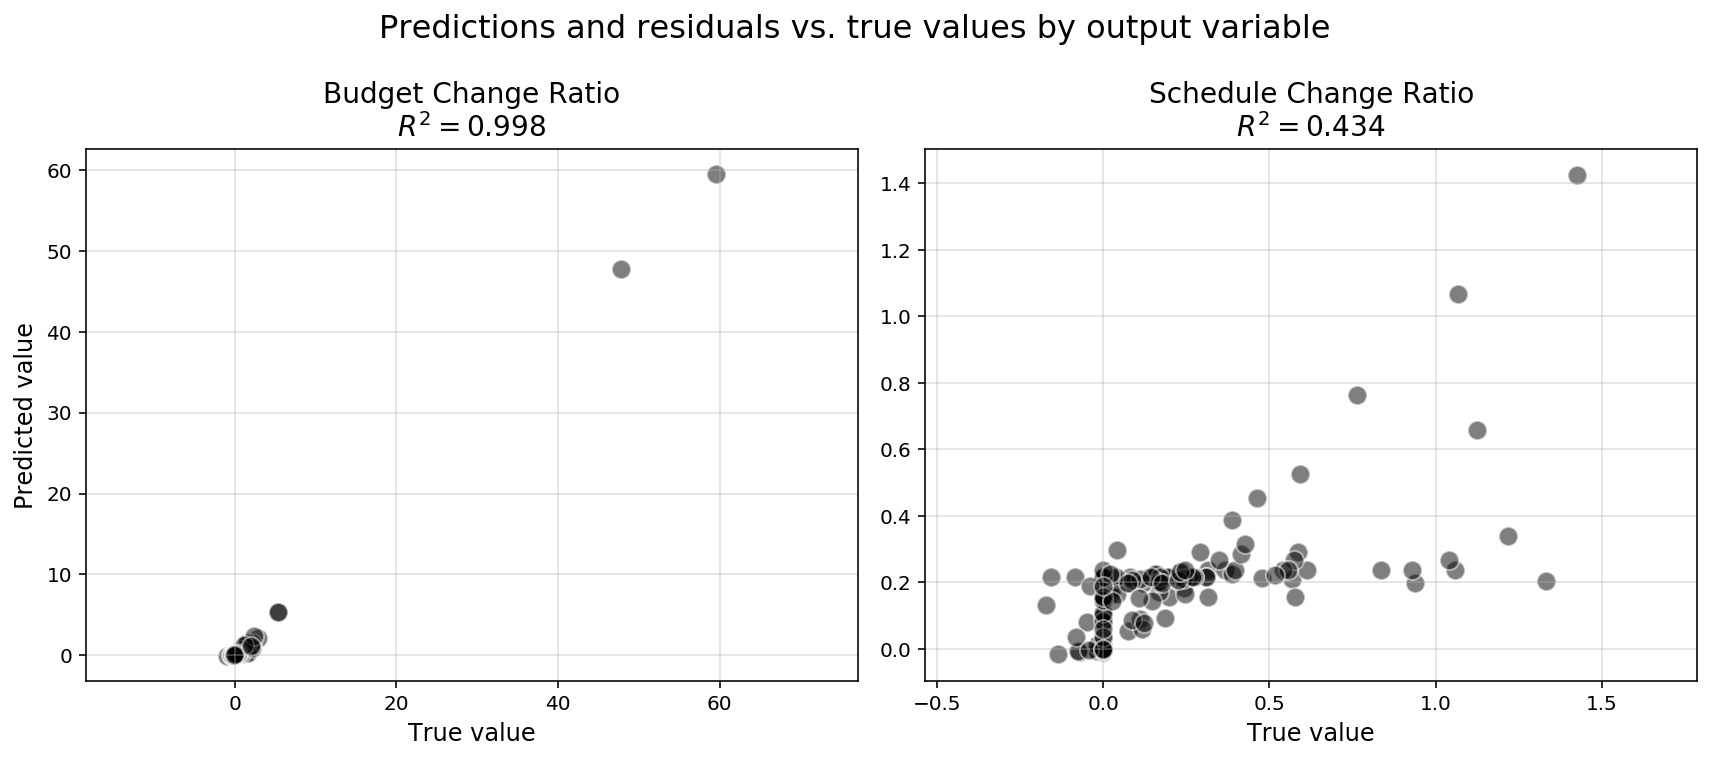

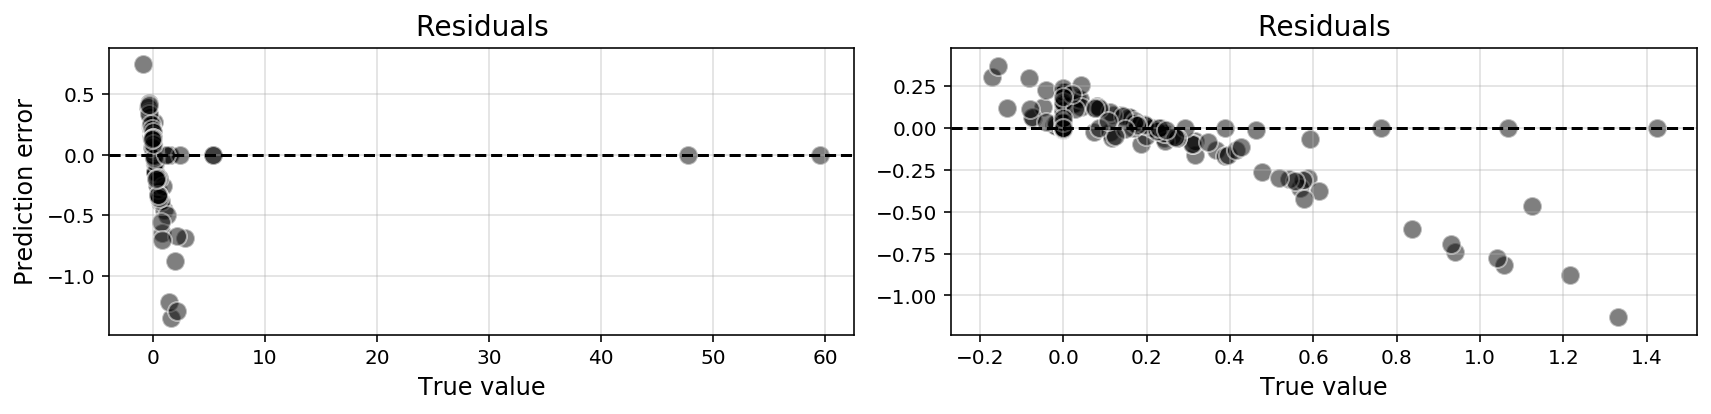

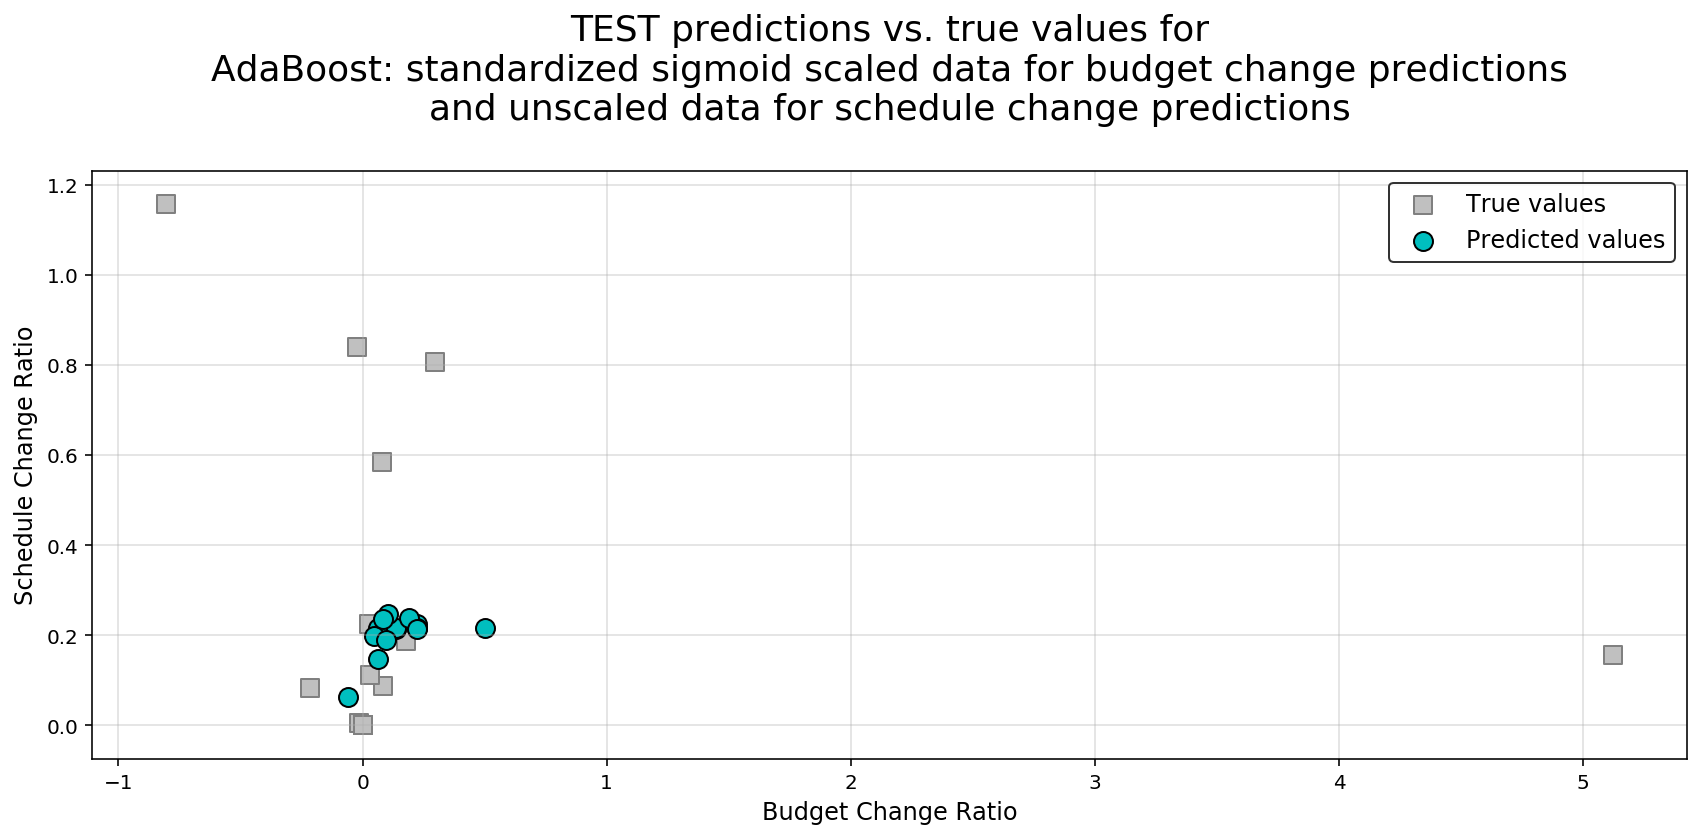

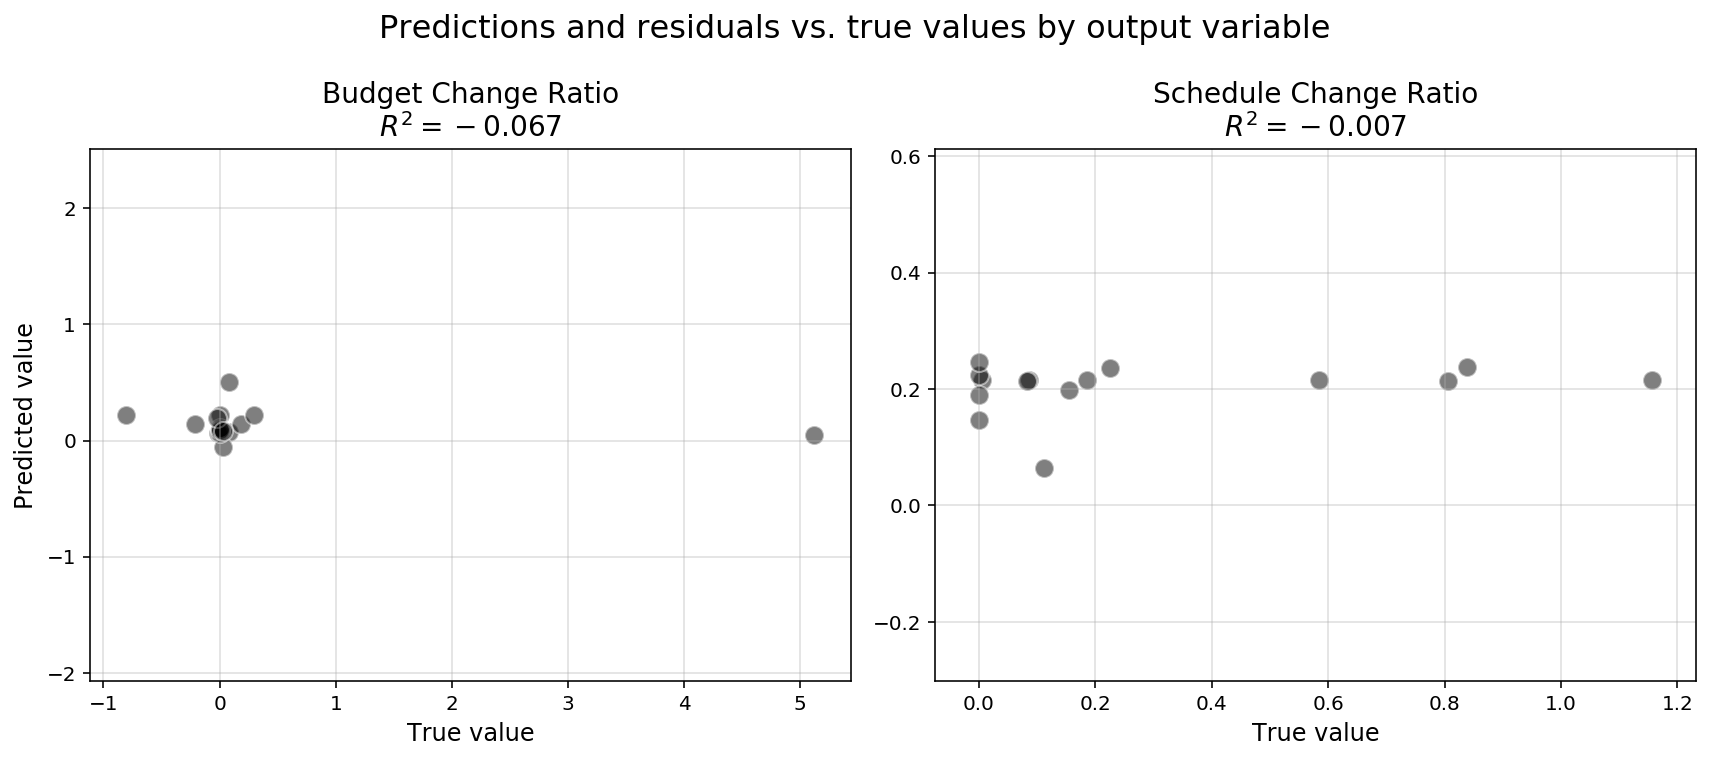

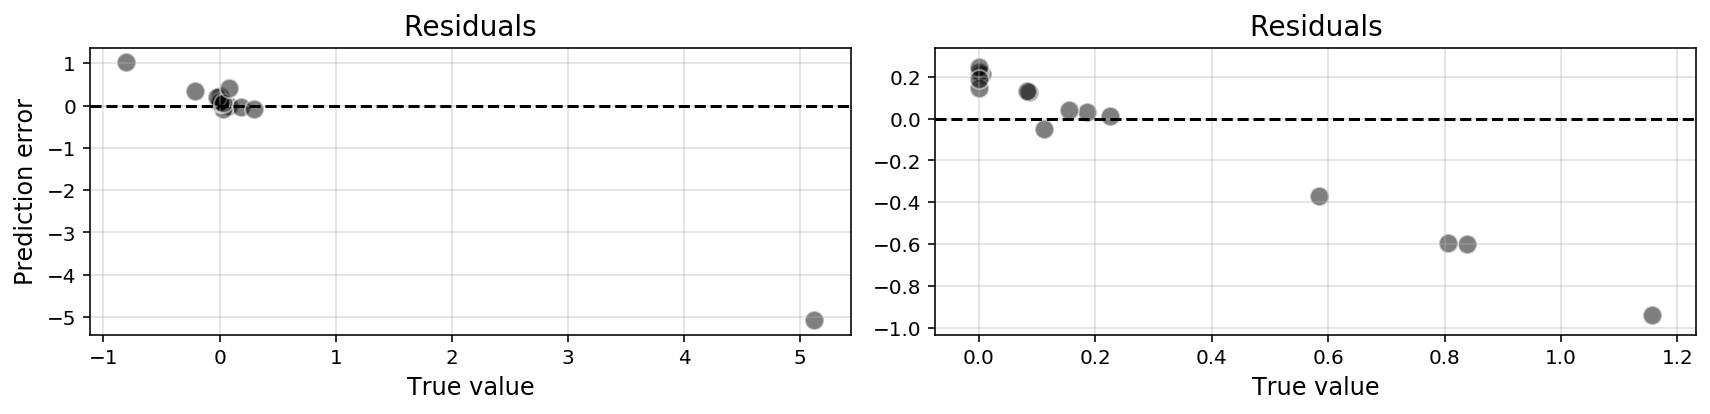

In [107]:
model_descr = 'AdaBoost: standardized sigmoid scaled data for budget change predictions\n'\
              'and unscaled data for schedule change predictions'
y1_label = 'Budget Change Ratio'
y2_label = 'Schedule Change Ratio'

plot_true_pred(
    dataset='train',
    y_true=data_train[[y1_label.replace(' ','_'), y2_label.replace(' ','_')]], # y_train,
    y_pred=y_pred_train,
    y1_label=y1_label,
    y2_label=y2_label,
    model_descr=model_descr
)
plot_true_pred(
    dataset='test',
    y_true=data_test[[y1_label.replace(' ','_'), y2_label.replace(' ','_')]], #y_test,
    y_pred=y_pred_test,
    y1_label=y1_label,
    y2_label=y2_label,
    model_descr=model_descr
)

<a name='conclusions'></a>

# 6. Conclusions 

<a href=#index>Index</a>

<a name='future'></a>

# 7. Next steps & future work

<a href=#index>Index</a>

<a name='sources'></a>

# 8. Sources & References 

<a href=#index>Index</a>

<a name='appendix'></a>

# 9. Appendix 

<a href=#index>Index</a>

**IN THIS SECTION:**

**9.1. <a href=#dict>Dictionary of features in final dataset</a>**

<a name='dict'></a>

## 9.1. Data Dictionary of Features In Final Dataset

<a href=#appendix>Return to section index</a>

**The `.csv` file used to generate this data dictionary can be [found here on GitHub.](https://github.com/mcdomx/cs109b_groupproject/blob/master/references/data_dicts/data_dict_interval.csv)**